In [1]:
!pip install bertopic==0.16.4 sentence-transformers==3.0.1 umap-learn hdbscan scikit-learn==1.4.2

import os
import re
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

import matplotlib.pyplot as plt

INFO: pip is looking at multiple versions of umap-learn to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: umap-learn
    Found existing installation: umap-learn 0.5.9.post2
    Uninstalling umap-learn-0.5.9.post2:
      Successfully uninstalled umap-learn-0.5.9.post2
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.0
    Uninstalling sentence-transformers-5.1.0:
      Successfully 

/usr/local/lib/python3.12/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [2]:
RAW_URL = "https://raw.githubusercontent.com/WinNatch/Dissertation/main/combined_sentiment_data.csv"
df = pd.read_csv(RAW_URL, low_memory=False)

assert "clean_text" in df.columns, "Expected 'clean_text' in the CSV."

def light_normalize(s: str) -> str:
    s = re.sub(r"http\S+|www\.\S+", " ", str(s))
    s = re.sub(r"&amp;|&lt;|&gt;", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean_text"] = df["clean_text"].astype(str).map(light_normalize)
df["token_count"] = df["clean_text"].str.split().str.len()
df = df[df["token_count"] >= 3].copy()

dedupe_keys = ["id"] if "id" in df.columns else ["clean_text","date","source"]
df = df.drop_duplicates(subset=dedupe_keys).reset_index(drop=True)

print("Rows after light cleanup:", len(df))
df.head()

Rows after light cleanup: 59539


date                                               text  \
0  2024-07-01 00:26:42  @_hoodxhippie @Airbnb Marriott has stuff on th...   
1  2024-07-01 00:51:46  @MrNIOinc @Airbnb It looks you are having a ro...   
2  2024-07-01 01:11:53  @the_q_478 @Airbnb I will be looking into that...   
3  2024-07-01 01:22:29  @Airbnb @bchesky got falsely blamed for damagi...   
4  2024-07-01 01:27:06  So what is wrong about the review via guest an...   

        source                                         clean_text  \
0  X (Twitter)  hoodxhippie marriott stuff vacation club townh...   
1  X (Twitter)        mrnioinc rough peru colombia paradise buddy   
2  X (Twitter)                               forward air bnb life   
3  X (Twitter)  bchesky falsely blame damage pay damage photo ...   
4  X (Twitter)  wrong exploit simply ruin operation easily roh...   

  sentiment_label  sentiment_score  token_count  
0         label_1         0.869354            8  
1         label_1         0.793845            6  
2         label_1         0.763022            4  
3         label_0         0.802599           16  
4         label_0         0.872964           10

**BERTOPIC**

In [3]:
import random
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

In [4]:
np.random.seed(42)
random.seed(42)

domain_stop = {
    "rt","amp","url","pls","please","thanks","thank", "air", "bnb", "air bnb",
    "customer","service","support","brand","company","help","hi","hello"
}
stop_words = list(ENGLISH_STOP_WORDS.union(domain_stop))

vectorizer = CountVectorizer(
    ngram_range=(1,2),
    min_df=20,
    max_df=0.40,
    stop_words=stop_words
)

# Embeddings
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(
    df["clean_text"].tolist(),
    batch_size=256,
    show_progress_bar=True,
    normalize_embeddings=True
)

umap_model = UMAP(
    n_neighbors=15, n_components=5, min_dist=0.0,
    metric="cosine", random_state=42
)
hdbscan_model = HDBSCAN(
    min_cluster_size=25, min_samples=None,
    metric="euclidean", cluster_selection_method="eom",
    prediction_data=True
)

topic_model = BERTopic(
    vectorizer_model=vectorizer,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    nr_topics="auto",
    verbose=True
)

topics, probs = topic_model.fit_transform(df["clean_text"].tolist(), embeddings)
df["topic"] = topics
df["topic_prob"] = probs.max(axis=1)

topic_info = topic_model.get_topic_info()
display(topic_info.head(15))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/233 [00:00<?, ?it/s]

2025-08-25 17:09:17,964 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-25 17:10:49,222 - BERTopic - Dimensionality - Completed ✓
2025-08-25 17:10:49,224 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-25 17:16:31,261 - BERTopic - Cluster - Completed ✓
2025-08-25 17:16:31,262 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-08-25 17:16:33,174 - BERTopic - Representation - Completed ✓
2025-08-25 17:16:33,174 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 17:16:35,220 - BERTopic - Topic reduction - Reduced number of topics from 353 to 275


Topic  Count                                               Name  \
0      -1  24143                  -1_damage_refund_grandeunext_scam   
1       0   2862     0_reservation_cancel_cancel reservation_refund   
2       1   2132                  1_cleaning fee_cleaning_fee_clean   
3       2   1317                   2_card_credit card_credit_damage   
4       3    961                      3_superhost_die_effort_status   
5       4    694                          4_video_picture_photo_pic   
6       5    688                      5_aircover_airb_negative_burn   
7       6    684                         6_tesla_boycott_elon_trump   
8       7    614                 7_grandeunext_deserve_racist_block   
9       8    603  8_communication payment_remember communication...   
10      9    590                          9_laugh_stage_creepy_dude   
11     10    590                      10_bchesky_design_happy_brian   
12     11    532                           11_woman_beat_quote_male   
13     12    498                      12_waste_government_tax_fraud   
14     13    470                        13_hilton_occupy_board_hole   

                                       Representation  \
0   [damage, refund, grandeunext, scam, term, char...   
1   [reservation, cancel, cancel reservation, refu...   
2   [cleaning fee, cleaning, fee, clean, scam, saf...   
3   [card, credit card, credit, damage, bank, char...   
4   [superhost, die, effort, status, ignore, vibe,...   
5   [video, picture, photo, pic, walk, car, photog...   
6   [aircover, airb, negative, burn, remove, suck,...   
7   [tesla, boycott, elon, trump, liberal, democra...   
8   [grandeunext, deserve, racist, block, lmao, in...   
9   [communication payment, remember communication...   
10  [laugh, stage, creepy, dude, secret, hilarious...   
11  [bchesky, design, happy, brian, decision, remo...   
12  [woman, beat, quote, male, criminal, paris, sh...   
13  [waste, government, tax, fraud, abuse, dollar,...   
14  [hilton, occupy, board, hole, hospitality, fak...   

                                  Representative_Docs  
0   [discussion damage protection policy aircover ...  
1   [cancel reservation cancel reservation state i...  
2   [roommate cleaning fee stop, osint charge clea...  
3   [cancel credit card charge, cancel credit card...  
4   [ohmygrace superhost tirelessly delight attemp...  
5   [terrified extensive video end, videoiot like ...  
6   [remove negative airb remove negative quote po...  
7   [elon trump breathe air dumb fuck boycott, bur...  
8   [grandeunext read sound crazy, grandeunext lol...  
9   [list define usa conversation civil respectful...  
10  [southdallasfood laugh lol, southdallasfood la...  
11  [professor bchesky thank, traestephen bchesky ...  
12  [seb dlp brookecrain watch man beat woman woma...  
13  [like waste fraud government, weed government ...  
14  [carefull bookingcom homelike canarias swindle...

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

brand_stop = {
    "air","bnb","airbnb","air-bnb","air bnb","abnb","airbnbs","airbnb's", "airb", "bnbs", "tanya", "tanya sabrinaaa", "sabrinaaa",
    "aircover","superhost","host","guest", "scam", "hilton", "bchesky", "grandeunext", "barne", "barne", "cocacola"
}
boilerplate_stop = {
    "rt","amp","url","pls","please","thanks","thank", "lfleezy", "ball", "dick", "prefer", "ass",
    "customer","service","support","brand","company","help","hi","hello"
}
stop_words2 = list(ENGLISH_STOP_WORDS.union(brand_stop).union(boilerplate_stop))

vectorizer2 = CountVectorizer(
    ngram_range=(1,2),
    min_df=20,
    max_df=0.40,
    stop_words=stop_words2
)

topic_model.update_topics(df["clean_text"].tolist(), topics=df["topic"].tolist(), vectorizer_model=vectorizer2)

topic_info = topic_model.get_topic_info()
display(topic_info.head(20))
print("Outlier count (topic -1):", int((df["topic"]==-1).sum()))

2025-08-25 17:16:42,295 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Topic  Count                                               Name  \
0      -1  24143                       -1_damage_refund_term_charge   
1       0   2862  0_reservation_cancel_cancel reservation_cancel...   
2       1   2132                  1_cleaning fee_cleaning_fee_clean   
3       2   1317                   2_card_credit card_credit_damage   
4       3    961                         3_die_effort_status_ignore   
5       4    694                          4_video_picture_photo_pic   
6       5    688                        5_burn_negative_remove_suck   
7       6    684                         6_tesla_boycott_elon_trump   
8       7    614                        7_deserve_racist_block_lmao   
9       8    603  8_civil respectful_communication payment_respe...   
10      9    590                          9_laugh_stage_creepy_dude   
11     10    590                     10_design_happy_brian_decision   
12     11    532                           11_woman_beat_quote_male   
13     12    498                      12_waste_government_tax_fraud   
14     13    470                   13_occupy_board_hole_hospitality   
15     14    438                              14_dog_pet_animal_cat   
16     15    435                 15_reply_respond_frequent_response   
17     16    389                         16_hot_water_amenity_brian   
18     17    377                          17_law_lawsuit_class_true   
19     18    374                       18_taste_trump_mouth_liberal   

                                       Representation  \
0   [damage, refund, term, charge, city, party, re...   
1   [reservation, cancel, cancel reservation, canc...   
2   [cleaning fee, cleaning, fee, clean, safety, d...   
3   [card, credit card, credit, damage, bank, char...   
4   [die, effort, status, ignore, vibe, resolve, d...   
5   [video, picture, photo, pic, walk, car, photog...   
6   [burn, negative, remove, suck, protection, tru...   
7   [tesla, boycott, elon, trump, liberal, democra...   
8   [deserve, racist, block, lmao, insane, bitch, ...   
9   [civil respectful, communication payment, resp...   
10  [laugh, stage, creepy, dude, secret, hilarious...   
11  [design, happy, brian, decision, remove, team,...   
12  [woman, beat, quote, male, criminal, paris, sh...   
13  [waste, government, tax, fraud, abuse, dollar,...   
14  [occupy, board, hole, hospitality, fake, windo...   
15  [dog, pet, animal, cat, friendly, hair, law, f...   
16  [reply, respond, frequent, response, resolutio...   
17  [hot, water, amenity, brian, cold, scammer, du...   
18  [law, lawsuit, class, true, negative, suit, re...   
19  [taste, trump, mouth, liberal, gay, pussy, ins...   

                                  Representative_Docs  
0   [discussion damage protection policy aircover ...  
1   [cancel reservation cancel reservation state i...  
2   [roommate cleaning fee stop, osint charge clea...  
3   [cancel credit card charge, cancel credit card...  
4   [ohmygrace superhost tirelessly delight attemp...  
5   [terrified extensive video end, videoiot like ...  
6   [remove negative airb remove negative quote po...  
7   [elon trump breathe air dumb fuck boycott, bur...  
8   [grandeunext read sound crazy, grandeunext lol...  
9   [list define usa conversation civil respectful...  
10  [southdallasfood laugh lol, southdallasfood la...  
11  [professor bchesky thank, traestephen bchesky ...  
12  [seb dlp brookecrain watch man beat woman woma...  
13  [like waste fraud government, weed government ...  
14  [carefull bookingcom homelike canarias swindle...  
15  [read understand law animal exhaust abb buildi...  
16  [obligate reply frequent usa thumb emoji, resp...  
17  [tanya sabrinaaa hot water isn amenity lol ame...  
18  [loveletter patriotstlh barne law, barne law t...  
19  [goudasnicholas prefer taste trump ass taste p...

Outlier count (topic -1): 24143


In [6]:
new_topics = topic_model.reduce_outliers(
    df["clean_text"].tolist(),
    df["topic"].tolist(),
    probabilities=None,
    strategy="c-tf-idf",
    threshold=0.35
)
print("Outliers before -> after:", (df["topic"]==-1).sum(), "->", (pd.Series(new_topics)==-1).sum())

df["topic"] = new_topics
topic_model.update_topics(df["clean_text"].tolist(), topics=df["topic"].tolist(), vectorizer_model=vectorizer2)

topic_info = topic_model.get_topic_info()
display(topic_info.head(20))

2025-08-25 17:16:47,695 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Outliers before -> after: 24143 -> 18978


Topic  Count                                               Name  \
0      -1  18978                -1_accommodation_write_user_resolve   
1       0   2870  0_reservation_cancel reservation_cancellation_...   
2       1   2137               1_cleaning fee_cleaning_chore_safety   
3       2   1349                     2_card_credit card_credit_bank   
4       3    965                        3_effort_die_ignore_attempt   
5       4    712                           4_video_picture_pic_walk   
6       5    688                   5_burn_negative_protection_trust   
7       6    723                          6_tesla_boycott_elon_musk   
8       7    626                        7_deserve_racist_lmao_bitch   
9       8    841  8_conversation civil_civil respectful_remember...   
10      9    616                          9_laugh_stage_creepy_dude   
11     10    590                      10_design_removal_happy_brian   
12     11    568                        11_visa_sponsor_intel_woman   
13     12    522                      12_waste_government_tax_fraud   
14     13    470               13_bookingcom_expedia_tourism_occupy   
15     14    448                              14_dog_pet_animal_cat   
16     15    436               15_reply_respond_frequent_close case   
17     16    390                     16_hot water_hot_water_amenity   
18     17    386                      17_law_lawsuit_class_negative   
19     18    381                       18_taste_mouth_trump_liberal   

                                       Representation  \
0   [accommodation, write, user, resolve, evidence...   
1   [reservation, cancel reservation, cancellation...   
2   [cleaning fee, cleaning, chore, safety, dish, ...   
3   [card, credit card, credit, bank, dispute, cla...   
4   [effort, die, ignore, attempt, false, resolve,...   
5   [video, picture, pic, walk, car, photograph, e...   
6   [burn, negative, protection, trust, absolute, ...   
7   [tesla, boycott, elon, musk, trump, liberal, d...   
8   [deserve, racist, lmao, bitch, insane, fucking...   
9   [conversation civil, civil respectful, remembe...   
10  [laugh, stage, creepy, dude, secret, hilarious...   
11  [design, removal, happy, brian, decision, reta...   
12  [visa, sponsor, intel, woman, beat, quote, ash...   
13  [waste, government, tax, fraud, abuse, dollar,...   
14  [bookingcom, expedia, tourism, occupy, board, ...   
15  [dog, pet, animal, cat, friendly, hair, law, a...   
16  [reply, respond, frequent, close case, resolut...   
17  [hot water, hot, water, amenity, brian, cold, ...   
18  [law, lawsuit, class, negative, suit, dump, fa...   
19  [taste, mouth, trump, liberal, gay, pussy, ins...   

                                  Representative_Docs  
0   [discussion damage protection policy aircover ...  
1   [cancel reservation cancel reservation state i...  
2   [roommate cleaning fee stop, osint charge clea...  
3   [cancel credit card charge, cancel credit card...  
4   [ohmygrace superhost tirelessly delight attemp...  
5   [terrified extensive video end, videoiot like ...  
6   [remove negative airb remove negative quote po...  
7   [elon trump breathe air dumb fuck boycott, bur...  
8   [grandeunext read sound crazy, grandeunext lol...  
9   [list define usa conversation civil respectful...  
10  [southdallasfood laugh lol, southdallasfood la...  
11  [professor bchesky thank, traestephen bchesky ...  
12  [seb dlp brookecrain watch man beat woman woma...  
13  [like waste fraud government, weed government ...  
14  [carefull bookingcom homelike canarias swindle...  
15  [read understand law animal exhaust abb buildi...  
16  [obligate reply frequent usa thumb emoji, resp...  
17  [tanya sabrinaaa hot water isn amenity lol ame...  
18  [loveletter patriotstlh barne law, barne law t...  
19  [goudasnicholas prefer taste trump ass taste p...

In [7]:
topic_info.to_csv("topic_info.csv")

**Sentiment Drift**

In [8]:
import re, json, numpy as np, pandas as pd
from pathlib import Path
from collections import Counter

EVENTS = {
    "cancellation_overbooking": "Forced Cancellation",
    "fraud_scams":              "Suspected Fraud",
    "billing_doublecharge":     "Double-charge",
    "privacy_breach":           "Privacy Breach",
    "deposit_dispute":          "Deposit Dispute",
}

EVENT_PATTERNS = {
    "cancellation_overbooking": r"\b(cancel(l(ed|ation|ing)?)?|over-?book(ed|ing)?)\b",
    "fraud_scams":              r"\b(scam(m(ed|ing)?)?|fraud|fake|phish(ing)?)\b",
    "billing_doublecharge":     r"\b(double[- ]?charge|charge(d)?\s+twice|over-?charge)\b",
    "privacy_breach":           r"\b(privacy|data\s+(leak|breach)|breach(ed)?|expose(d)?)\b",
    "deposit_dispute":          r"\b(deposit|security\s+deposit|withhold|dispute|chargeback)\b",
}

MIN_SHARE = 0.25
MIN_DOCS  = 100
COVERAGE_MIN   = 0.60

ART = Path("artifacts/event_only"); ART.mkdir(parents=True, exist_ok=True)

try:
    df["date"] = pd.to_datetime(df["date"], format="mixed", errors="coerce")
except TypeError:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).copy()
try:
    df["date"] = df["date"].dt.tz_localize(None)
except Exception:
    pass

df["source"] = df["source"].replace({"Twitter": "X (Twitter)"})
df["week_start"] = df["date"].dt.to_period("W-MON").apply(lambda r: r.start_time).dt.normalize()

sign_map = {"label_0":-1,"Negative":-1,"label_1":0,"Neutral":0,"label_2":1,"Positive":1}
df["sign"] = df["sentiment_label"].map(sign_map)
df["soft_sent"] = df["sign"] * pd.to_numeric(df["sentiment_score"], errors="coerce")

import regex as re2
def tag_events(text: str) -> dict:
    s = (text or "").lower()
    return {k: bool(re2.search(p, s)) for k, p in EVENT_PATTERNS.items()}

event_flags = df["clean_text"].apply(tag_events).apply(pd.Series).astype(bool)
df = pd.concat([df, event_flags], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59539 entries, 0 to 59538
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      59539 non-null  datetime64[ns]
 1   text                      59539 non-null  object        
 2   source                    59539 non-null  object        
 3   clean_text                59539 non-null  object        
 4   sentiment_label           59539 non-null  object        
 5   sentiment_score           59539 non-null  float64       
 6   token_count               59539 non-null  int64         
 7   topic                     59539 non-null  int64         
 8   topic_prob                59539 non-null  float64       
 9   week_start                59539 non-null  datetime64[ns]
 10  sign                      59539 non-null  int64         
 11  soft_sent                 59539 non-null  float64       
 12  cancellation_overb

In [11]:
from pathlib import Path
import json, pandas as pd, numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

ART  = Path("artifacts")
PREP = ART / "topic_var_prep"
OUT  = ART / "event_only"
OUT.mkdir(parents=True, exist_ok=True)

print("Using folders:\n- PREP:", PREP, "\n- OUT: ", OUT)

df.head()

Using folders:
- PREP: artifacts/topic_var_prep 
- OUT:  artifacts/event_only


date                                               text  \
0 2024-07-01 00:26:42  @_hoodxhippie @Airbnb Marriott has stuff on th...   
1 2024-07-01 00:51:46  @MrNIOinc @Airbnb It looks you are having a ro...   
2 2024-07-01 01:11:53  @the_q_478 @Airbnb I will be looking into that...   
3 2024-07-01 01:22:29  @Airbnb @bchesky got falsely blamed for damagi...   
4 2024-07-01 01:27:06  So what is wrong about the review via guest an...   

        source                                         clean_text  \
0  X (Twitter)  hoodxhippie marriott stuff vacation club townh...   
1  X (Twitter)        mrnioinc rough peru colombia paradise buddy   
2  X (Twitter)                               forward air bnb life   
3  X (Twitter)  bchesky falsely blame damage pay damage photo ...   
4  X (Twitter)  wrong exploit simply ruin operation easily roh...   

  sentiment_label  sentiment_score  token_count  topic  topic_prob week_start  \
0         label_1         0.869354            8     13    0.029528 2024-06-25   
1         label_1         0.793845            6    120    0.035504 2024-06-25   
2         label_1         0.763022            4      5    0.111814 2024-06-25   
3         label_0         0.802599           16     -1    0.024078 2024-06-25   
4         label_0         0.872964           10     -1    0.026566 2024-06-25   

   sign  soft_sent  cancellation_overbooking  fraud_scams  \
0     0   0.000000                     False        False   
1     0   0.000000                     False        False   
2     0   0.000000                     False        False   
3    -1  -0.802599                     False        False   
4    -1  -0.872964                     False        False   

   billing_doublecharge  privacy_breach  deposit_dispute  
0                 False           False            False  
1                 False           False            False  
2                 False           False            False  
3                 False           False            False  
4                 False           False            False

In [ ]:
ART  = Path("artifacts")
PREP = ART / "topic_var_prep"
OUT  = ART / "event_only"
OUT.mkdir(parents=True, exist_ok=True)

print("Using folders:\n- PREP:", PREP, "\n- OUT :", OUT)

def find_in_artifacts(pattern: str) -> Path:
    cands = list(ART.rglob(pattern))
    if not cands:
        raise FileNotFoundError(f"Could not find '{pattern}' under {ART.resolve()}")
    if len(cands) > 1:
        print(f"[warn] Multiple matches for {pattern}; using ->", cands[0])
    return cands[0]

p_docs   = find_in_artifacts("docs_with_topics_events.parquet")
p_weekly = find_in_artifacts("weekly_ev_from_topics.parquet")

df_docs  = pd.read_parquet(p_docs)
weekly_tp = pd.read_parquet(p_weekly)

try:
    p_ev_meta_topic = find_in_artifacts("event_meta_topic_driven.csv")
    ev_meta_topic = pd.read_csv(p_ev_meta_topic, index_col=0)
except Exception:
    ev_meta_topic = None

event_col = ("event_type" if "event_type" in weekly_tp.columns
             else "topic_event" if "topic_event" in weekly_tp.columns
             else None)
assert event_col is not None, f"Neither 'event_type' nor 'topic_event' in weekly_tp. Columns: {weekly_tp.columns.tolist()}"
weekly_tp = weekly_tp.rename(columns={event_col: "event_type"})

weekly_tp["week_start"] = pd.to_datetime(weekly_tp["week_start"], errors="coerce").dt.normalize()

print(f"Loaded:\n  df_docs : {len(df_docs):,} rows"
      f"\n  weekly_tp: {len(weekly_tp):,} rows | cols: {weekly_tp.columns.tolist()}"
      f"\n  events in weekly_tp (before drop): {sorted(weekly_tp['event_type'].dropna().unique())[:10]} ...")

drop_event = "listing_cleanliness"
before_n = len(weekly_tp)
weekly_tp = weekly_tp[weekly_tp["event_type"] != drop_event].copy()
after_n = len(weekly_tp)
print(f"\nDropped '{drop_event}': {before_n - after_n:,} rows removed")
assert drop_event not in set(weekly_tp["event_type"].unique()), "Drop failed — event still present!"

weeks_total = weekly_tp["week_start"].nunique()
ev_meta = (
    weekly_tp.groupby("event_type", as_index=True)
             .agg(
                 coverage=("week_start", lambda s: s.nunique() / weeks_total),
                 avg_weekly_posts=("n_posts", "mean")
             )
             .sort_values(["coverage", "avg_weekly_posts"], ascending=False)
)

print("\nEvents kept:", list(ev_meta.index))
display(ev_meta.head())
display(weekly_tp.head(3))

weekly_out = OUT / "weekly_ev_from_topics_no_cleanliness.parquet"
evmeta_out = OUT / "event_meta_no_cleanliness.csv"

weekly_tp.to_parquet(weekly_out, index=False)
ev_meta.to_csv(evmeta_out)

print("\nSaved:")
print(" -", weekly_out)
print(" -", evmeta_out)

Using folders:
- PREP: artifacts/topic_var_prep 
- OUT : artifacts/event_only
Loaded:
  df_docs : 59,539 rows
  weekly_tp: 283 rows | cols: ['event_type', 'week_start', 'soft_mean', 'n_posts']
  events in weekly_tp (before drop): ['billing_doublecharge', 'cancellation_overbooking', 'deposit_dispute', 'fraud_scams', 'listing_cleanliness', 'privacy_breach'] ...

Dropped 'listing_cleanliness': 53 rows removed

Events kept: ['cancellation_overbooking', 'fraud_scams', 'billing_doublecharge', 'privacy_breach', 'deposit_dispute']


coverage  avg_weekly_posts
event_type                                          
cancellation_overbooking  0.982143         76.818182
fraud_scams               0.982143         48.381818
billing_doublecharge      0.892857          7.760000
privacy_breach            0.714286          3.525000
deposit_dispute           0.535714          3.433333

event_type week_start  soft_mean  n_posts
0  billing_doublecharge 2024-06-25  -0.281330        2
1  billing_doublecharge 2024-07-02   0.078594       11
2  billing_doublecharge 2024-07-09   0.167455        5


Saved:
 - artifacts/event_only/weekly_ev_from_topics_no_cleanliness.parquet
 - artifacts/event_only/event_meta_no_cleanliness.csv


In [ ]:
def find_first(pattern: str) -> Path:
    cands = list(ART.rglob(pattern))
    if not cands:
        raise FileNotFoundError(f"Could not find '{pattern}' under {ART.resolve()}")
    if len(cands) > 1:
        print(f"[warn] Multiple matches for {pattern}, using ->", cands[0])
    return cands[0]

p_weekly = OUT / "weekly_ev_from_topics_no_cleanliness.parquet"
if not p_weekly.exists():
    p_weekly = find_first("weekly_ev_from_topics_no_cleanliness.parquet")
weekly_ev = pd.read_parquet(p_weekly).copy()
print("weekly_ev:", weekly_ev.shape, "| cols:", weekly_ev.columns.tolist())

p_docs = PREP / "docs_with_topics_events.parquet"
if not p_docs.exists():
    try:
        p_docs = find_first("docs_with_topics_events.parquet")
    except FileNotFoundError:
        print("[info] Parquet not found; falling back to CSV…")
        p_docs = PREP / "combined_sentiment_data.csv"
        if not p_docs.exists():
            p_docs = find_first("combined_sentiment_data.csv")

print("Using docs from:", p_docs)
if str(p_docs).endswith(".parquet"):
    df_docs = pd.read_parquet(p_docs).copy()
else:
    df_docs = pd.read_csv(p_docs, low_memory=False).copy()

# Normalize dates
df_docs["date"] = pd.to_datetime(df_docs["date"], errors="coerce")
try:
    df_docs["date"] = df_docs["date"].dt.tz_localize(None)
except Exception:
    pass
df_docs["week_start"] = df_docs["date"].dt.to_period("W-MON").apply(lambda r: r.start_time).dt.normalize()

# Build soft_sent
if "soft_sent" not in df_docs.columns:
    sign_map = {"label_0": -1, "Negative": -1,
                "label_1":  0, "Neutral":  0,
                "label_2":  1, "Positive":  1}
    df_docs["sign"] = df_docs["sentiment_label"].map(sign_map)
    df_docs["sentiment_score"] = pd.to_numeric(df_docs["sentiment_score"], errors="coerce")
    df_docs["soft_sent"] = df_docs["sign"] * df_docs["sentiment_score"]

print("df_docs:", df_docs.shape, "| cols:", df_docs.columns.tolist()[:10], "…")

weekly_ev: (230, 4) | cols: ['event_type', 'week_start', 'soft_mean', 'n_posts']
Using docs from: artifacts/docs_with_topics_events.parquet
df_docs: (59539, 30) | cols: ['date', 'week_start', 'source', 'clean_text', 'topic', 'topic_label', 'topic_prob', 'topic_event', 'topic_event_label', 'sentiment_label'] …


In [ ]:
weekly_sent = (
    df_docs.groupby("week_start", as_index=True)
           .agg(sent_mean=("soft_sent","mean"), n_all=("soft_sent","size"))
           .sort_index()
)
print("weekly_sent:", weekly_sent.shape, "|", weekly_sent.index.min(), "→", weekly_sent.index.max())

evt_col = "event_type" if "event_type" in weekly_ev.columns else ("topic_event" if "topic_event" in weekly_ev.columns else None)
assert evt_col is not None, f"No event column in weekly_ev: {weekly_ev.columns.tolist()}"
weekly_ev = weekly_ev.rename(columns={evt_col: "event_type"})

KEEP_EVENTS = ["cancellation_overbooking","fraud_scams","billing_doublecharge","privacy_breach","deposit_dispute"]

ev_wide = (weekly_ev
           .pivot_table(index="week_start", columns="event_type", values="n_posts", aggfunc="sum")
           .sort_index()
           .reindex(columns=KEEP_EVENTS, fill_value=0.0))

ev_wide = ev_wide.reindex(weekly_sent.index, fill_value=0.0)

sent_z = (weekly_sent["sent_mean"] - weekly_sent["sent_mean"].mean()) / weekly_sent["sent_mean"].std(ddof=0)
log_ev = np.log1p(ev_wide)
ev_z   = (log_ev - log_ev.mean()) / log_ev.std(ddof=0)
panel  = pd.concat([sent_z.rename("sent_z"), ev_z], axis=1)

print("panel:", panel.shape, "| cols:", panel.columns.tolist())
panel.tail(3)

weekly_sent: (56, 2) | 2024-06-18 00:00:00 → 2025-07-08 00:00:00
panel: (56, 6) | cols: ['sent_z', 'cancellation_overbooking', 'fraud_scams', 'billing_doublecharge', 'privacy_breach', 'deposit_dispute']


sent_z  cancellation_overbooking  fraud_scams  \
week_start                                                    
2025-06-24  0.795761                  0.735067     1.536658   
2025-07-01 -3.098937                 -2.628789    -0.760439   
2025-07-08 -5.027814                       NaN    -3.226533   

            billing_doublecharge  privacy_breach  deposit_dispute  
week_start                                                         
2025-06-24              0.697895       -1.036059        -0.683339  
2025-07-01                   NaN             NaN        -0.683339  
2025-07-08                   NaN             NaN              NaN

In [ ]:
coverage  = (ev_wide.gt(0)).mean()
avg_posts = ev_wide.mean()
ev_meta = pd.concat([coverage.rename("coverage"), avg_posts.rename("avg_weekly_posts")], axis=1) \
            .loc[KEEP_EVENTS].sort_values(["coverage","avg_weekly_posts"], ascending=False)
display(ev_meta)

COVERAGE_MIN, AVG_POSTS_MIN = 0.50, 3.0
SELECTED = ev_meta.index[(ev_meta.coverage>=COVERAGE_MIN)&(ev_meta.avg_weekly_posts>=AVG_POSTS_MIN)].tolist()
print("Events selected for VAR:", SELECTED)

coverage  avg_weekly_posts
event_type                                          
cancellation_overbooking  0.982143         76.818182
fraud_scams               0.982143         48.381818
billing_doublecharge      0.892857          7.760000
privacy_breach            0.714286          3.525000
deposit_dispute           0.535714          3.433333

Events selected for VAR: ['cancellation_overbooking', 'fraud_scams', 'billing_doublecharge', 'privacy_breach', 'deposit_dispute']


In [ ]:
EVENT_LABEL = {
    "cancellation_overbooking": "Forced Cancellation",
    "billing_doublecharge":     "Double-charge",
    "fraud_scams":              "Suspected Fraud",
    "privacy_breach":           "Privacy Breach",
    "deposit_dispute":          "Deposit Dispute",
}

In [ ]:
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import kendalltau
from statsmodels.api import OLS, add_constant

DRIFT_OUT = Path("artifacts/event_only/drift")
DRIFT_OUT.mkdir(parents=True, exist_ok=True)

if "weekly_sent_platform" not in globals():
    docs["source"] = docs["source"].replace({"Twitter": "X (Twitter)"})
    if "week_start" not in docs.columns:
        docs["date"] = pd.to_datetime(docs["date"], errors="coerce")
        docs = docs.dropna(subset=["date"]).copy()
        docs["week_start"] = docs["date"].dt.to_period("W-MON").apply(lambda r: r.start_time).dt.normalize()

    weekly_sent_platform = (
        docs.groupby(["source","week_start"])
            .agg(sent_mean=("soft_sent","mean"), posts=("soft_sent","size"))
            .reset_index()
    )

rows = []
for src, g in weekly_sent_platform.groupby("source"):
    g = g.sort_values("week_start").copy()
    g["t"] = np.arange(len(g), dtype=float)

    X = add_constant(g["t"].values)
    y = g["sent_mean"].values
    res = OLS(y, X).fit()

    # Mann–Kendall proxy: Kendall's tau between time and sentiment
    tau, p_tau = kendalltau(g["t"].values, y, nan_policy="omit")

    rows.append({
        "source": src,
        "n_weeks": len(g),
        "ols_beta_time": float(res.params[1]),
        "ols_beta_p": float(res.pvalues[1]),
        "kendall_tau": float(tau),
        "kendall_p": float(p_tau),
        "drift_sign": "up" if res.params[1] > 0 else ("down" if res.params[1] < 0 else "flat"),
        "drift_sig_ols_5pct": bool(res.pvalues[1] < 0.05),
        "drift_sig_mk_5pct": bool(p_tau < 0.05),
    })

    fig, ax = plt.subplots(figsize=(6,2.2))
    ax.plot(g["week_start"], g["sent_mean"], lw=1.5)
    ax.set_title(f"Weekly sentiment — {src}")
    ax.set_ylabel("avg sentiment")
    ax.grid(alpha=0.2)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig(DRIFT_OUT / f"sentiment_trend__{src.replace(' ','_').replace('/','-')}.png", dpi=150)
    plt.close(fig)

drift = pd.DataFrame(rows)
display(drift)
drift.to_csv(DRIFT_OUT / "sentiment_drift_summary.csv", index=False)
print("Saved:", DRIFT_OUT / "sentiment_drift_summary.csv")

source  n_weeks  ols_beta_time  ols_beta_p  kendall_tau  kendall_p  \
0       Reddit       53       0.003433    0.006202     0.203193   0.031730   
1   Trustpilot       56      -0.001560    0.017602    -0.209091   0.022861   
2  X (Twitter)       53      -0.000667    0.313584    -0.063861   0.499662   

  drift_sign  drift_sig_ols_5pct  drift_sig_mk_5pct  
0         up                True               True  
1       down                True               True  
2       down               False              False

Saved: artifacts/event_only/drift/sentiment_drift_summary.csv


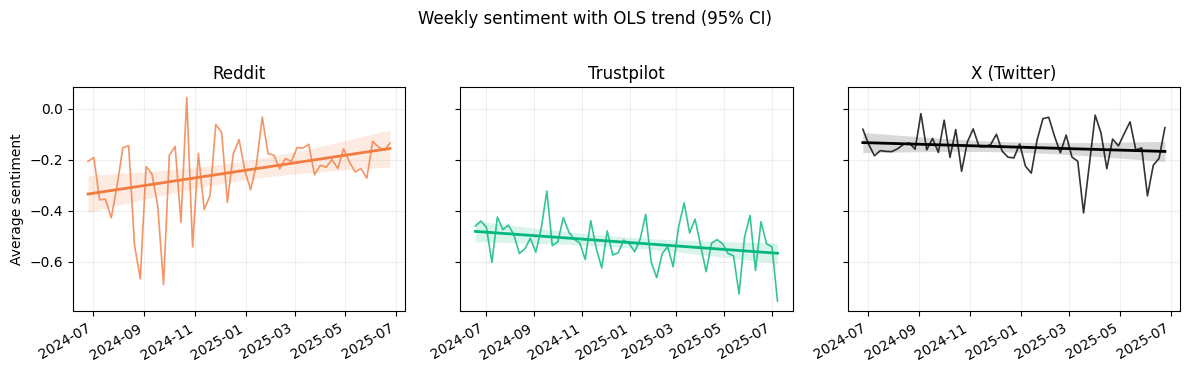

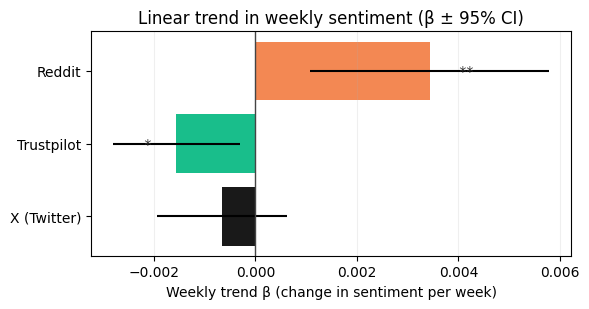

n_weeks  beta_per_week  beta_95lo  beta_95hi    p_beta  \
source                                                                
Reddit            53       0.003433   0.001077   0.005790  0.006202   
Trustpilot        56      -0.001560  -0.002808  -0.000311  0.017602   
X (Twitter)       53      -0.000667  -0.001950   0.000617  0.313584   

             total_change_over_sample    sig  
source                                        
Reddit                       0.181971   True  
Trustpilot                  -0.087345   True  
X (Twitter)                 -0.035331  False

Saved: artifacts/event_only/drift/sentiment_trend_panel.png and artifacts/event_only/drift/sentiment_trend_bars.png


In [ ]:
import statsmodels.api as sm

DRIFT_OUT = Path("artifacts/event_only/drift")
DRIFT_OUT.mkdir(parents=True, exist_ok=True)

COLORS = {"Reddit": "#f27b40", "Trustpilot": "#00b77f", "X (Twitter)": "#000000"}

summ_rows, preds = [], []

for src, g in weekly_sent_platform.groupby("source"):
    g = g.sort_values("week_start").copy()
    g["t"] = np.arange(len(g), dtype=float)
    X = sm.add_constant(g["t"].values)
    y = g["sent_mean"].values
    ols = sm.OLS(y, X).fit()

    pr = ols.get_prediction(X).summary_frame(alpha=0.05)  # 95% CI
    g["fit"] = pr["mean"].values
    g["fit_lo"] = pr["mean_ci_lower"].values
    g["fit_hi"] = pr["mean_ci_upper"].values
    g["_src"] = src
    preds.append(g)

    # weekly slope and CI for bar chart
    beta = float(ols.params[1])
    se = float(ols.bse[1])
    ci_lo, ci_hi = beta - 1.96*se, beta + 1.96*se
    p = float(ols.pvalues[1])

    n = len(g)
    total_change = beta * n

    summ_rows.append({
        "source": src,
        "n_weeks": n,
        "beta_per_week": beta,
        "beta_95lo": ci_lo,
        "beta_95hi": ci_hi,
        "p_beta": p,
        "total_change_over_sample": total_change
    })

preds = pd.concat(preds, ignore_index=True)
drift_bars = pd.DataFrame(summ_rows).set_index("source").loc[["Reddit","Trustpilot","X (Twitter)"]]

fig, axes = plt.subplots(1, 3, figsize=(12, 3.6), sharey=True)
for ax, src in zip(axes, ["Reddit", "Trustpilot", "X (Twitter)"]):
    g = preds[preds["_src"]==src]
    c = COLORS.get(src, "tab:blue")
    ax.plot(g["week_start"], g["sent_mean"], lw=1.2, color=c, alpha=0.8, label="weekly avg")
    ax.fill_between(g["week_start"], g["fit_lo"], g["fit_hi"], color=c, alpha=0.15, linewidth=0)
    ax.plot(g["week_start"], g["fit"], lw=2, color=c, label="OLS trend")
    ax.set_title(src)
    ax.grid(alpha=0.2)
axes[0].set_ylabel("Average sentiment")
fig.autofmt_xdate()
plt.suptitle("Weekly sentiment with OLS trend (95% CI)", y=1.02)
plt.tight_layout()
plt.savefig(DRIFT_OUT/"sentiment_trend_panel.png", dpi=150, bbox_inches="tight")
plt.show()

def star(p):
    return "***" if p<0.001 else ("**" if p<0.01 else ("*" if p<0.05 else ""))

fig, ax = plt.subplots(figsize=(6,3.2))
ypos = np.arange(len(drift_bars))[::-1]
vals = drift_bars["beta_per_week"].values
lo = vals - drift_bars["beta_95lo"].values
hi = drift_bars["beta_95hi"].values - vals
ax.barh(ypos, vals, xerr=[lo,hi], color=[COLORS[k] for k in drift_bars.index], alpha=0.9)
ax.set_yticks(ypos)
ax.set_yticklabels(drift_bars.index)
for i,(v,pval) in enumerate(zip(vals, drift_bars["p_beta"].values)):
    ax.text(v + (0.0005 if v>=0 else -0.0005), ypos[i], f" {star(pval)}", va="center",
            ha="left" if v>=0 else "right", fontsize=10, color="#333")
ax.axvline(0, color="#444", lw=1)
ax.set_xlabel("Weekly trend β (change in sentiment per week)")
ax.set_title("Linear trend in weekly sentiment (β ± 95% CI)")
ax.grid(alpha=0.2, axis="x")
plt.tight_layout()
plt.savefig(DRIFT_OUT/"sentiment_trend_bars.png", dpi=150, bbox_inches="tight")
plt.show()

display(drift_bars.assign(sig=lambda d: d["p_beta"].lt(0.05)))
print("Saved:",
      DRIFT_OUT/"sentiment_trend_panel.png",
      "and",
      DRIFT_OUT/"sentiment_trend_bars.png")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


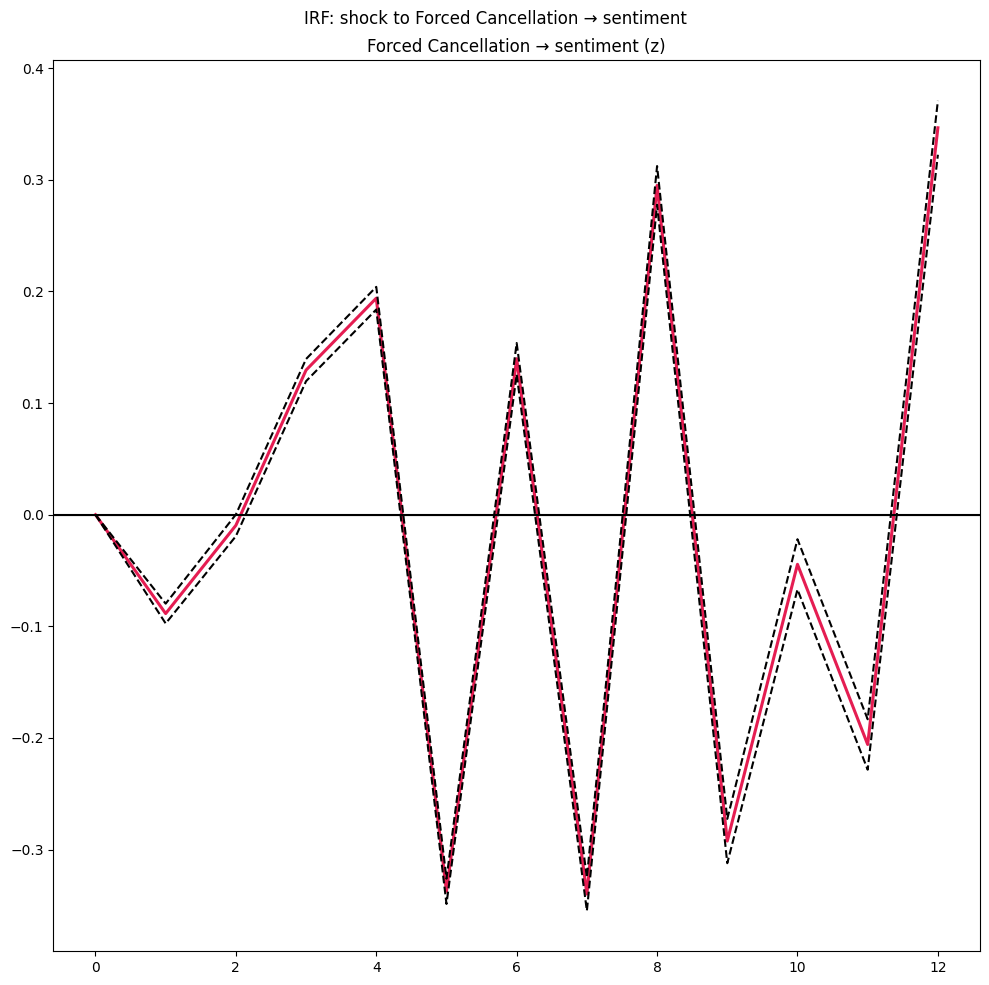

cancellation_overbooking: lags=8, differenced=False, GC cancellation_overbooking→sent p=0.1162, sent→cancellation_overbooking p=0.9535


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


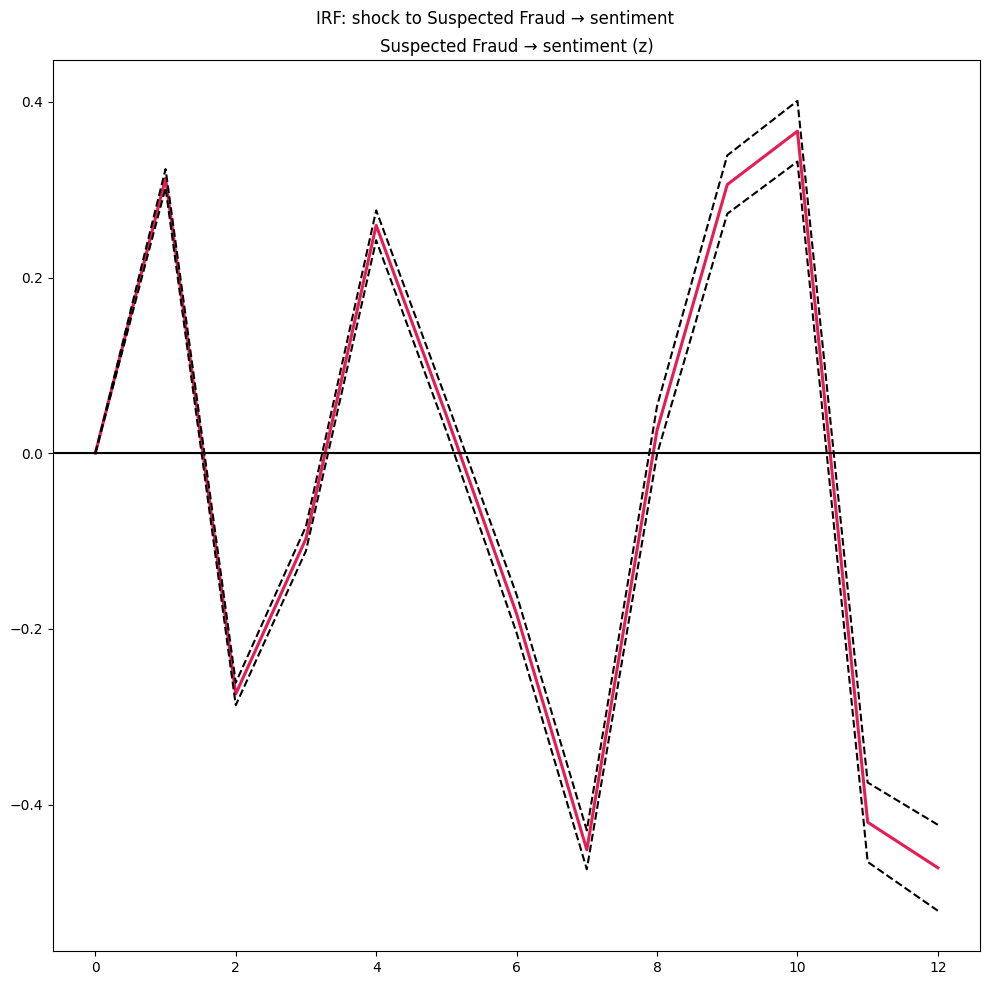

fraud_scams: lags=8, differenced=True, GC fraud_scams→sent p=0.2941, sent→fraud_scams p=0.3180


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


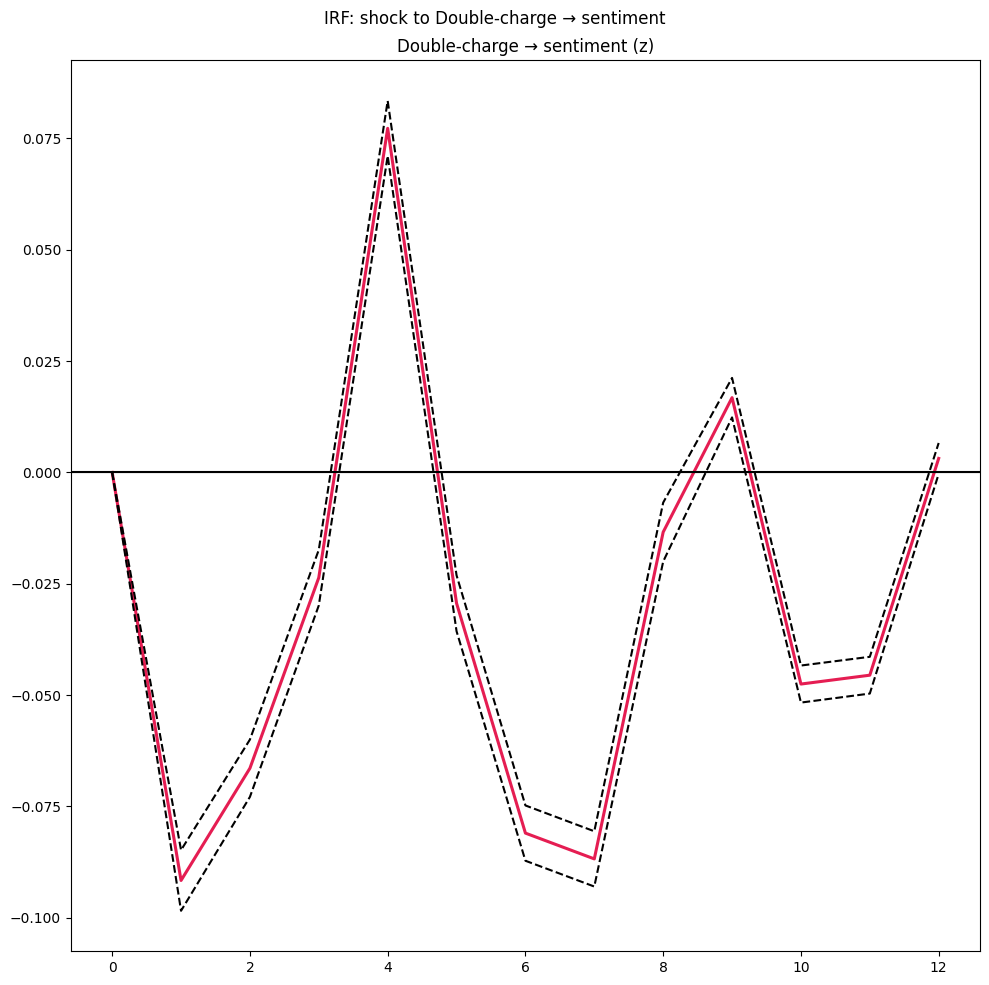

billing_doublecharge: lags=8, differenced=False, GC billing_doublecharge→sent p=0.8377, sent→billing_doublecharge p=0.3842


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


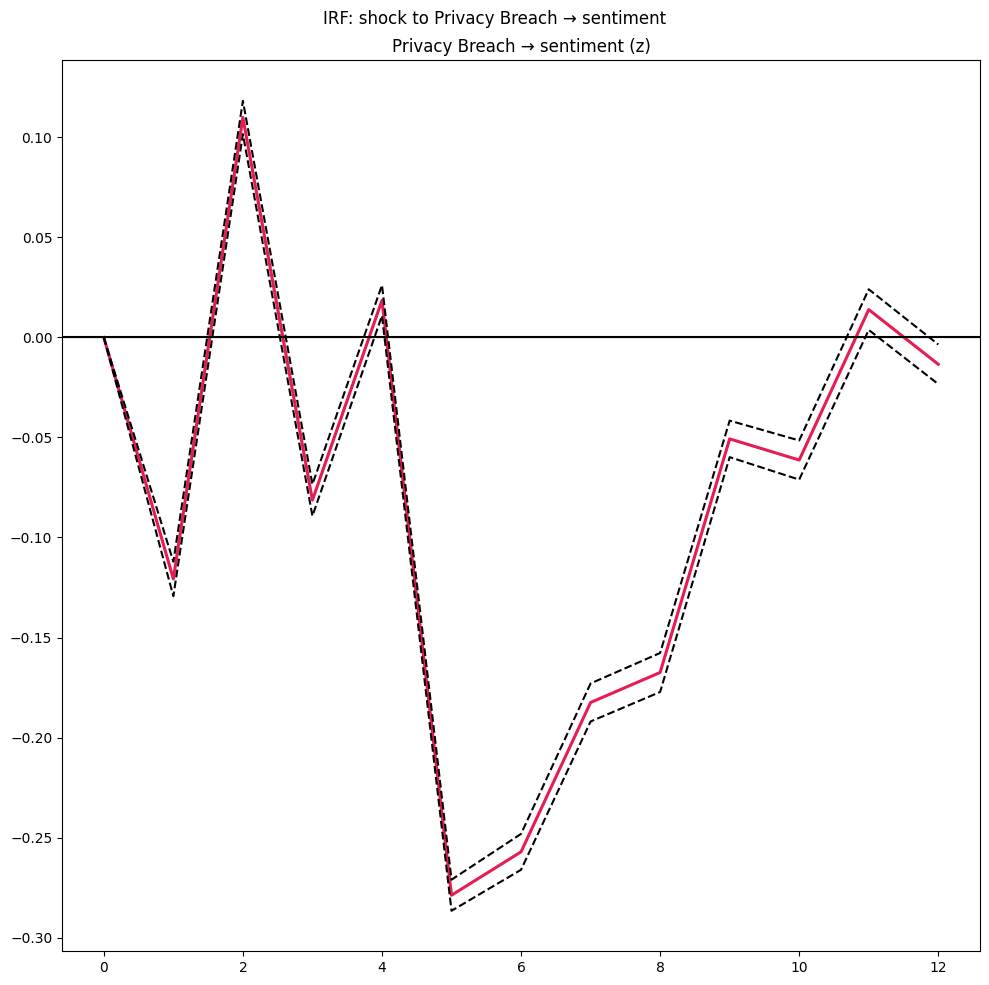

privacy_breach: lags=8, differenced=False, GC privacy_breach→sent p=0.1868, sent→privacy_breach p=0.6929


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


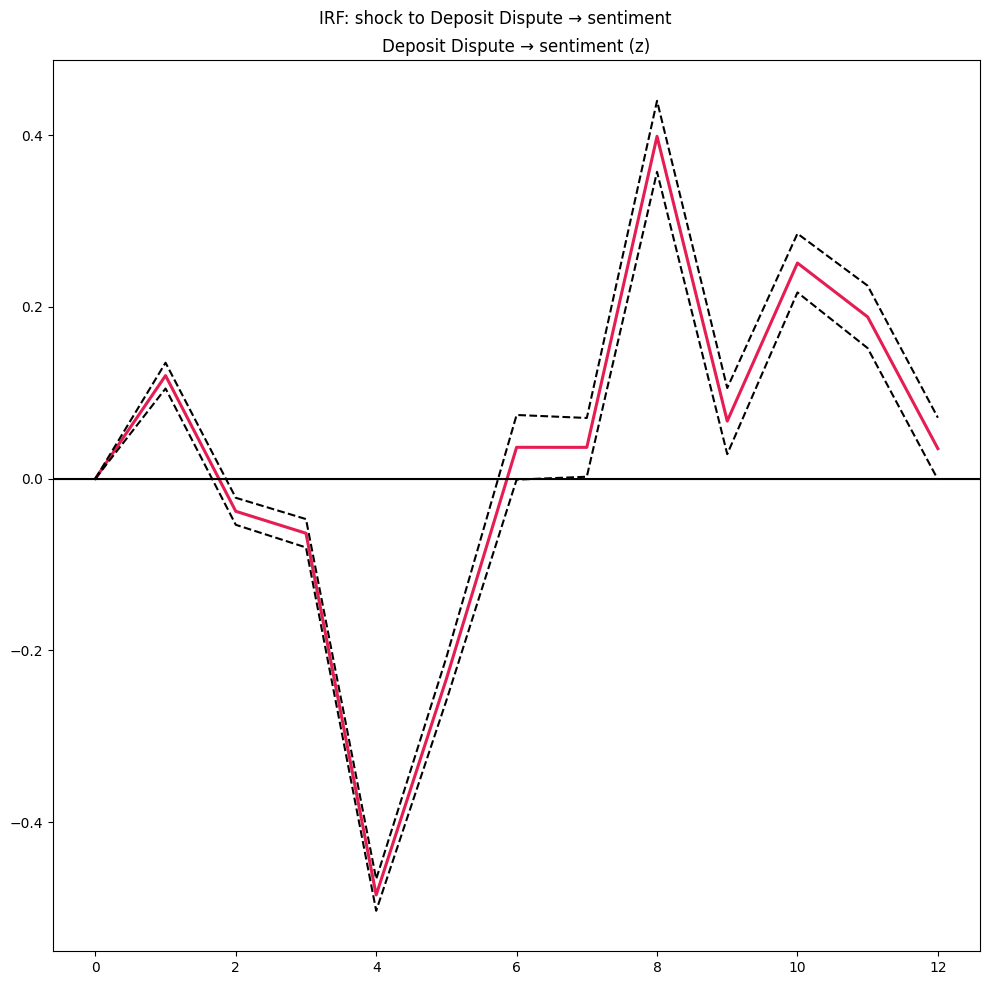

deposit_dispute: lags=8, differenced=False, GC deposit_dispute→sent p=0.4107, sent→deposit_dispute p=0.8596


In [ ]:
COLOR_IRF = "#e51d52"

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

def make_stationary(df_in):
    df = df_in.copy()
    diffed_cols = []
    for c in df.columns:
        s = df[c].dropna()
        if len(s) < 10:
            continue
        try:
            pval = adfuller(s, autolag="AIC")[1]
        except Exception:
            pval = 1.0
        if pval > 0.05:
            df[c] = df[c].diff()
            diffed_cols.append(c)
    diffed = len(diffed_cols) > 0
    return (df.dropna() if diffed else df), diffed

def run_var_for_event(panel, event_col, maxlags=8, horizon=12, ci=0.95):
    """Fit 2-var VAR [sent_z, event] and plot IRF (event → sentiment)."""
    y = panel[["sent_z", event_col]].dropna()
    y_stat, diffed = make_stationary(y)

    if y_stat.shape[0] < maxlags + 5:
        maxlags = max(1, min(4, y_stat.shape[0] // 3))

    try:
        sel = VAR(y_stat).select_order(maxlags=maxlags)
        lag = int(sel.aic or maxlags)
    except Exception:
        lag = min(maxlags, 4)
    lag = max(1, min(lag, maxlags))

    model = VAR(y_stat).fit(lag)
    irf = model.irf(horizon)

    fig = irf.plot(orth=False, impulse=event_col, response="sent_z", signif=ci)

    for ax in fig.axes:
        if ax.lines:
            ax.lines[0].set_color(COLOR_IRF)
            ax.lines[0].set_linewidth(2.2)
        ax.axhline(0, color="k", lw=0.8, alpha=0.7)
        ax.set_title(f"{EVENT_LABEL.get(event_col, event_col)} → sentiment (z)")

    fig.suptitle(f"IRF: shock to {EVENT_LABEL.get(event_col, event_col)} → sentiment", y=0.98)
    plt.tight_layout()
    plt.show()

    # Granger diagnostics (both directions)
    gc_ev_to_sent = model.test_causality(caused="sent_z", causing=[event_col], kind="f").pvalue
    gc_sent_to_ev = model.test_causality(caused=event_col, causing=["sent_z"], kind="f").pvalue
    print(f"{event_col}: lags={lag}, differenced={diffed}, "
          f"GC {event_col}→sent p={gc_ev_to_sent:.4f}, sent→{event_col} p={gc_sent_to_ev:.4f}")

    return {
        "event": event_col,
        "lags": lag,
        "diffed": diffed,
        "gc_event_to_sent_p": gc_ev_to_sent,
        "gc_sent_to_event_p": gc_sent_to_ev,
    }

EVENTS_TO_RUN = SELECTED if "SELECTED" in globals() and SELECTED else KEEP_EVENTS
results = [run_var_for_event(panel, ev) for ev in EVENTS_TO_RUN]

In [ ]:
ART = Path("artifacts")

def find_one(name: str):
    cands = list(ART.rglob(name))
    if cands:
        print(f"✓ Found {name} at:", cands[0])
        return cands[0]
    print(f"✗ Not found: {name}")
    return None

p_weekly = find_one("weekly_ev_from_topics_no_cleanliness.parquet") \
        or find_one("weekly_ev_from_topics.parquet")
if p_weekly is None:
    raise FileNotFoundError("Couldn't locate weekly event panel under artifacts/.")

weekly_ev = pd.read_parquet(p_weekly)

p_docs_parq = find_one("docs_with_topics_events.parquet")
if p_docs_parq is not None:
    docs = pd.read_parquet(p_docs_parq)
else:
    p_csv = find_one("combined_sentiment_data.csv") \
         or Path("combined_sentiment_data.csv")
    if not p_csv.exists():
        raise FileNotFoundError("Couldn't find docs parquet or combined_sentiment_data.csv")
    print("→ Falling back to CSV:", p_csv)
    docs = pd.read_csv(p_csv, low_memory=False)

docs["date"] = pd.to_datetime(docs["date"], errors="coerce")
docs = docs.dropna(subset=["date"]).copy()
docs["week_start"] = docs["date"].dt.to_period("W-MON").apply(lambda r: r.start_time).dt.normalize()

if "soft_sent" not in docs.columns:
    sign_map = {"label_0": -1, "Negative": -1, "label_1": 0, "Neutral": 0,
                "label_2": 1, "Positive": 1}
    docs["sign"] = docs["sentiment_label"].map(sign_map)
    docs["sentiment_score"] = pd.to_numeric(docs["sentiment_score"], errors="coerce")
    docs["soft_sent"] = docs["sign"] * docs["sentiment_score"]

print("Loaded shapes -> weekly_ev:", weekly_ev.shape, "| docs:", docs.shape)

✓ Found weekly_ev_from_topics_no_cleanliness.parquet at: artifacts/event_only/weekly_ev_from_topics_no_cleanliness.parquet
✓ Found docs_with_topics_events.parquet at: artifacts/docs_with_topics_events.parquet
Loaded shapes -> weekly_ev: (230, 4) | docs: (59539, 30)


Platforms found: ['Reddit', 'Trustpilot', 'X (Twitter)']
Weeks in event panel: 2024-06-18 → 2025-07-08
[Reddit] n=53 | selected_lags=6 | AIC=-45.761 | sample: 2024-06-25 → 2025-06-24


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


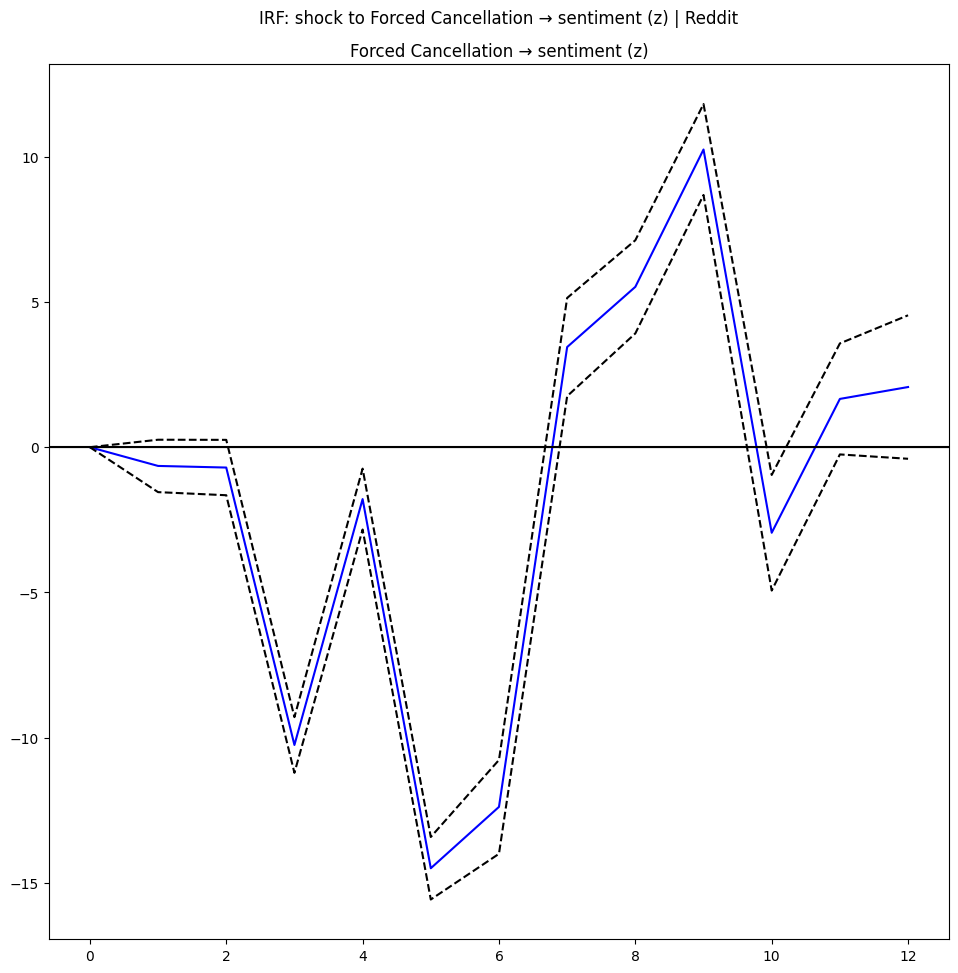

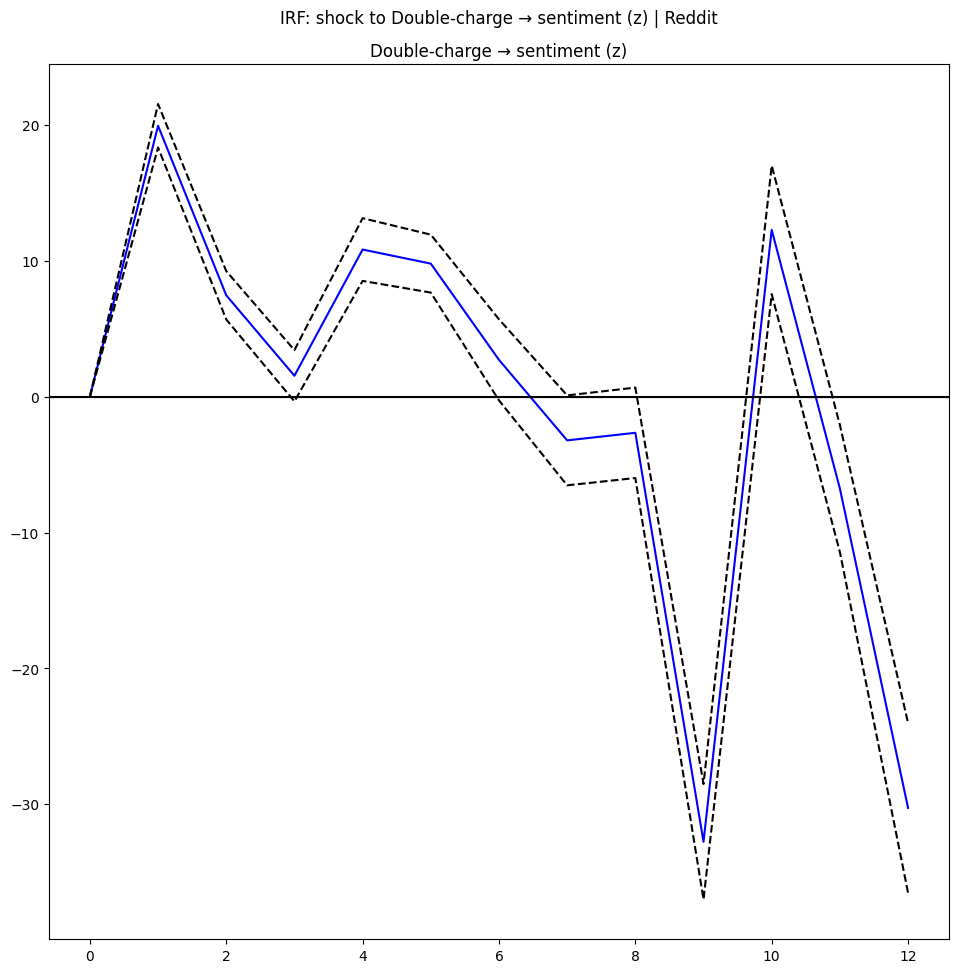

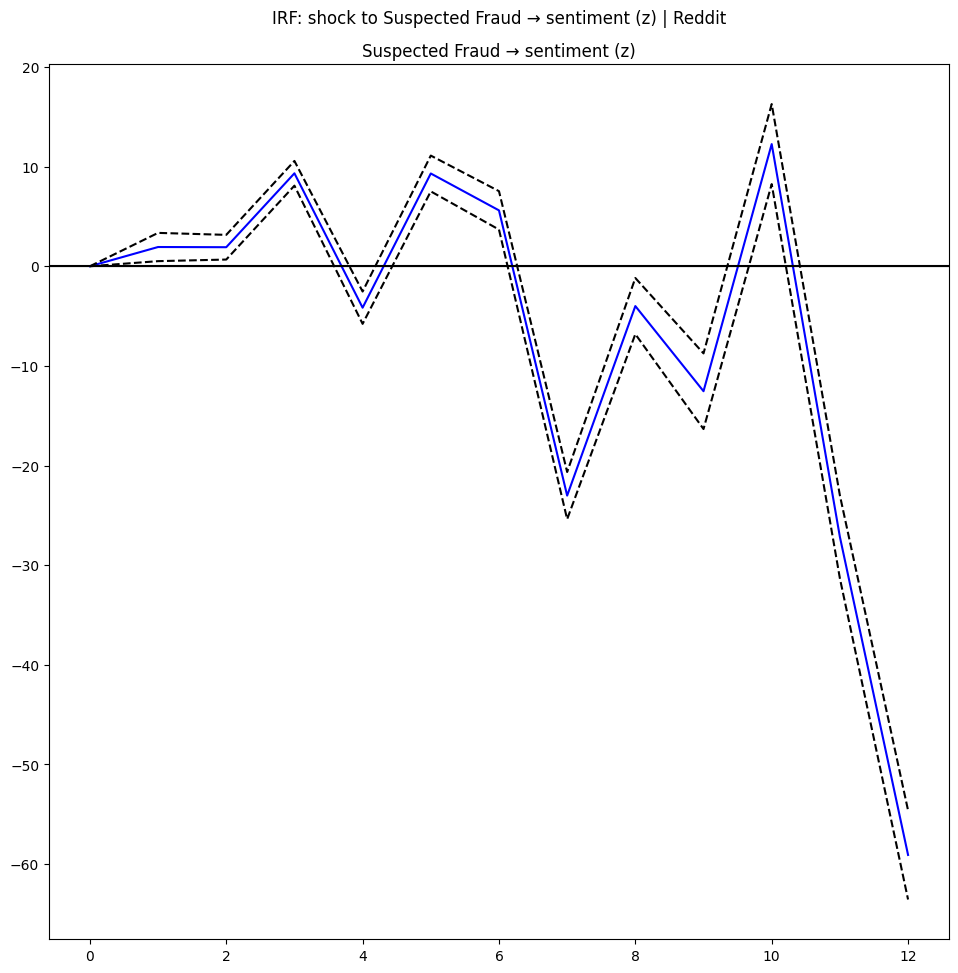

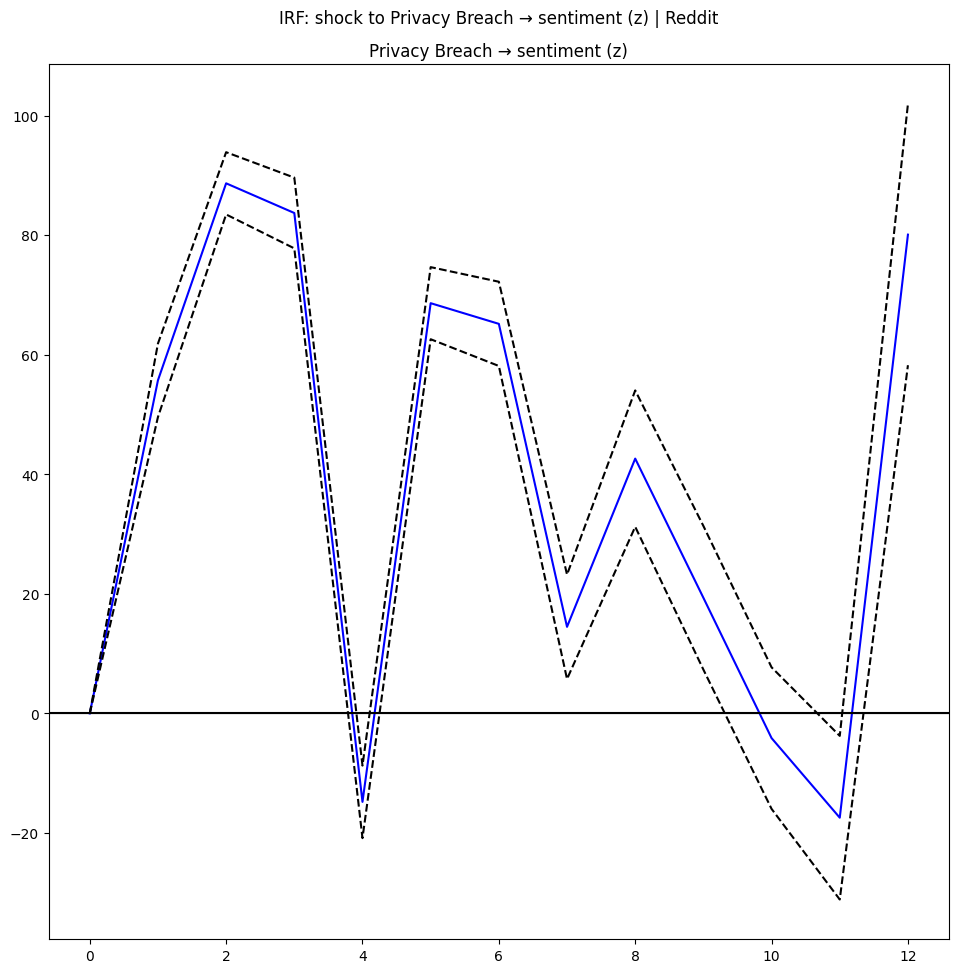

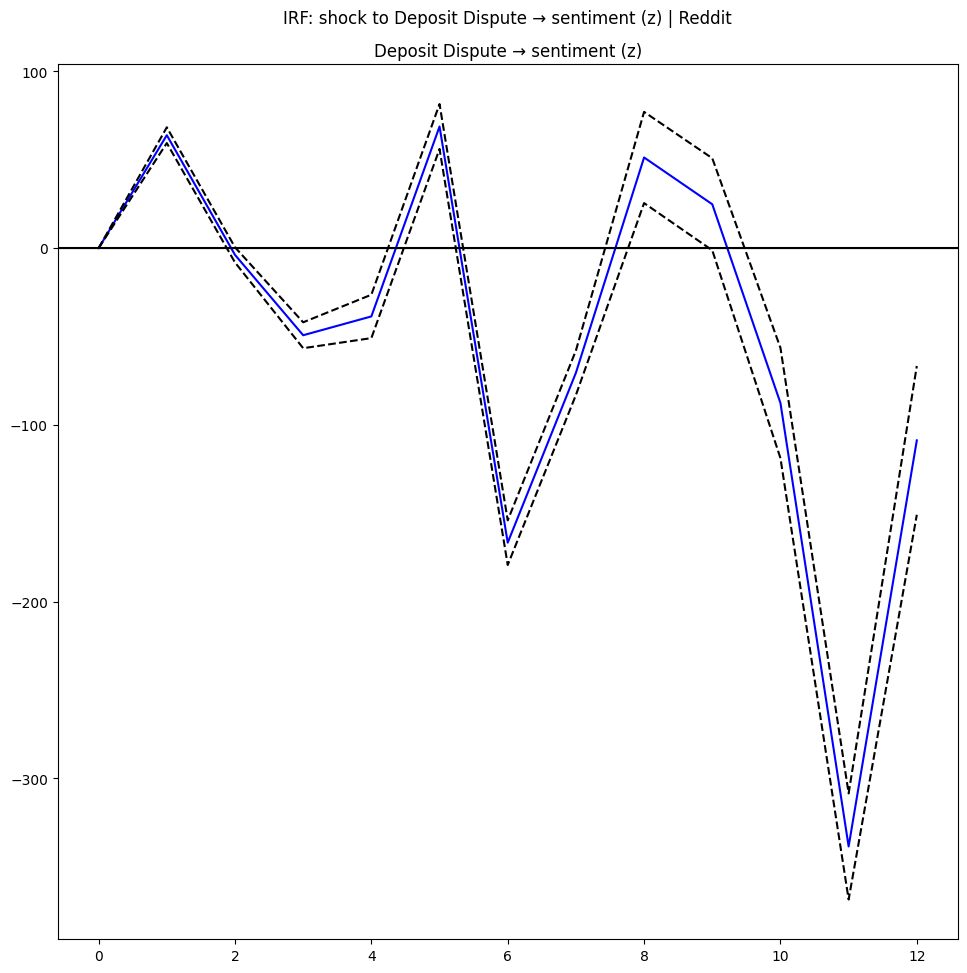

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


[Trustpilot] n=56 | selected_lags=7 | AIC=-52.817 | sample: 2024-06-18 → 2025-07-08


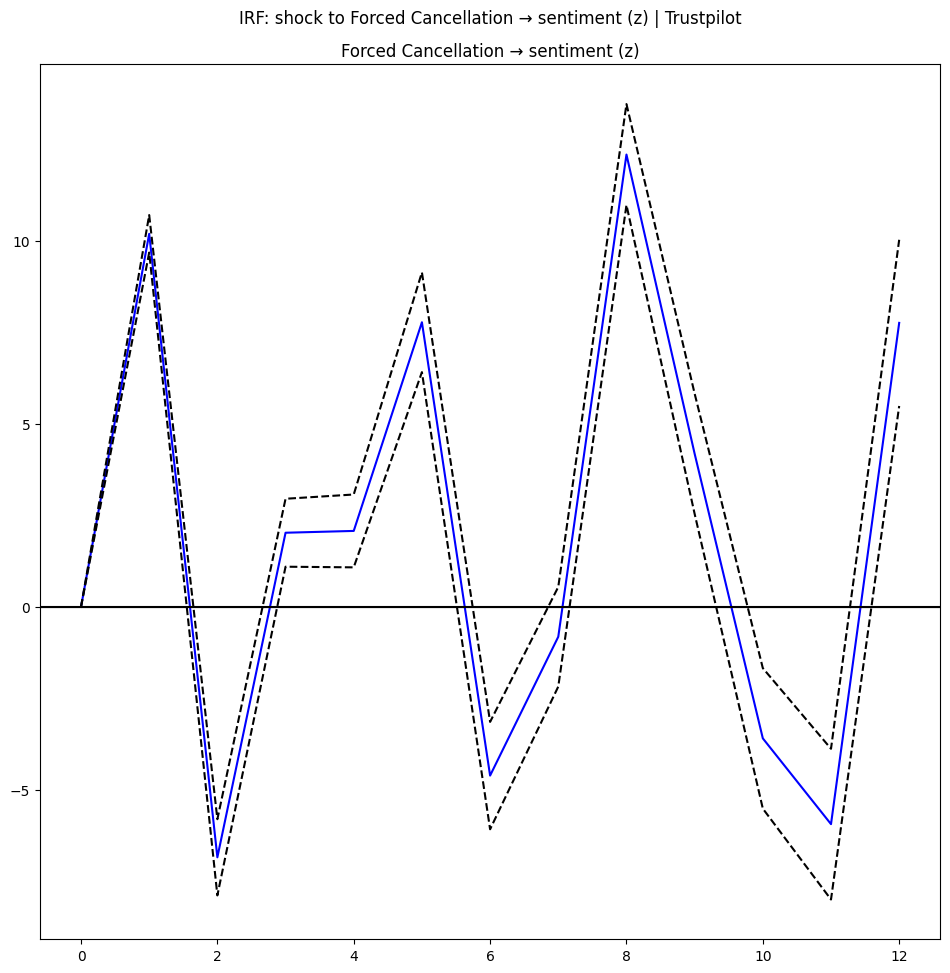

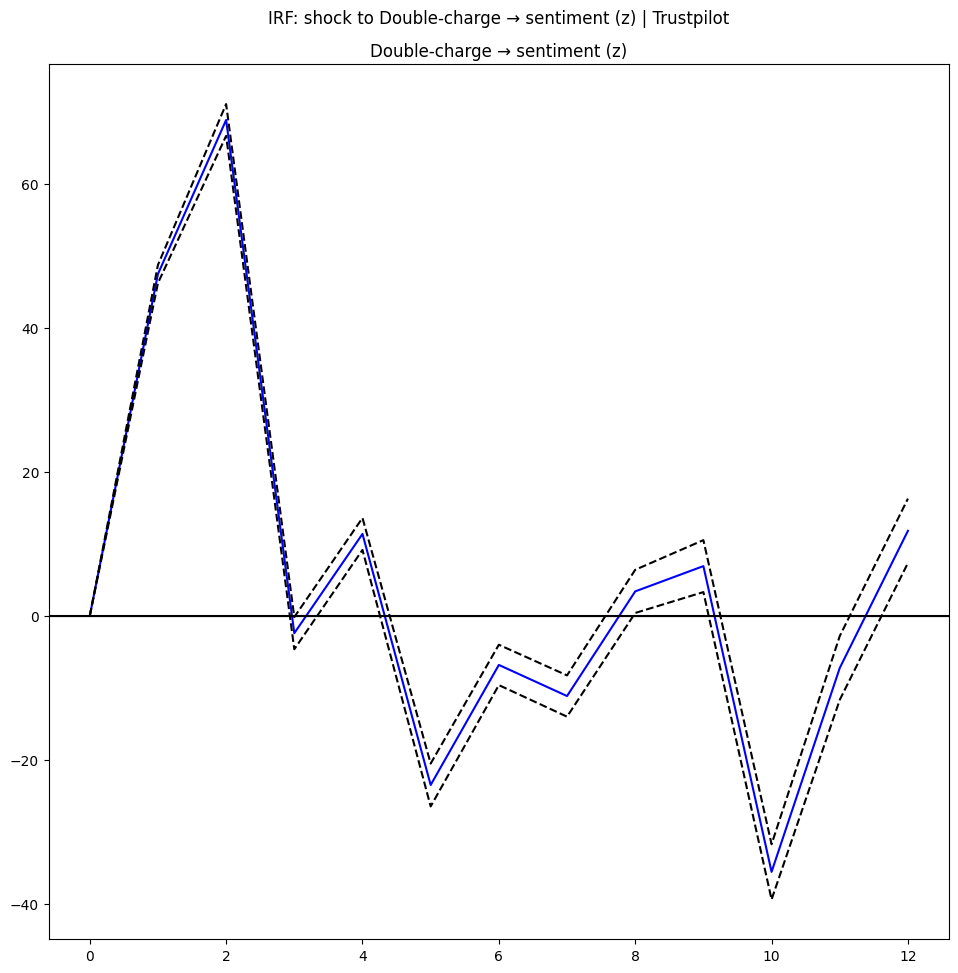

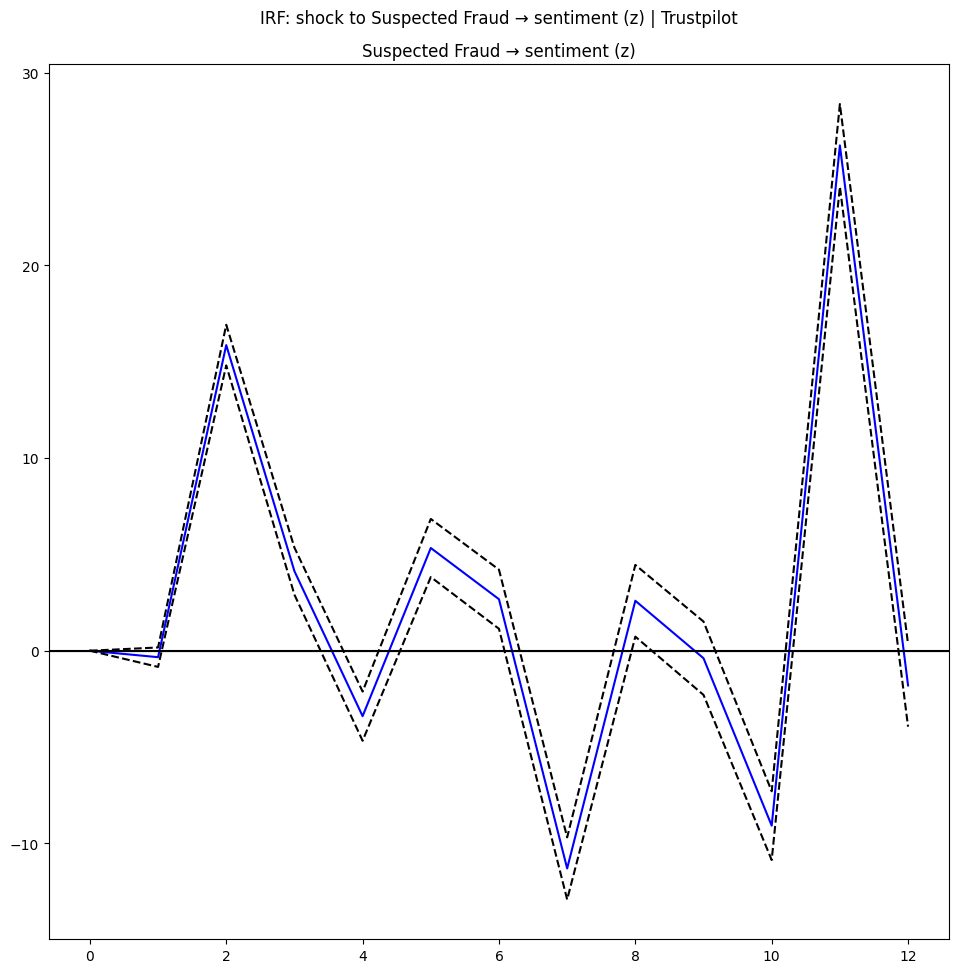

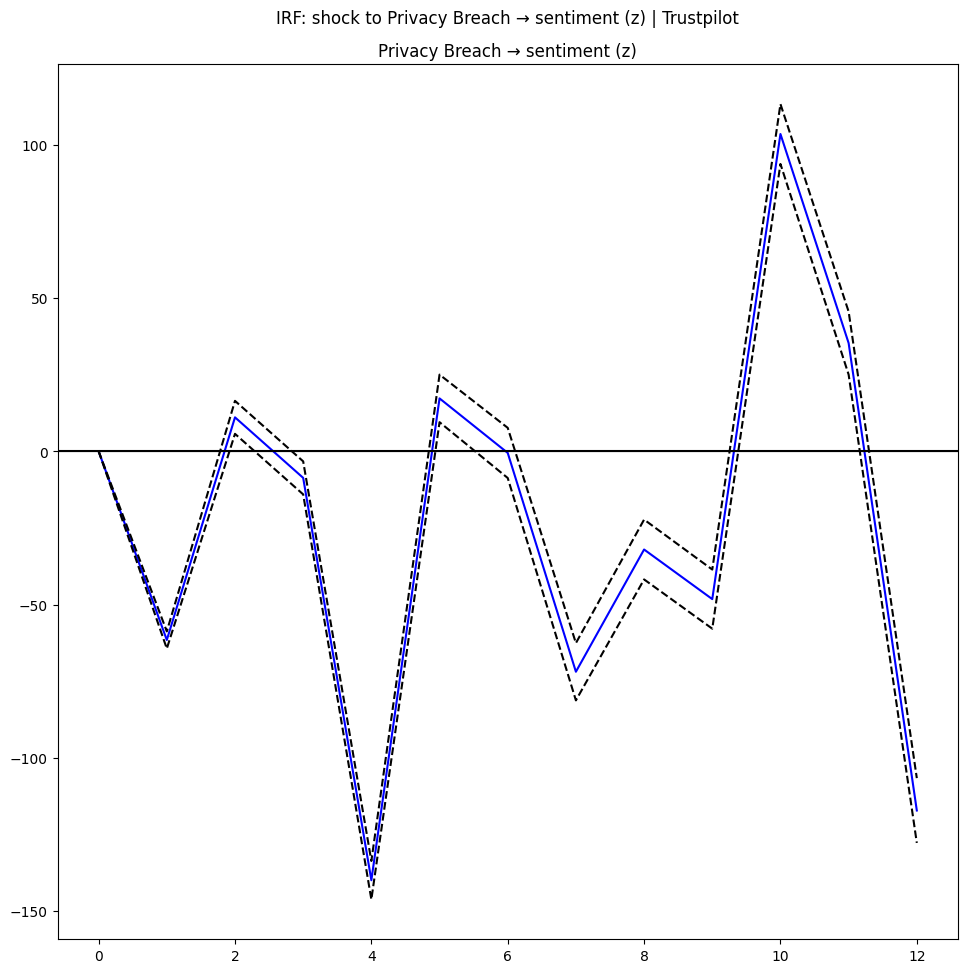

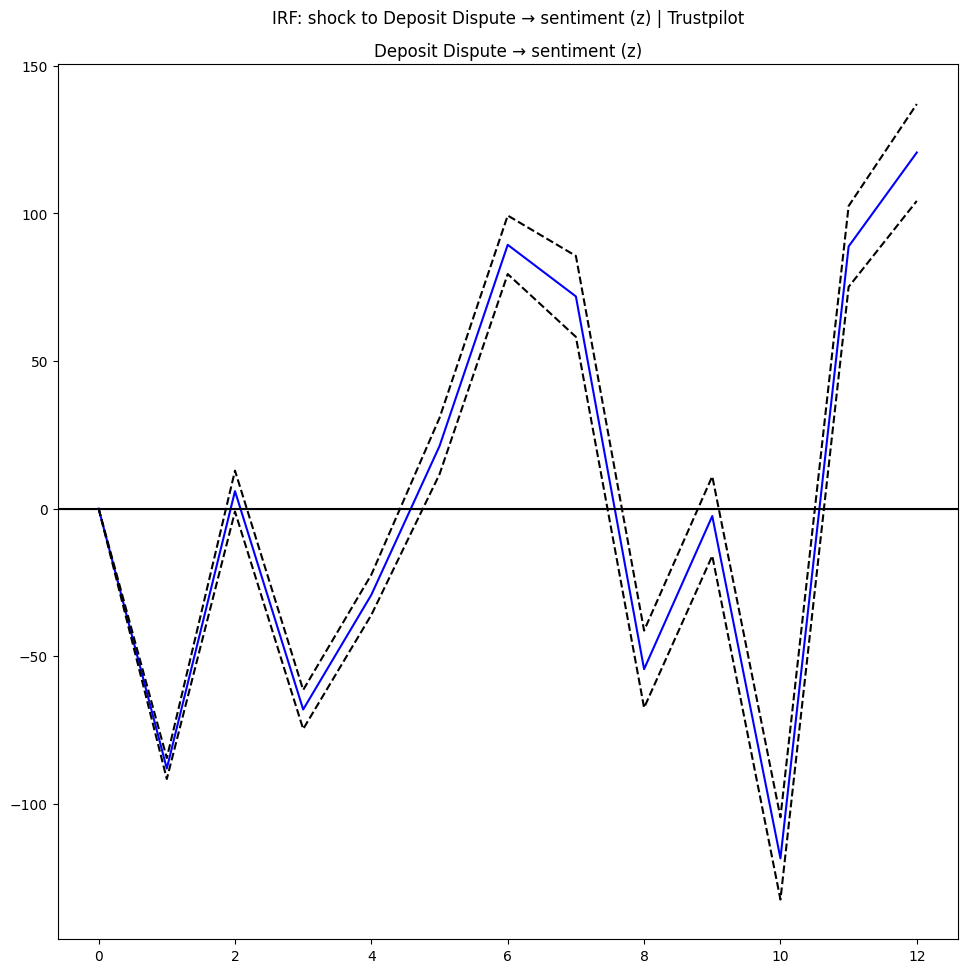

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


[X (Twitter)] n=53 | selected_lags=6 | AIC=-46.212 | sample: 2024-06-25 → 2025-06-24


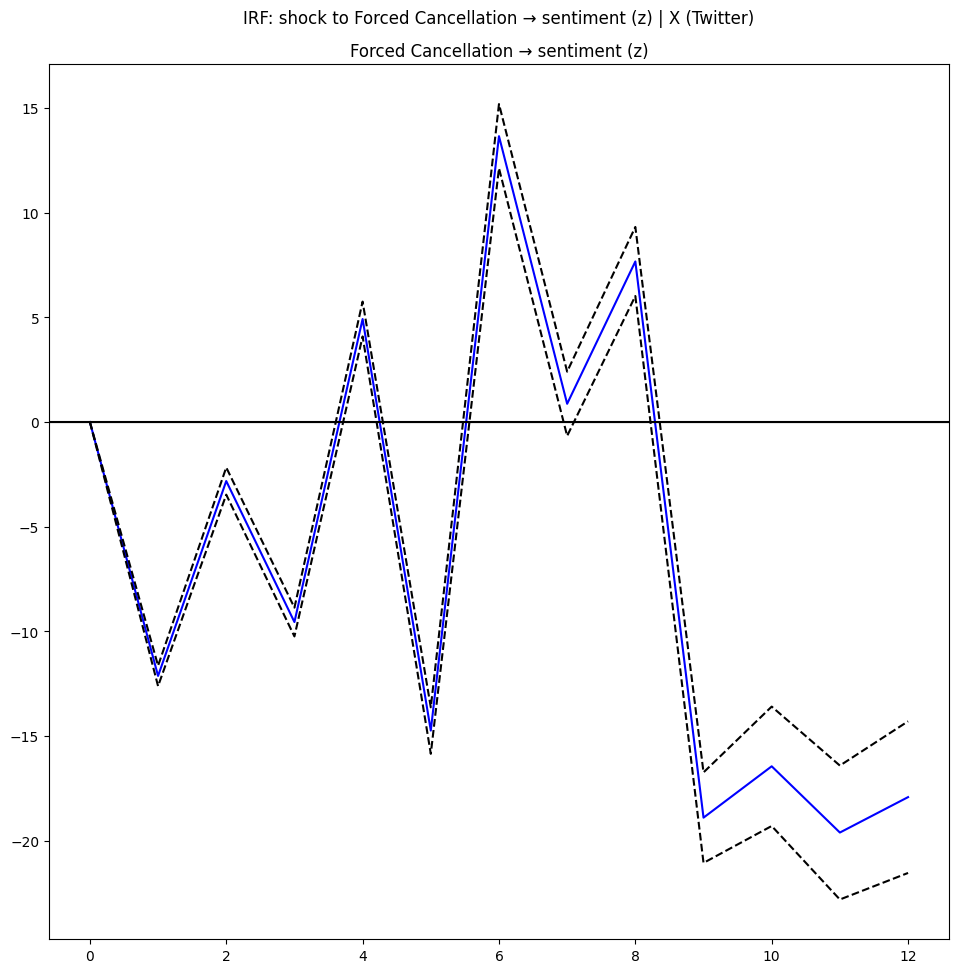

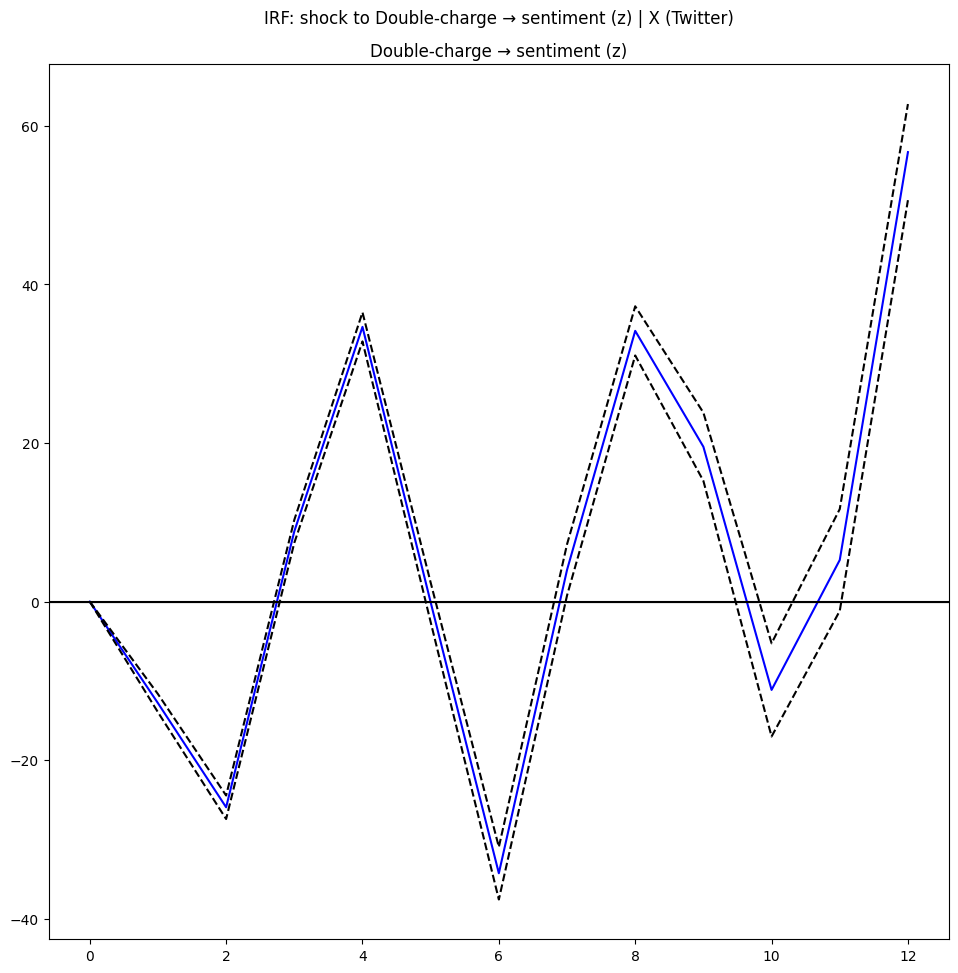

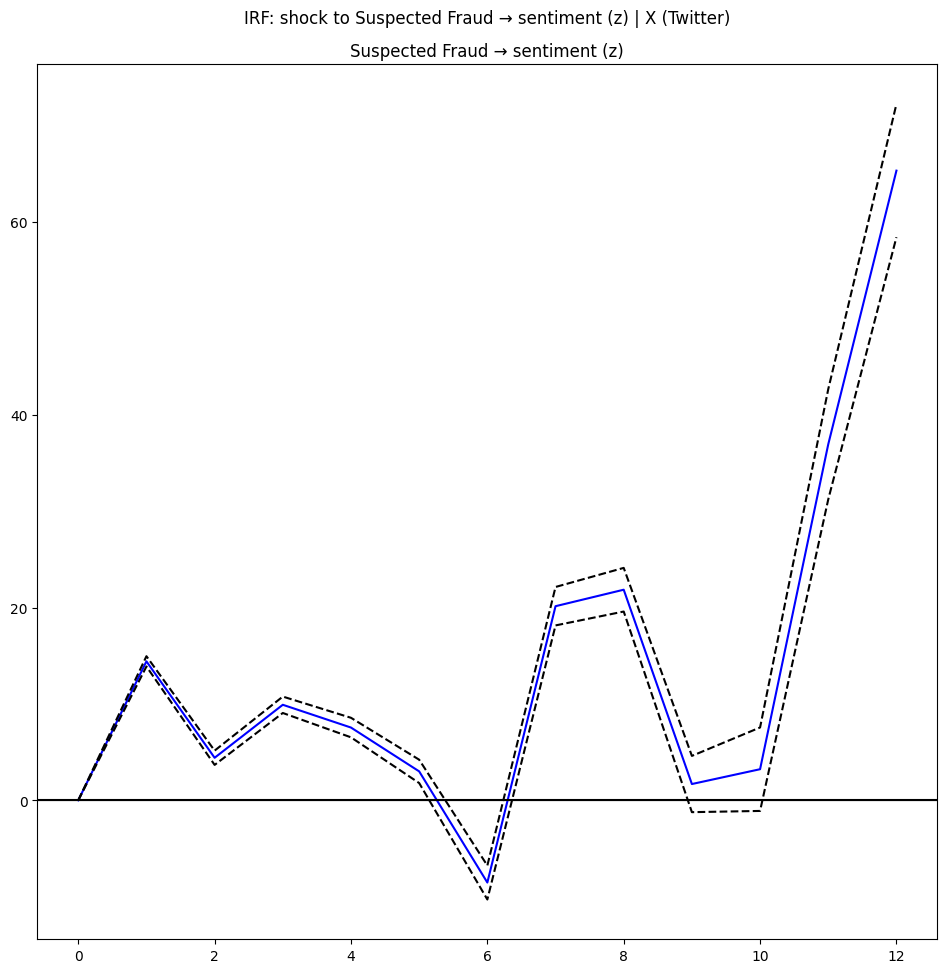

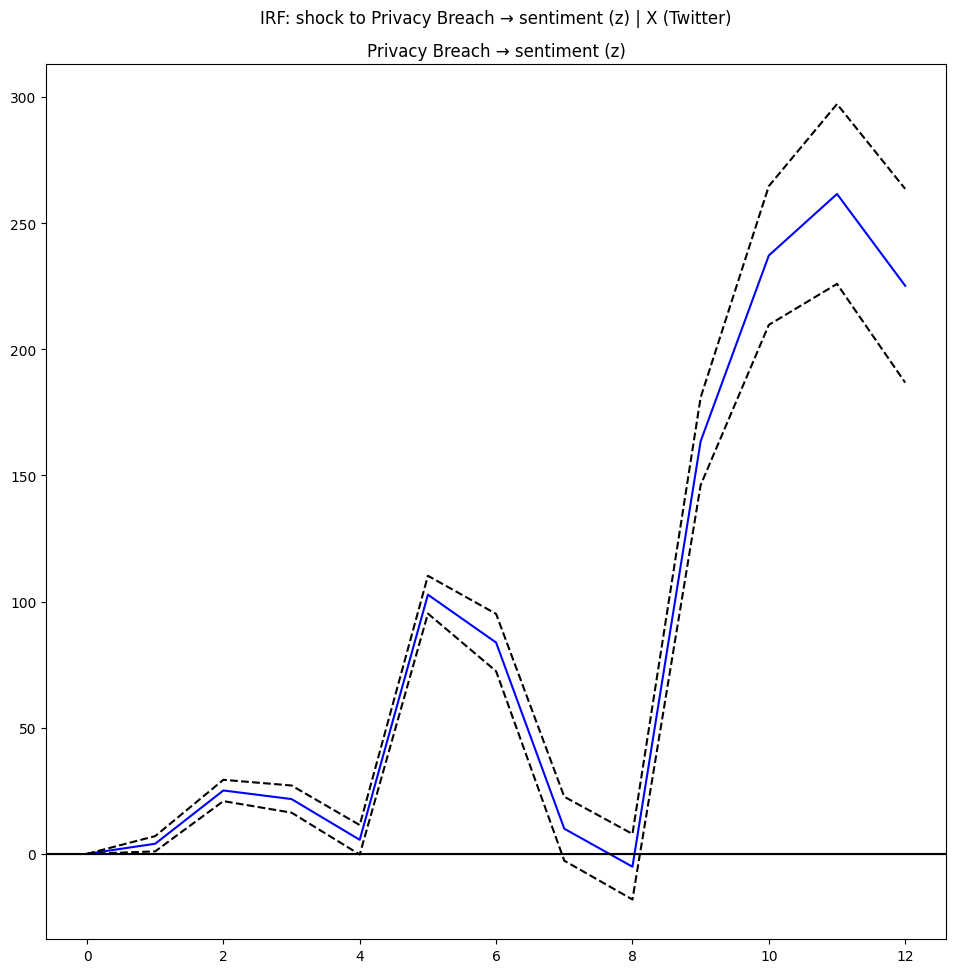

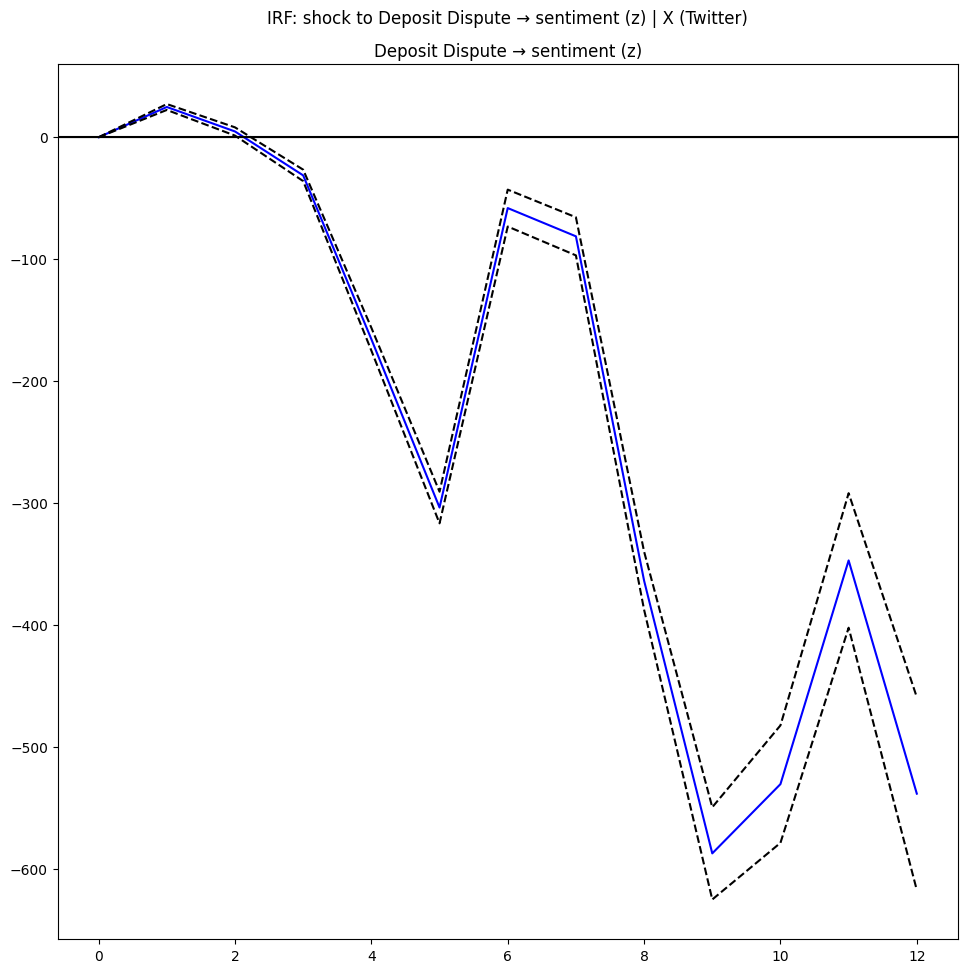

Saved: artifacts/event_only/irf_platform/var_platform_summary.csv


In [ ]:
OUT_IRF = Path("artifacts/event_only/irf_platform")
OUT_IRF.mkdir(parents=True, exist_ok=True)

KEEP_EVENTS = [
    "cancellation_overbooking",
    "billing_doublecharge",
    "fraud_scams",
    "privacy_breach",
    "deposit_dispute",
]

EVENT_LABEL = {
    "cancellation_overbooking": "Forced Cancellation",
    "billing_doublecharge":     "Double-charge",
    "fraud_scams":              "Suspected Fraud",
    "privacy_breach":           "Privacy Breach",
    "deposit_dispute":          "Deposit Dispute",
}

def monday_start_index(idx):
    if isinstance(idx, pd.PeriodIndex):
        return idx.asfreq("W-MON").to_timestamp(how="start").normalize()
    dt = pd.to_datetime(idx, errors="coerce")
    return dt.to_period("W-MON").to_timestamp(how="start").normalize()


# Prepare weekly series
docs["source"] = docs["source"].replace({"Twitter": "X (Twitter)"})

if "week_start" not in docs.columns:
    docs["date"] = pd.to_datetime(docs["date"], errors="coerce")
    docs = docs.dropna(subset=["date"]).copy()
    docs["week_start"] = docs["date"].dt.to_period("W-MON").apply(lambda r: r.start_time).dt.normalize()

weekly_sent_platform = (
    docs.groupby(["source", "week_start"])
        .agg(sent_mean=("soft_sent", "mean"),
             posts=("soft_sent", "size"))
        .reset_index()
)

ev_wide = (
    weekly_ev[weekly_ev["event_type"].isin(KEEP_EVENTS)]
    .pivot_table(index="week_start", columns="event_type",
                 values="n_posts", aggfunc="sum")
    .sort_index()
    .fillna(0.0)
)

ev_wide.index = monday_start_index(ev_wide.index)

tot_posts_week = docs.groupby("week_start")["soft_sent"].size().rename("all_posts")
ev_wide = ev_wide.join(tot_posts_week, how="left").fillna(0.0)
for ev in KEEP_EVENTS:
    ev_wide[ev] = ev_wide[ev] / ev_wide["all_posts"].replace(0, np.nan)
ev_wide = ev_wide.drop(columns=["all_posts"]).fillna(0.0)

print("Platforms found:", sorted(weekly_sent_platform["source"].unique()))
print("Weeks in event panel:", ev_wide.index.min().date(), "→", ev_wide.index.max().date())


# VAR per platform + IRFs
def run_var_one_platform(src, maxlags=8, horizon=12, ci=0.95):
    g = weekly_sent_platform[weekly_sent_platform["source"] == src].copy()
    if g.empty:
        print(f"[{src}] No rows.")
        return None

    df = (
        g.set_index("week_start")[["sent_mean"]]
         .sort_index()
         .join(ev_wide, how="left")
         .fillna(0.0)
    )

    mu, sd = df["sent_mean"].mean(), df["sent_mean"].std(ddof=0)
    df["sent_z"] = (df["sent_mean"] - mu) / (sd + 1e-9)
    df = df.drop(columns=["sent_mean"])

    nobs = df.shape[0]
    if nobs < 15:
        print(f"[{src}] Not enough weeks ({nobs}). Skipping.")
        return None

    mlag = min(maxlags, max(1, nobs // 4))
    fitted = None
    while mlag >= 1 and fitted is None:
        try:
            fitted = VAR(df[KEEP_EVENTS + ["sent_z"]]).fit(maxlags=mlag, ic="aic")
        except ValueError:
            mlag -= 1
    if fitted is None:
        print(f"[{src}] Could not fit VAR with any lags. Skipping.")
        return None

    print(f"[{src}] n={nobs} | selected_lags={fitted.k_ar} | AIC={fitted.aic:.3f} "
          f"| sample: {df.index.min().date()} → {df.index.max().date()}")

    irf = fitted.irf(horizon)

    out_meta = {"source": src, "lags": fitted.k_ar, "aic": fitted.aic,
                "n_obs": nobs, "start": df.index.min(), "end": df.index.max()}

    for ev in KEEP_EVENTS:
        label = EVENT_LABEL.get(ev, ev)
        fig = irf.plot(orth=False, impulse=ev, response="sent_z", signif=ci)

        for ax in fig.axes:
            ax.set_title(f"{label} → sentiment (z)")
            ax.axhline(0, color="k", lw=0.8)

        fig.suptitle(f"IRF: shock to {label} → sentiment (z) | {src}", y=0.98)

        slug = re.sub(r"[^A-Za-z0-9]+", "_", label).strip("_").lower()
        png_path = OUT_IRF / f"irf_{src.replace(' ','_').replace('/','-')}__{slug}.png"
        fig.savefig(png_path, dpi=150, bbox_inches="tight")
        plt.show()

    return out_meta

summary = []
for src in sorted(weekly_sent_platform["source"].unique()):
    info = run_var_one_platform(src, maxlags=8, horizon=12, ci=0.95)
    if info:
        summary.append(info)

if summary:
    pd.DataFrame(summary).to_csv(OUT_IRF / "var_platform_summary.csv", index=False)
    print("Saved:", OUT_IRF / "var_platform_summary.csv")
else:
    print("No platform produced a VAR summary (likely too few weeks).")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


[Reddit] n=53 | selected_lags=6 | AIC=-45.761 | sample: 2024-06-25 → 2025-06-24


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


[Trustpilot] n=56 | selected_lags=7 | AIC=-52.817 | sample: 2024-06-18 → 2025-07-08


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


[X (Twitter)] n=53 | selected_lags=6 | AIC=-46.212 | sample: 2024-06-25 → 2025-06-24


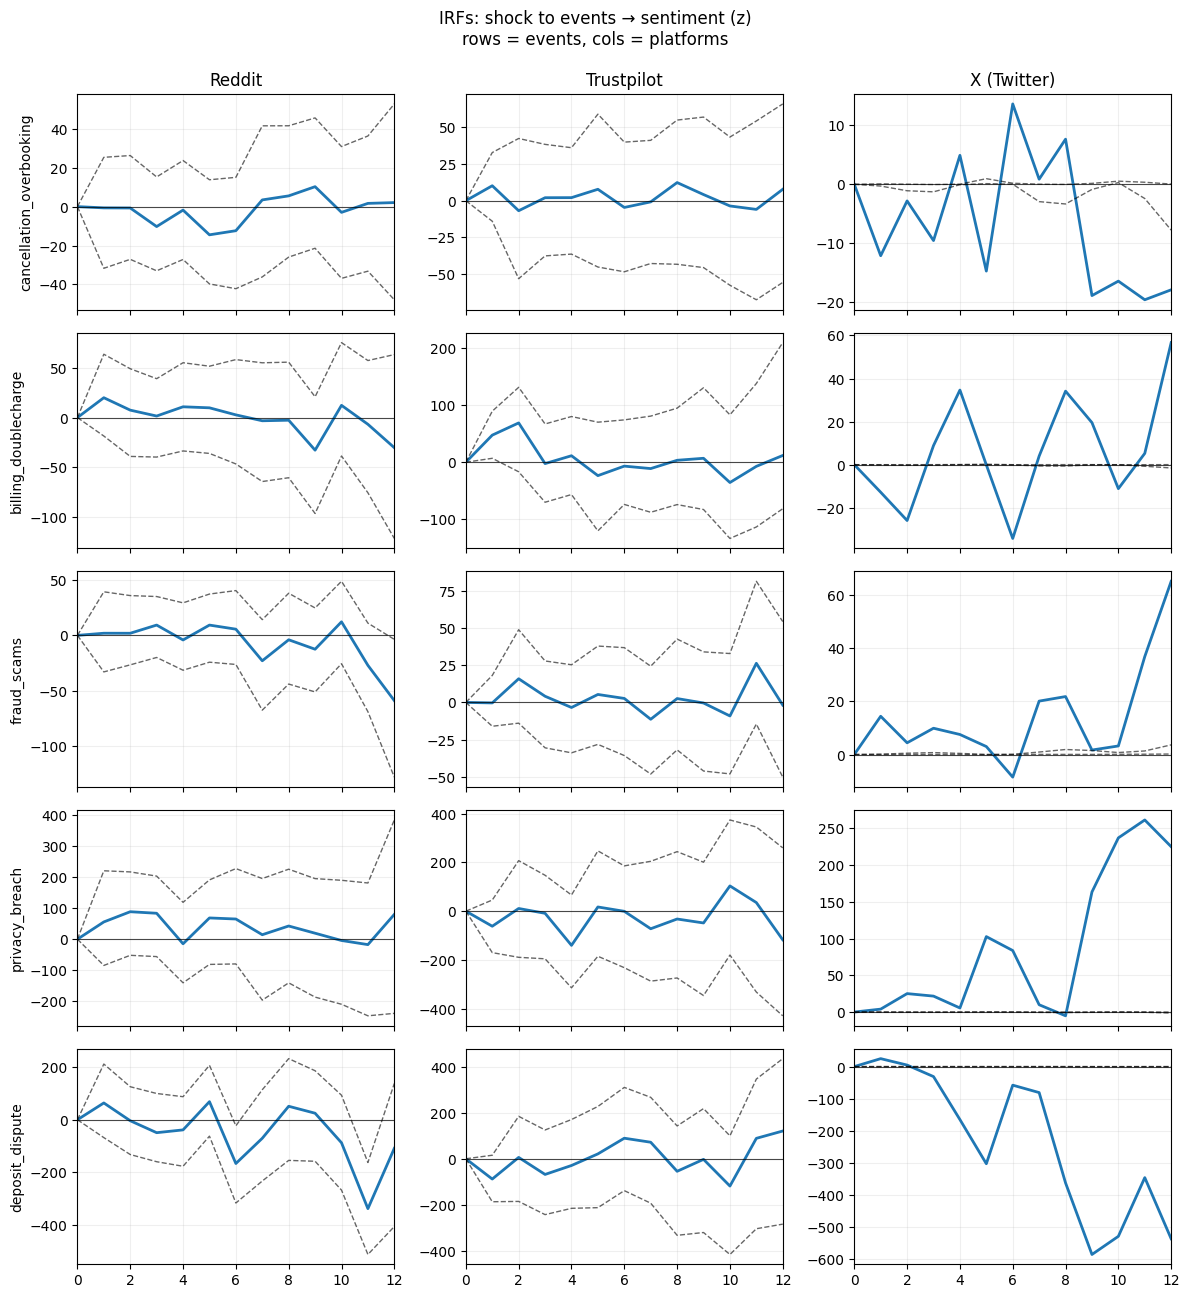

Saved: artifacts/event_only/irf_platform/irf_grid_events_by_platform.png
Saved: artifacts/event_only/irf_platform/var_platform_summary.csv


In [ ]:
def fit_var_and_get_irf(src, horizon=12, maxlags=8, ci=0.95):
    """Fit a VAR for a single platform and return IRF arrays we can plot on custom subplots."""
    g = weekly_sent_platform[weekly_sent_platform["source"] == src].copy()
    if g.empty:
        return None

    df = (
        g.set_index("week_start")[["sent_mean"]]
         .sort_index()
         .join(ev_wide, how="left")
         .fillna(0.0)
    )

    # z-score sentiment
    mu, sd = df["sent_mean"].mean(), df["sent_mean"].std(ddof=0)
    df["sent_z"] = (df["sent_mean"] - mu) / (sd + 1e-9)
    df = df.drop(columns=["sent_mean"])

    nobs = df.shape[0]
    if nobs < 15:
        print(f"[{src}] Not enough weeks ({nobs}). Skipping.")
        return None

    mlag = min(maxlags, max(1, nobs // 4))
    res = None
    while mlag >= 1 and res is None:
        try:
            res = VAR(df[KEEP_EVENTS + ["sent_z"]]).fit(maxlags=mlag, ic="aic")
        except ValueError:
            mlag -= 1
    if res is None:
        print(f"[{src}] Could not fit VAR with any lags. Skipping.")
        return None

    print(f"[{src}] n={nobs} | selected_lags={res.k_ar} | AIC={res.aic:.3f} "
          f"| sample: {df.index.min().date()} → {df.index.max().date()}")

    irf   = res.irf(horizon)
    steps = np.arange(horizon + 1)

    names   = list(res.names)
    ix_sent = names.index("sent_z")

    low_all = high_all = None
    try:
        low_all, high_all = irf.errband_mc(orth=False, repl=1000, signif=(1-ci))
    except Exception:
        pass

    series = {}
    for ev in KEEP_EVENTS:
        ix_ev = names.index(ev)
        mean  = irf.irfs[:, ix_sent, ix_ev]
        if low_all is not None:
            low  = low_all[:, ix_sent, ix_ev]
            high = high_all[:, ix_sent, ix_ev]
        else:
            low = high = None
        series[ev] = {"mean": mean, "low": low, "high": high}

    return {
        "source": src,
        "lags": res.k_ar,
        "aic": res.aic,
        "n_obs": nobs,
        "start": df.index.min(),
        "end": df.index.max(),
        "steps": steps,
        "series": series,
    }

results = []
for src in sorted(weekly_sent_platform["source"].unique()):
    r = fit_var_and_get_irf(src, horizon=12, maxlags=8, ci=0.95)
    if r is not None:
        results.append(r)

if not results:
    print("No platform had enough data to estimate a VAR.")
else:
    nR, nC = len(KEEP_EVENTS), len(results)
    fig, axes = plt.subplots(nR, nC, figsize=(4.0*nC, 2.6*nR), sharex=True, sharey=False)
    if nR == 1 and nC == 1:
        axes = np.array([[axes]])
    elif nR == 1:
        axes = axes[np.newaxis, :]
    elif nC == 1:
        axes = axes[:, np.newaxis]

    for c, res in enumerate(results):
        steps = res["steps"]
        for r, ev in enumerate(KEEP_EVENTS):
            ax = axes[r, c]
            s  = res["series"][ev]
            ax.plot(steps, s["mean"], lw=2)
            if s["low"] is not None:
                ax.plot(steps, s["low"],  ls="--", lw=1, color="k", alpha=0.6)
                ax.plot(steps, s["high"], ls="--", lw=1, color="k", alpha=0.6)
            ax.axhline(0, color="k", lw=0.8, alpha=0.7)
            if r == 0:
                ax.set_title(res["source"])
            if c == 0:
                ax.set_ylabel(ev)
            ax.set_xlim(0, steps[-1])
            ax.grid(alpha=0.2)

    fig.suptitle("IRFs: shock to events → sentiment (z)\nrows = events, cols = platforms", y=0.995)
    fig.tight_layout()
    out_path = OUT_IRF / "irf_grid_events_by_platform.png"
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)

    (pd.DataFrame([{k: v for k, v in r.items() if k not in ("steps", "series")} for r in results])
       .to_csv(OUT_IRF / "var_platform_summary.csv", index=False))
    print("Saved:", OUT_IRF / "var_platform_summary.csv")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  

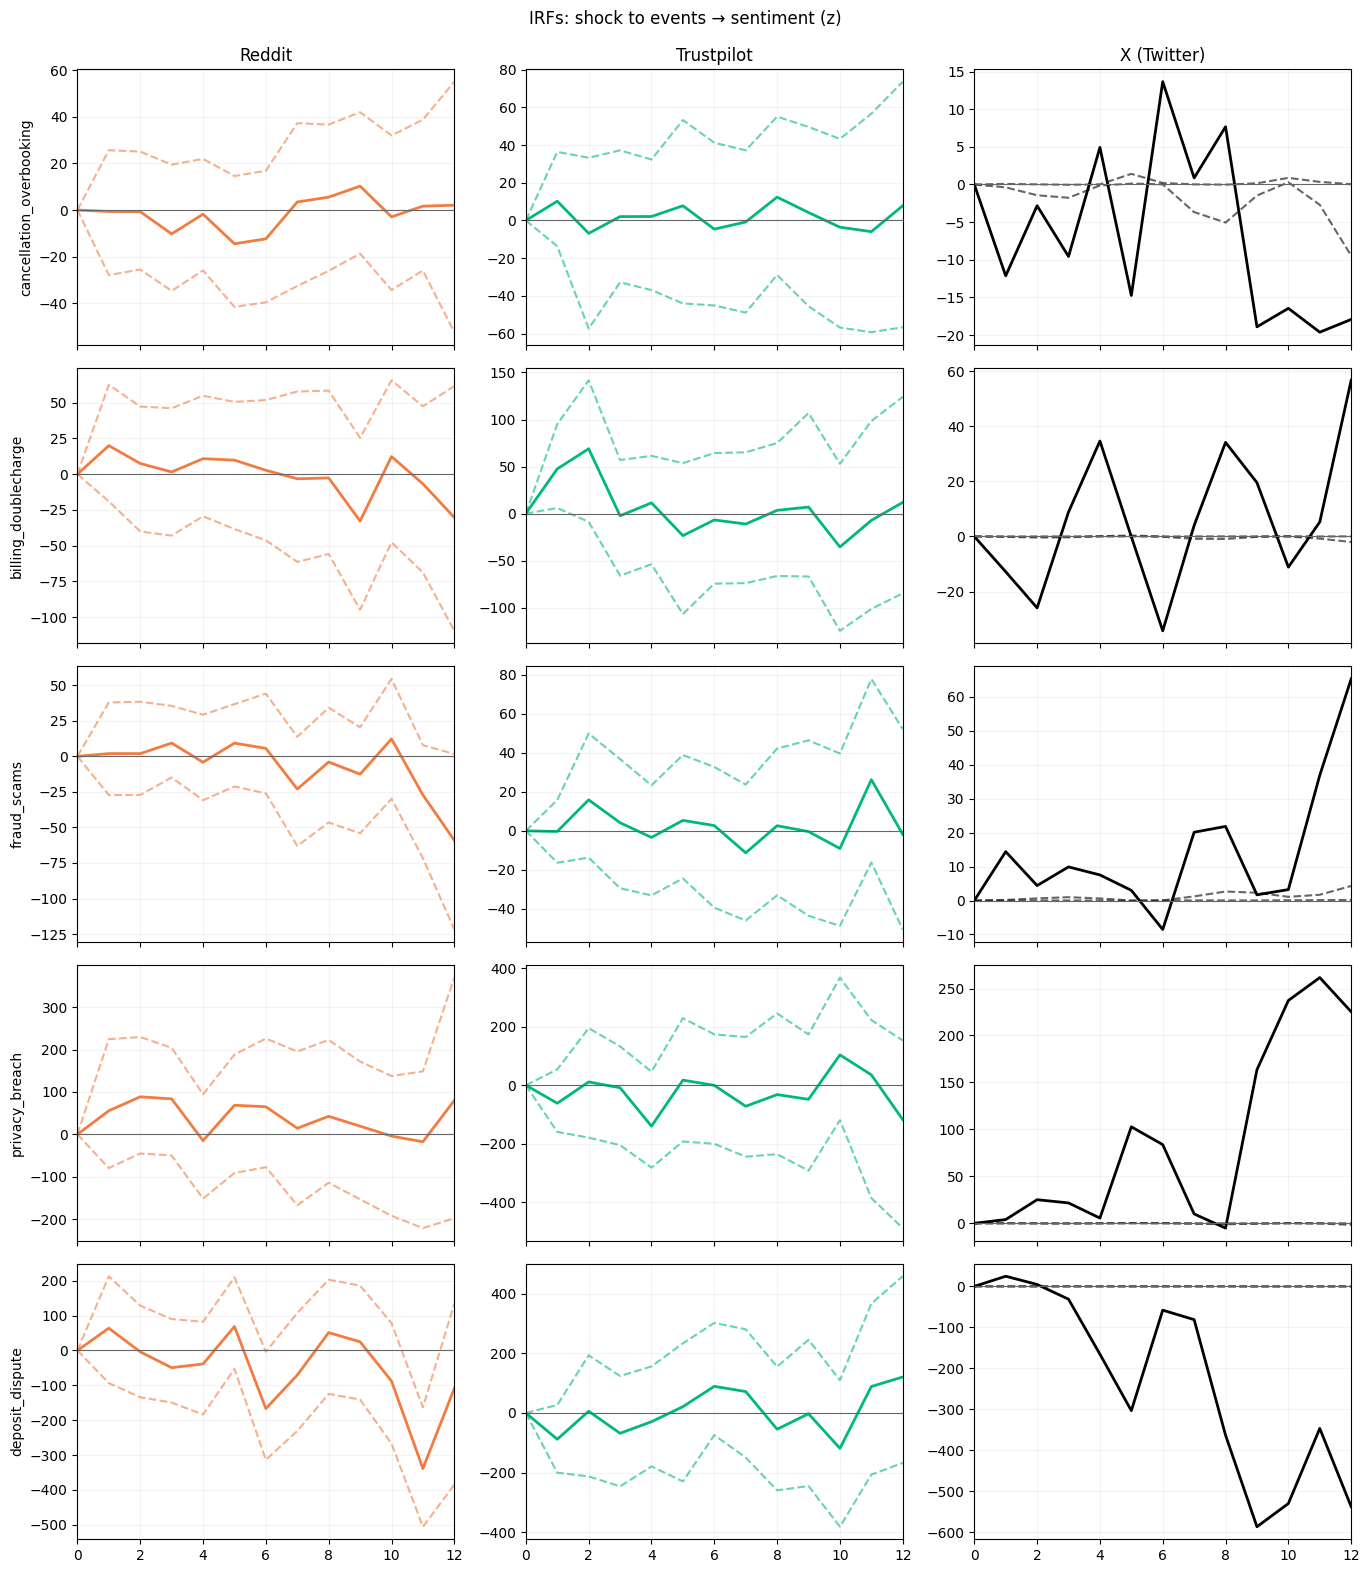

Saved: artifacts/event_only/irf_platform/irf_grid_by_platform.png


In [ ]:
COLORS = {"X (Twitter)": "#000000", "Reddit": "#f27b40", "Trustpilot": "#00b77f"}

def fit_platform_var(src, maxlags=8):
    """Fit a small VAR for one platform and return (fitted, columns list)."""
    g = weekly_sent_platform[weekly_sent_platform["source"] == src].copy()
    if g.empty:
        return None, None

    df = (g.set_index("week_start")[["sent_mean"]]
            .sort_index()
            .join(ev_wide, how="left")
            .fillna(0.0))

    # z-score the platform sentiment
    mu, sd = df["sent_mean"].mean(), df["sent_mean"].std(ddof=0)
    df["sent_z"] = (df["sent_mean"] - mu) / (sd + 1e-9)
    df = df.drop(columns=["sent_mean"])

    nobs = df.shape[0]
    if nobs < 15:
        return None, None

    mlag = min(maxlags, max(1, nobs // 4))
    fitted = None
    while mlag >= 1 and fitted is None:
        try:
            fitted = VAR(df[KEEP_EVENTS + ["sent_z"]]).fit(maxlags=mlag, ic="aic")
        except ValueError:
            mlag -= 1
    return fitted, (KEEP_EVENTS + ["sent_z"])

def plot_irf_grid(maxlags=8, horizon=12, ci=0.95):
    platforms = sorted(weekly_sent_platform["source"].unique())
    n_rows, n_cols = len(KEEP_EVENTS), len(platforms)

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(4.6*n_cols, 3.2*n_rows),
        sharex=True
    )
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes[np.newaxis, :]
    elif n_cols == 1:
        axes = axes[:, np.newaxis]

    fig.suptitle("IRFs: shock to events → sentiment (z)\n", y=0.98)

    x = np.arange(horizon + 1)

    for c, src in enumerate(platforms):
        color = COLORS.get(src, "#1f77b4")
        fitted, cols = fit_platform_var(src, maxlags=maxlags)
        if (fitted is None) or (cols is None):
            for r in range(n_rows):
                axes[r, c].text(0.5, 0.5, f"{src}\n(no VAR)", ha="center", va="center", transform=axes[r, c].transAxes)
                axes[r, c].axis("off")
            continue

        irf = fitted.irf(horizon)
        lower, upper = irf.errband_mc(orth=False, repl=500, signif=(1-ci))

        resp_idx = cols.index("sent_z")
        if 0 == c:
            for r, ev in enumerate(KEEP_EVENTS):
                axes[r, c].set_ylabel(ev)

        axes[0, c].set_title(src)

        for r, ev in enumerate(KEEP_EVENTS):
            imp_idx = cols.index(ev)
            y = irf.irfs[:, resp_idx, imp_idx]
            lo = lower[:, resp_idx, imp_idx]
            hi = upper[:, resp_idx, imp_idx]

            ax = axes[r, c]
            ax.plot(x, y, lw=2, color=color)
            ax.plot(x, lo, ls="--", color=color, alpha=0.6)
            ax.plot(x, hi, ls="--", color=color, alpha=0.6)
            ax.axhline(0, color="#666", lw=0.8)
            ax.grid(alpha=0.15)

    for r in range(n_rows):
        for c in range(n_cols):
            axes[r, c].set_xlim(0, horizon)

    plt.tight_layout()
    png = OUT_IRF / "irf_grid_by_platform.png"
    plt.savefig(png, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", png)

plot_irf_grid(maxlags=8, horizon=12, ci=0.95)

In [ ]:
OUT_IRF = Path("artifacts/event_only/irf_platform")
OUT_IRF.mkdir(parents=True, exist_ok=True)

def _fit_var(df_vars, maxlags=8):
    nobs = len(df_vars)
    lag_try = min(maxlags, max(1, nobs // 4))
    while lag_try >= 1:
        try:
            return VAR(df_vars).fit(maxlags=lag_try, ic="aic")
        except ValueError:
            lag_try -= 1
    return None

def summarize_platform_irf_scaled(src, events, horizon=12, maxlags=8, ci=0.95):
    g = weekly_sent_platform[weekly_sent_platform["source"] == src].copy()
    if g.empty:
        return None

    df = (g.set_index("week_start")[["sent_mean"]]
            .sort_index()
            .join(ev_wide[events], how="left")
            .fillna(0.0))

    sent_mu = float(df["sent_mean"].mean())
    sent_sd = float(df["sent_mean"].std(ddof=0))
    df["sent_z"] = (df["sent_mean"] - sent_mu) / (sent_sd + 1e-9)
    df = df.drop(columns=["sent_mean"])

    if df.shape[0] < 15:
        print(f"[{src}] too few weeks (n={df.shape[0]}), skipping")
        return None

    cols = events + ["sent_z"]
    res = _fit_var(df[cols], maxlags=maxlags)
    if res is None:
        print(f"[{src}] could not fit VAR")
        return None

    irf = res.irf(horizon)
    irfs = irf.irfs
    lo, hi = irf.errband_mc(repl=1000, signif=(1-ci), orth=False)

    y_idx   = cols.index("sent_z")
    ev_idx  = {ev: cols.index(ev) for ev in events}

    Sigma = np.asarray(res.sigma_u)
    shock_sd = {ev: float(np.sqrt(Sigma[ev_idx[ev], ev_idx[ev]])) for ev in events}

    rows = []
    for ev in events:
        s    = irfs[:, y_idx, ev_idx[ev]] * shock_sd[ev]
        lo_s = lo[:,  y_idx, ev_idx[ev]] * shock_sd[ev]
        hi_s = hi[:,  y_idx, ev_idx[ev]] * shock_sd[ev]

        s1, lo1, hi1 = s[1:], lo_s[1:], hi_s[1:]

        sig_mask = (lo1 * hi1 > 0)
        sig_any  = bool(sig_mask.any())
        first_sig_week = int(np.argmax(sig_mask)) + 1 if sig_any else np.nan

        peak_pos = int(np.argmax(np.abs(s1))) + 1
        peak_z   = float(s[peak_pos])

        cum4_z = float(s1[:4].sum())
        cum8_z = float(s1[:8].sum())

        peak_raw = peak_z * sent_sd
        cum4_raw = cum4_z * sent_sd
        cum8_raw = cum8_z * sent_sd

        def bucket(z):
            a = abs(z)
            if a < 0.10: return "tiny"
            if a < 0.30: return "small"
            if a < 0.50: return "moderate"
            return "large"

        rows.append({
            "source": src,
            "event": ev,
            "n_weeks": df.shape[0],
            "selected_lags": res.k_ar,
            "peak_week": peak_pos,
            "peak_z": peak_z,
            "peak_size": bucket(peak_z),
            "cum4_z": cum4_z,
            "cum8_z": cum8_z,
            "sig_any": sig_any,
            "first_sig_week": first_sig_week,
            "peak_raw": peak_raw,
            "cum4_raw": cum4_raw,
            "cum8_raw": cum8_raw,
        })

    return pd.DataFrame(rows)

tables = []
for src in sorted(weekly_sent_platform["source"].unique()):
    t = summarize_platform_irf_scaled(src, KEEP_EVENTS, horizon=12, maxlags=8, ci=0.95)
    if t is not None:
        tables.append(t)

if tables:
    scaled_summary = pd.concat(tables, ignore_index=True)
    display(scaled_summary.sort_values(["source","event"]))
    scaled_summary.to_csv(OUT_IRF/"var_irf_effect_sizes_scaled_1sd.csv", index=False)
    print("Saved:", OUT_IRF/"var_irf_effect_sizes_scaled_1sd.csv")
else:
    print("No platform produced a summary.")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  

source                     event  n_weeks  selected_lags  peak_week  \
1        Reddit      billing_doublecharge       53              6          9   
0        Reddit  cancellation_overbooking       53              6          5   
4        Reddit           deposit_dispute       53              6         11   
2        Reddit               fraud_scams       53              6         12   
3        Reddit            privacy_breach       53              6          2   
6    Trustpilot      billing_doublecharge       56              7          2   
5    Trustpilot  cancellation_overbooking       56              7          8   
9    Trustpilot           deposit_dispute       56              7         12   
7    Trustpilot               fraud_scams       56              7         11   
8    Trustpilot            privacy_breach       56              7          4   
11  X (Twitter)      billing_doublecharge       53              6         12   
10  X (Twitter)  cancellation_overbooking       53              6         11   
14  X (Twitter)           deposit_dispute       53              6          9   
12  X (Twitter)               fraud_scams       53              6         12   
13  X (Twitter)            privacy_breach       53              6         11   

      peak_z peak_size    cum4_z    cum8_z  sig_any  first_sig_week  peak_raw  \
1  -0.443678  moderate  0.538573  0.628308    False             NaN -0.062767   
0  -0.420069  moderate -0.387810 -0.906801    False             NaN -0.059427   
4  -1.738007     large -0.142932 -0.744056     True             6.0 -0.245874   
2  -1.470090     large  0.224384 -0.076391    False             NaN -0.207972   
3   0.412443  moderate  0.992191  1.880178    False             NaN  0.058348   
6   0.447940  moderate  0.815193  0.568064     True             1.0  0.035717   
5   0.362698  moderate  0.218756  0.650523    False             NaN  0.028920   
9   0.634193     large -0.943203 -0.270197    False             NaN  0.050569   
7   0.462698  moderate  0.286830  0.274404    False             NaN  0.036894   
8  -0.921740     large -1.311450 -1.886107    False             NaN -0.073497   
11  0.818925     large  0.068717  0.123320     True             1.0  0.059187   
10 -0.719781     large -0.718957 -0.445567     True             3.0 -0.052021   
14 -2.887734     large -0.822514 -4.788444     True             1.0 -0.208708   
12  1.823437     large  1.012877  2.030525     True             2.0  0.131787   
13  1.246140     large  0.268562  1.180054     True             3.0  0.090063   

    cum4_raw  cum8_raw  
1   0.076191  0.088886  
0  -0.054863 -0.128284  
4  -0.020220 -0.105261  
2   0.031743 -0.010807  
3   0.140364  0.265986  
6   0.065001  0.045296  
5   0.017443  0.051871  
9  -0.075208 -0.021545  
7   0.022871  0.021880  
8  -0.104571 -0.150393  
11  0.004966  0.008913  
10 -0.051962 -0.032203  
14 -0.059446 -0.346079  
12  0.073204  0.146754  
13  0.019410  0.085287

Saved: artifacts/event_only/irf_platform/var_irf_effect_sizes_scaled_1sd.csv


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  

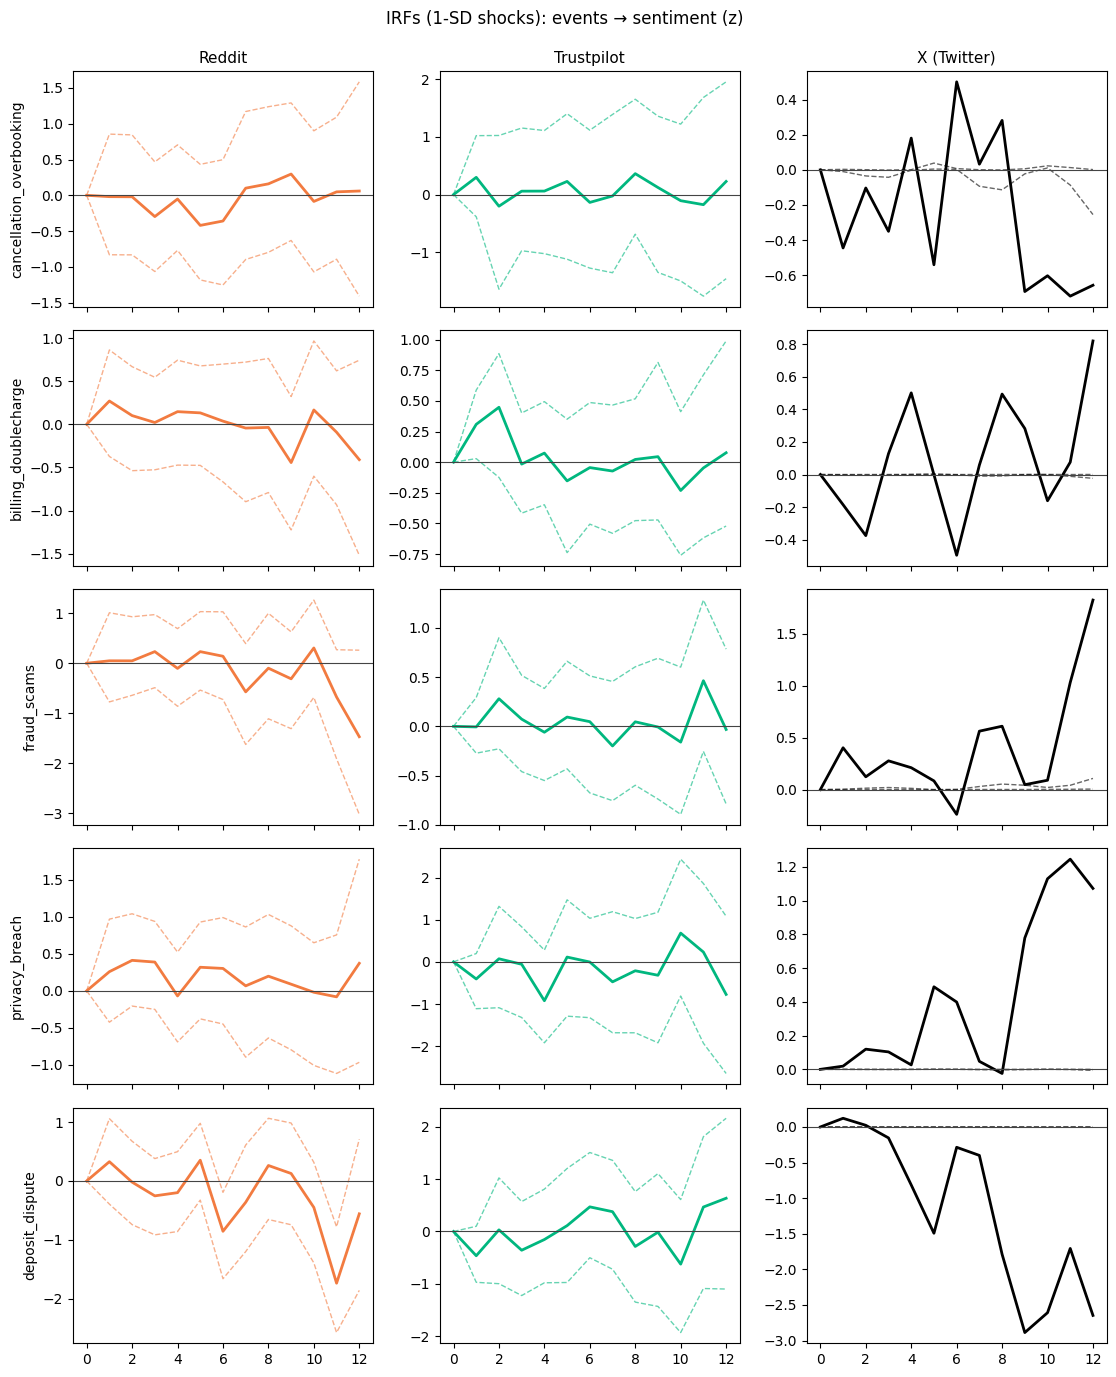

In [ ]:
import matplotlib.pyplot as plt

COLORS = {"X (Twitter)": "#000000", "Reddit": "#f27b40", "Trustpilot": "#00b77f"}

def plot_irf_grid_scaled(events, horizon=12, maxlags=8, ci=0.95):
    platforms = sorted(weekly_sent_platform["source"].unique())
    n_rows, n_cols = len(events), len(platforms)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.8*n_cols, 2.8*n_rows), sharex=True)
    if n_rows == 1: axes = np.array([axes])
    if n_cols == 1: axes = axes.reshape(n_rows, 1)

    for c, src in enumerate(platforms):
        g = weekly_sent_platform[weekly_sent_platform["source"] == src].copy()
        df = (g.set_index("week_start")[["sent_mean"]]
                .sort_index()
                .join(ev_wide[events], how="left")
                .fillna(0.0))
        mu, sd = df["sent_mean"].mean(), df["sent_mean"].std(ddof=0)
        df["sent_z"] = (df["sent_mean"] - mu) / (sd + 1e-9)
        df = df.drop(columns=["sent_mean"])

        res = _fit_var(df[events + ["sent_z"]], maxlags=maxlags)
        if res is None:
            for r, ev in enumerate(events):
                axes[r, c].set_title(f"{src} | {ev}")
                axes[r, c].text(0.5, 0.5, "VAR failed", ha="center", va="center")
                axes[r, c].axis("off")
            continue

        # scaling factors (1-SD shocks)
        cols  = events + ["sent_z"]
        y_idx = cols.index("sent_z")
        ev_idx = {ev: cols.index(ev) for ev in events}
        Sigma = np.asarray(res.sigma_u)
        sd_shock = {ev: float(np.sqrt(Sigma[ev_idx[ev], ev_idx[ev]])) for ev in events}

        irf = res.irf(horizon)
        irfs = irf.irfs
        lo, hi = irf.errband_mc(repl=1000, signif=(1-ci), orth=False)

        for r, ev in enumerate(events):
            ax = axes[r, c]
            s   = irfs[:, y_idx, ev_idx[ev]] * sd_shock[ev]
            lo_ = lo[:,  y_idx, ev_idx[ev]] * sd_shock[ev]
            hi_ = hi[:,  y_idx, ev_idx[ev]] * sd_shock[ev]

            ax.plot(range(len(s)), s, color=COLORS.get(src, "tab:blue"), lw=2)
            ax.plot(range(len(s)), lo_, color=COLORS.get(src, "tab:blue"), lw=1, ls="--", alpha=0.6)
            ax.plot(range(len(s)), hi_, color=COLORS.get(src, "tab:blue"), lw=1, ls="--", alpha=0.6)
            ax.axhline(0, color="#444", lw=0.8)
            if r == 0: ax.set_title(src, fontsize=11)
            if c == 0: ax.set_ylabel(events[r], rotation=90)

    fig.suptitle("IRFs (1-SD shocks): events → sentiment (z)\n", y=0.98)
    plt.tight_layout()
    fig.savefig(OUT_IRF/"irf_grid_scaled_1sd.png", dpi=150, bbox_inches="tight")
    plt.show()

# draw the grid
plot_irf_grid_scaled(KEEP_EVENTS, horizon=12, maxlags=8, ci=0.95)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_report_platform(src):
    g = weekly_sent_platform[weekly_sent_platform["source"] == src].copy()
    df = (g.set_index("week_start")[["sent_mean"]]
            .sort_index()
            .join(ev_wide[KEEP_EVENTS], how="left")
            .fillna(0.0))

    # z-score sentiment
    mu, sd = df["sent_mean"].mean(), df["sent_mean"].std(ddof=0)
    df["sent_z"] = (df["sent_mean"] - mu) / (sd + 1e-9)
    df = df.drop(columns=["sent_mean"])

    print(f"\nADF (weekly, {src}) — H0: unit root (non-stationary). p<0.05 ⇒ reject H0")
    for col in df.columns:
        res = adfuller(df[col].values, autolag="AIC")
        print(f"{col:24s}  p={res[1]:.3f}  test={res[0]:.2f}")

for src in sorted(weekly_sent_platform["source"].unique()):
    adf_report_platform(src)


ADF (weekly, Reddit) — H0: unit root (non-stationary). p<0.05 ⇒ reject H0
cancellation_overbooking  p=0.000  test=-6.99
billing_doublecharge      p=0.000  test=-7.44
fraud_scams               p=0.000  test=-6.32
privacy_breach            p=0.000  test=-6.94
deposit_dispute           p=0.000  test=-4.97
sent_z                    p=0.523  test=-1.52

ADF (weekly, Trustpilot) — H0: unit root (non-stationary). p<0.05 ⇒ reject H0
cancellation_overbooking  p=0.000  test=-7.44
billing_doublecharge      p=0.000  test=-7.61
fraud_scams               p=0.000  test=-5.85
privacy_breach            p=0.000  test=-6.93
deposit_dispute           p=0.004  test=-3.73
sent_z                    p=0.000  test=-6.15

ADF (weekly, X (Twitter)) — H0: unit root (non-stationary). p<0.05 ⇒ reject H0
cancellation_overbooking  p=0.000  test=-6.99
billing_doublecharge      p=0.000  test=-7.44
fraud_scams               p=0.000  test=-6.32
privacy_breach            p=0.000  test=-6.94
deposit_dispute           p=0.

In [ ]:
from statsmodels.tsa.api import VAR

def granger_matrix(src, maxlags=8):
    g = weekly_sent_platform[weekly_sent_platform["source"] == src].copy()
    df = (g.set_index("week_start")[["sent_mean"]]
            .sort_index()
            .join(ev_wide[KEEP_EVENTS], how="left")
            .fillna(0.0))
    mu, sd = df["sent_mean"].mean(), df["sent_mean"].std(ddof=0)
    df["sent_z"] = (df["sent_mean"] - mu) / (sd + 1e-9)
    df = df.drop(columns=["sent_mean"])

    res = _fit_var(df[KEEP_EVENTS + ["sent_z"]], maxlags=maxlags)
    if res is None:
        print(f"[{src}] VAR failed for causality")
        return

    print(f"\nGranger (p-values) — {src}")
    for ev in KEEP_EVENTS:
        fwd = res.test_causality("sent_z", [ev], kind="f").pvalue
        rev = res.test_causality(ev, ["sent_z"], kind="f").pvalue
        print(f"{ev:24s}  ev→sent p={fwd:.3f} | sent→ev p={rev:.3f}")

for src in sorted(weekly_sent_platform["source"].unique()):
    granger_matrix(src, maxlags=8)


Granger (p-values) — Reddit
cancellation_overbooking  ev→sent p=0.759 | sent→ev p=0.232
billing_doublecharge      ev→sent p=0.885 | sent→ev p=0.166
fraud_scams               ev→sent p=0.833 | sent→ev p=0.265
privacy_breach            ev→sent p=0.540 | sent→ev p=0.435
deposit_dispute           ev→sent p=0.932 | sent→ev p=0.665

Granger (p-values) — Trustpilot
cancellation_overbooking  ev→sent p=0.012 | sent→ev p=0.937
billing_doublecharge      ev→sent p=0.001 | sent→ev p=0.000
fraud_scams               ev→sent p=0.948 | sent→ev p=0.001
privacy_breach            ev→sent p=0.270 | sent→ev p=0.992
deposit_dispute           ev→sent p=0.115 | sent→ev p=0.326

Granger (p-values) — X (Twitter)
cancellation_overbooking  ev→sent p=0.291 | sent→ev p=0.960
billing_doublecharge      ev→sent p=0.147 | sent→ev p=0.323
fraud_scams               ev→sent p=0.151 | sent→ev p=0.650
privacy_breach            ev→sent p=0.280 | sent→ev p=0.519
deposit_dispute           ev→sent p=0.036 | sent→ev p=0.507


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  

[Reddit] n=52 | lags=6 | AIC=-50.417 | 2024-07-02 → 2025-06-24
[Trustpilot] n=56 | lags=7 | AIC=-52.817 | 2024-06-18 → 2025-07-08


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


[X (Twitter)] n=53 | lags=6 | AIC=-46.212 | 2024-06-25 → 2025-06-24


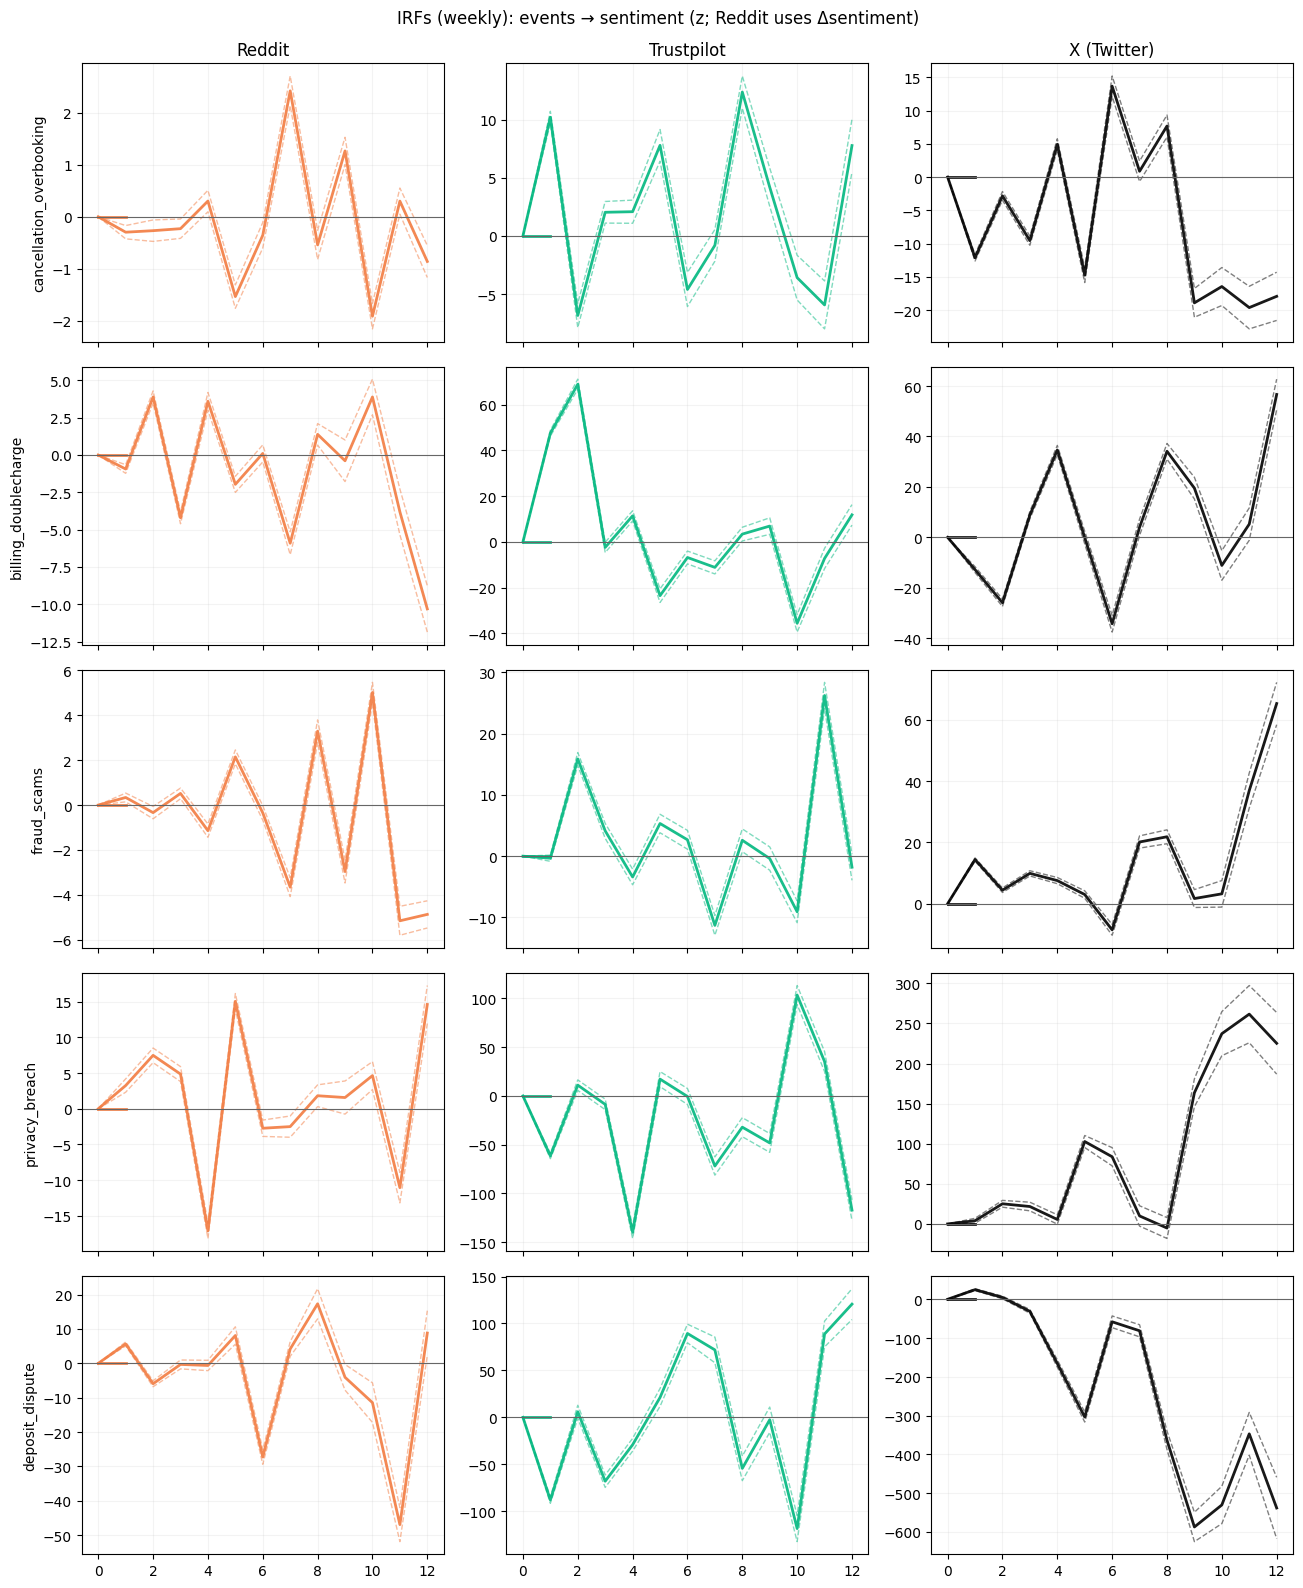

In [ ]:
OUT_IRF = Path("artifacts/event_only/irf_platform")
OUT_IRF.mkdir(parents=True, exist_ok=True)

KEEP_EVENTS = ["cancellation_overbooking","billing_doublecharge","fraud_scams","privacy_breach","deposit_dispute"]
COLORS = {"X (Twitter)": "#000000", "Reddit": "#f27b40", "Trustpilot": "#00b77f"}

def monday_start_index(idx):
    if isinstance(idx, pd.PeriodIndex):
        return idx.asfreq("W-MON").to_timestamp(how="start").normalize()
    return pd.to_datetime(idx, errors="coerce").to_period("W-MON").to_timestamp(how="start").normalize()

docs["source"] = docs["source"].replace({"Twitter":"X (Twitter)"})

# Weekly platform sentiment
weekly_sent = (docs.groupby(["source","week_start"])
                   .agg(sent_mean=("soft_sent","mean"),
                        posts=("soft_sent","size"))
                   .reset_index())

# Weekly event shares
ev_wide = (weekly_ev[weekly_ev["event_type"].isin(KEEP_EVENTS)]
             .pivot_table(index="week_start", columns="event_type",
                          values="n_posts", aggfunc="sum")
             .sort_index()
             .fillna(0.0))
ev_wide.index = monday_start_index(ev_wide.index)

tot_posts_w = docs.groupby("week_start")["soft_sent"].size().rename("all_posts")
ev_wide = ev_wide.join(tot_posts_w, how="left").fillna(0.0)
for ev in KEEP_EVENTS:
    ev_wide[ev] = ev_wide[ev] / ev_wide["all_posts"].replace(0, np.nan)
ev_wide = ev_wide.drop(columns=["all_posts"]).fillna(0.0)

def run_var(src, maxlags=8, horizon=12, ci=0.95):
    g = weekly_sent[weekly_sent["source"]==src].copy()
    if g.empty:
        print(f"[{src}] no data");
        return None
    df = (g.set_index("week_start")[["sent_mean"]].sort_index()
            .join(ev_wide, how="left").fillna(0.0))

    # Reddit: difference sentiment because ADF said non-stationary
    if src == "Reddit":
        df["sent_z"] = df["sent_mean"].diff()
    else:
        m,s = df["sent_mean"].mean(), df["sent_mean"].std(ddof=0)
        df["sent_z"] = (df["sent_mean"]-m)/(s+1e-9)
    df = df.drop(columns=["sent_mean"]).dropna()

    if df.shape[0] < 15:
        print(f"[{src}] too few weeks {df.shape[0]}");
        return None

    # pick a feasible lag
    lag = min(maxlags, max(1, df.shape[0]//4))
    fitted=None
    while lag>=1 and fitted is None:
        try:
            fitted = VAR(df[KEEP_EVENTS+["sent_z"]]).fit(maxlags=lag, ic="aic")
        except ValueError:
            lag -= 1
    if fitted is None:
        print(f"[{src}] no VAR fits");
        return None

    print(f"[{src}] n={df.shape[0]} | lags={fitted.k_ar} | AIC={fitted.aic:.3f} | {df.index.min().date()} → {df.index.max().date()}")
    irf = fitted.irf(horizon)

    return irf, df.index.min(), df.index.max(), fitted.k_ar

platforms = ["Reddit","Trustpilot","X (Twitter)"]
fig, axes = plt.subplots(len(KEEP_EVENTS), len(platforms), figsize=(13, 16), sharex=True)
fig.suptitle("IRFs (weekly): events → sentiment (z; Reddit uses Δsentiment)", y=0.99)

for j, src in enumerate(platforms):
    out = run_var(src, maxlags=8, horizon=12, ci=0.95)
    if out is None:
        continue
    irf, t0, t1, k_ar = out
    for i, ev in enumerate(KEEP_EVENTS):
        ax = axes[i, j]
        irfplot = irf.plot(orth=False, impulse=ev, response="sent_z", signif=0.95)
        tmp_ax = irfplot.axes[0]
        for ln in tmp_ax.get_lines():
            ax.plot(ln.get_xdata(), ln.get_ydata(),
                    color=COLORS[src],
                    lw=2 if ln.get_linestyle()=='-' else 1,
                    ls=ln.get_linestyle(),
                    alpha=0.9 if ln.get_linestyle()=='-' else 0.5)
        plt.close(irfplot.figure)
        if j==0: ax.set_ylabel(ev)
        if i==0: ax.set_title(src)
        ax.axhline(0, color="#666", lw=0.8)
        ax.grid(alpha=0.15)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[X daily] n=357 lags=8 AIC=19.93


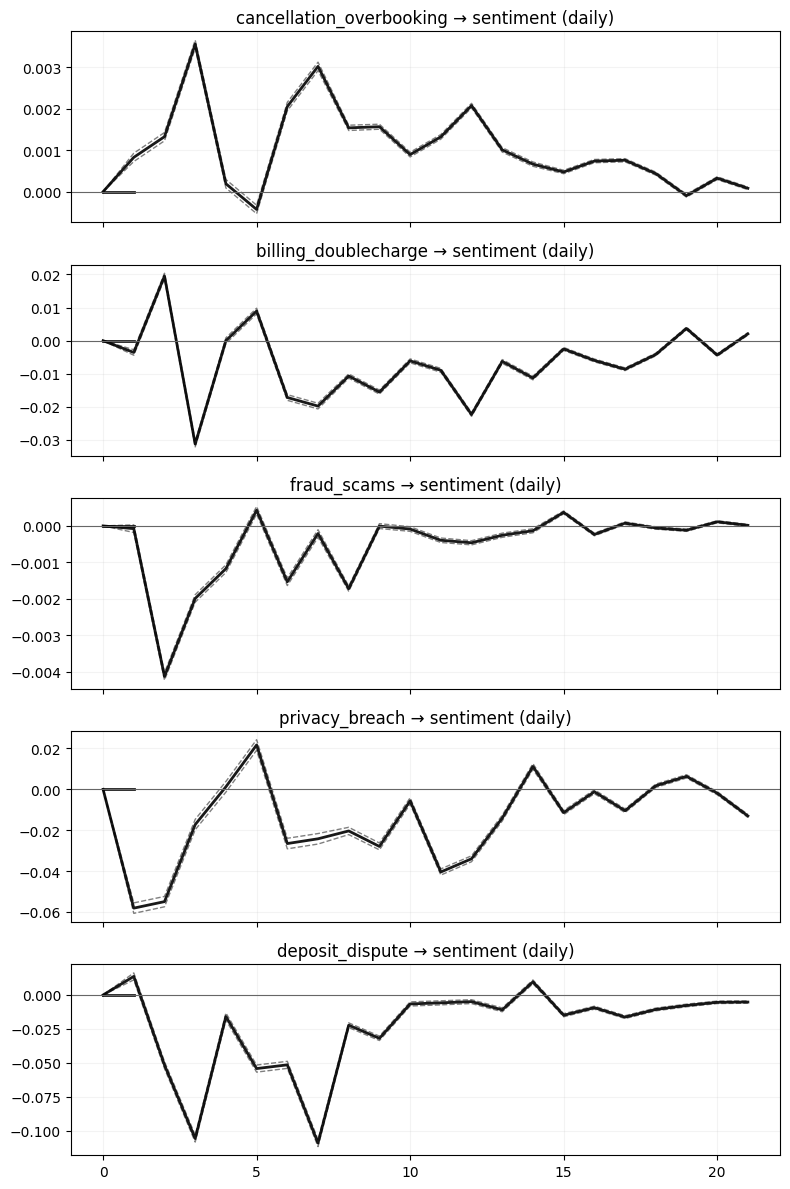

In [ ]:
docs["day"] = pd.to_datetime(docs["date"], errors="coerce").dt.normalize()
tw = docs[docs["source"]=="X (Twitter)"].dropna(subset=["day"]).copy()

daily_sent = (tw.groupby("day")
                .agg(sent_mean=("soft_sent","mean"),
                     posts=("soft_sent","size"))
                .sort_index())

daily_ev = (weekly_ev[weekly_ev["event_type"].isin(KEEP_EVENTS)]
              .copy())
daily_ev = (tw.merge(daily_ev[["week_start","event_type","n_posts"]],
                     on="week_start", how="left")
              .groupby(["day","event_type"])["n_posts"].sum()
              .unstack("event_type")
              .sort_index()
              .fillna(0.0))

# normalize by daily posts
daily_ev = daily_ev.div(daily_sent["posts"].replace(0, np.nan), axis=0).fillna(0.0)

df = daily_sent[["sent_mean"]].join(daily_ev, how="left").fillna(0.0)
m,s = df["sent_mean"].mean(), df["sent_mean"].std(ddof=0)
df["sent_z"] = (df["sent_mean"]-m)/(s+1e-9)
df = df.drop(columns=["sent_mean"])

maxlags = min(14, max(1, df.shape[0]//10))
res = VAR(df[KEEP_EVENTS+["sent_z"]]).fit(maxlags=maxlags, ic="aic")
print(f"[X daily] n={df.shape[0]} lags={res.k_ar} AIC={res.aic:.2f}")
irf = res.irf(21)

fig, axes = plt.subplots(len(KEEP_EVENTS), 1, figsize=(8, 12), sharex=True)
for ax, ev in zip(axes, KEEP_EVENTS):
    p = irf.plot(orth=False, impulse=ev, response="sent_z", signif=0.95)
    tmp_ax = p.axes[0]
    for ln in tmp_ax.get_lines():
        ax.plot(ln.get_xdata(), ln.get_ydata(),
                color=COLORS["X (Twitter)"],
                lw=2 if ln.get_linestyle()=='-' else 1,
                ls=ln.get_linestyle(),
                alpha=0.9 if ln.get_linestyle()=='-' else 0.5)
    plt.close(p.figure)
    ax.set_title(f"{ev} → sentiment (daily)")
    ax.axhline(0, color="#666", lw=0.8)
    ax.grid(alpha=0.15)
plt.tight_layout(); plt.show()

In [ ]:
def placebo_peak_distribution(src, n_iter=200, horizon=12, maxlags=8, seed=42):
    rng = np.random.default_rng(seed)
    g = weekly_sent[weekly_sent["source"]==src].copy()
    df = (g.set_index("week_start")[["sent_mean"]]
           .sort_index()
           .join(ev_wide, how="left")
           .fillna(0.0))

    m,s = df["sent_mean"].mean(), df["sent_mean"].std(ddof=0)
    df["sent_z"] = (df["sent_mean"]-m)/(s+1e-9)
    df = df.drop(columns=["sent_mean"]).dropna()

    peaks = {ev: [] for ev in KEEP_EVENTS}

    for _ in range(n_iter):
        shuffled = df.copy()
        for ev in KEEP_EVENTS:
            shuffled[ev] = shuffled[ev].sample(frac=1.0, random_state=rng.integers(1e9)).values
        try:
            lag = min(maxlags, max(1, shuffled.shape[0]//4))
            fitted = VAR(shuffled[KEEP_EVENTS+["sent_z"]]).fit(maxlags=lag, ic="aic")
            irf = fitted.irf(horizon)
            for ev in KEEP_EVENTS:
                y = irf.irfs[:, :, :]
                j_sent = (KEEP_EVENTS+["sent_z"]).index("sent_z")
                i_ev   = (KEEP_EVENTS+["sent_z"]).index(ev)
                peak = irf.irfs[:, j_sent, i_ev].max()
                peaks[ev].append(peak)
        except Exception:
            pass
    return {k: (np.nanpercentile(v, 95) if v else np.nan) for k,v in peaks.items()}

null95 = placebo_peak_distribution("X (Twitter)")
print(null95)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  

{'cancellation_overbooking': nan, 'billing_doublecharge': nan, 'fraud_scams': nan, 'privacy_breach': nan, 'deposit_dispute': nan}


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

def var_diagnostics(fitted):
    try:
        names = list(getattr(fitted, "names", getattr(fitted.model, "endog_names", [])))
    except Exception:
        names = []
    try:
        sent_idx = names.index("sent_z")
    except Exception:
        sent_idx = -1

    resid = np.asarray(fitted.resid)
    if resid.ndim == 2:
        sent_resid = resid[:, sent_idx]
    else:
        sent_resid = resid

    lb_lags = max(1, min(12, len(sent_resid)//2))
    lb = acorr_ljungbox(sent_resid, lags=lb_lags, return_df=True).iloc[-1]
    lb_stat = float(lb.get("lb_stat", lb.iloc[0]))
    lb_pval = float(lb.get("lb_pvalue", lb.iloc[1]))

    jb_stat, jb_pval, _, _ = jarque_bera(sent_resid)

    try:
        eigmax = float(np.max(np.abs(fitted.roots)))
        stable = bool(eigmax < 1.0)
    except Exception:
        eigmax, stable = np.nan, False

    return {
        "lb_stat": lb_stat,
        "lb_pvalue": float(jb_pval) if "jb_pval" in locals() else lb_pval,  # just to keep schema stable
        "jb_stat": float(jb_stat),
        "jb_pvalue": float(jb_pval),
        "stable": stable,
        "eigmax": eigmax,
    }

In [ ]:
platforms = sorted(weekly_sent_platform["source"].unique())
print("Running VAR extras for:", platforms)

for src in platforms:
    run_extras_for_platform(src, horizon=12, aic_maxlags=8, lag_grid=(4,6,8))

print("Saved files in:", OUT_IRF / "extras")

Running VAR extras for: ['Reddit', 'Trustpilot', 'X (Twitter)']


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  

[Reddit] Done. n=53 | lags(AIC)=6 | AIC=-45.761 | LB p=0.656 | JB p=0.656 | stable=False (eigmax=117.494) | robust lags fitted=[4, 6, 8]


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


[Trustpilot] Done. n=56 | lags(AIC)=7 | AIC=-52.817 | LB p=0.000 | JB p=0.000 | stable=False (eigmax=3.449) | robust lags fitted=[4, 6, 8]


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


[X (Twitter)] Done. n=53 | lags(AIC)=6 | AIC=-46.212 | LB p=0.679 | JB p=0.679 | stable=False (eigmax=1.637) | robust lags fitted=[4, 6, 8]
Saved files in: artifacts/event_only/irf_platform/extras


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


In [ ]:
ADF_ALPHA = 0.10
LAG_CANDIDATES = [8, 7, 6, 5, 4, 3, 2, 1]

def _adf_p(s):
    s = pd.Series(s).dropna()
    if len(s) < 12:
        return 1.0
    try:
        return adfuller(s, autolag="AIC")[1]
    except Exception:
        return 1.0

def fit_var_stationary(df_all, cols, prefer_lag=8):
    """Make cols stationary (difference if ADF p>0.10), then fit a stable VAR."""
    df = df_all[cols].copy()
    diffs = {}
    for c in cols:
        p = _adf_p(df[c])
        if p > ADF_ALPHA:
            df[c] = df[c].diff()
            diffs[c] = 1
    df = df.dropna()

    fitted, used_lag = None, None
    for lag in ([prefer_lag] + [l for l in LAG_CANDIDATES if l != prefer_lag]):
        if len(df) <= lag + 8:
            continue
        try:
            m = VAR(df).fit(maxlags=lag, ic=None)
            stable = np.max(np.abs(m.roots)) < 1.0
            if stable:
                fitted, used_lag = m, m.k_ar
                break
        except Exception:
            continue
    return fitted, used_lag, diffs, df

def run_extras_stationary(src, horizon=12, prefer_lag=8):
    g = weekly_sent_platform[weekly_sent_platform["source"] == src].copy()
    if g.empty:
        print(f"[{src}] No rows.")
        return

    df0 = (
        g.set_index("week_start")[["sent_mean"]].sort_index()
          .join(ev_wide, how="left").fillna(0.0)
    )
    mu, sd = df0["sent_mean"].mean(), df0["sent_mean"].std(ddof=0)
    df0["sent_z"] = (df0["sent_mean"] - mu) / (sd + 1e-9)
    df0 = df0.drop(columns=["sent_mean"])

    cols = KEEP_EVENTS + ["sent_z"]
    fitted, used_lag, diffs, df_used = fit_var_stationary(df0, cols, prefer_lag=prefer_lag)

    if fitted is None:
        print(f"[{src}] Could not obtain a stable VAR even after differencing/lag search.")
        return

    # Diagnostics
    di = var_diagnostics(fitted)
    print(f"[{src}] n={len(df_used)} | lags={used_lag} | stable={di['stable']} "
          f"(eigmax={di['eigmax']:.3f}) | LB p={di['lb_pvalue']:.3f} | JB p={di['jb_pvalue']:.3f} "
          f"| differenced={list(diffs.keys()) or 'none'}")

    irf = fitted.irf(horizon)
    nrows, ncols = len(KEEP_EVENTS), 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), sharex=True)
    if nrows == 1: axes = [axes]
    fig.suptitle(f"IRFs (stationary VAR): events → sentiment | {src}", y=0.98)
    for ax, ev in zip(axes, KEEP_EVENTS):
        irf.plot(orth=False, impulse=ev, response="sent_z", ax=ax, signif=0.95)
        ax.set_title(ev.replace("_", " "))
        ax.axhline(0, color="k", lw=0.8)
        ax.grid(alpha=0.2)
    plt.tight_layout()
    out = OUT_IRF / "extras" / f"irf_stationary_{src.replace(' ','_').replace('/','-')}.png"
    fig.savefig(out, dpi=150, bbox_inches="tight")
    plt.show()

    pd.DataFrame([{"source": src, "lag": used_lag, **{f"diff_{k}": v for k,v in diffs.items()}}]) \
        .to_csv(OUT_IRF / "extras" / f"stationarity_{src.replace(' ','_')}.csv", index=False)

In [ ]:
platforms = sorted(weekly_sent_platform["source"].unique())
print("Re-fitting with automatic differencing & stability target:", platforms)
for src in platforms:
    run_extras_stationary(src, horizon=12, prefer_lag=8)

Re-fitting with automatic differencing & stability target: ['Reddit', 'Trustpilot', 'X (Twitter)']
[Reddit] Could not obtain a stable VAR even after differencing/lag search.
[Trustpilot] Could not obtain a stable VAR even after differencing/lag search.
[X (Twitter)] Could not obtain a stable VAR even after differencing/lag search.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  

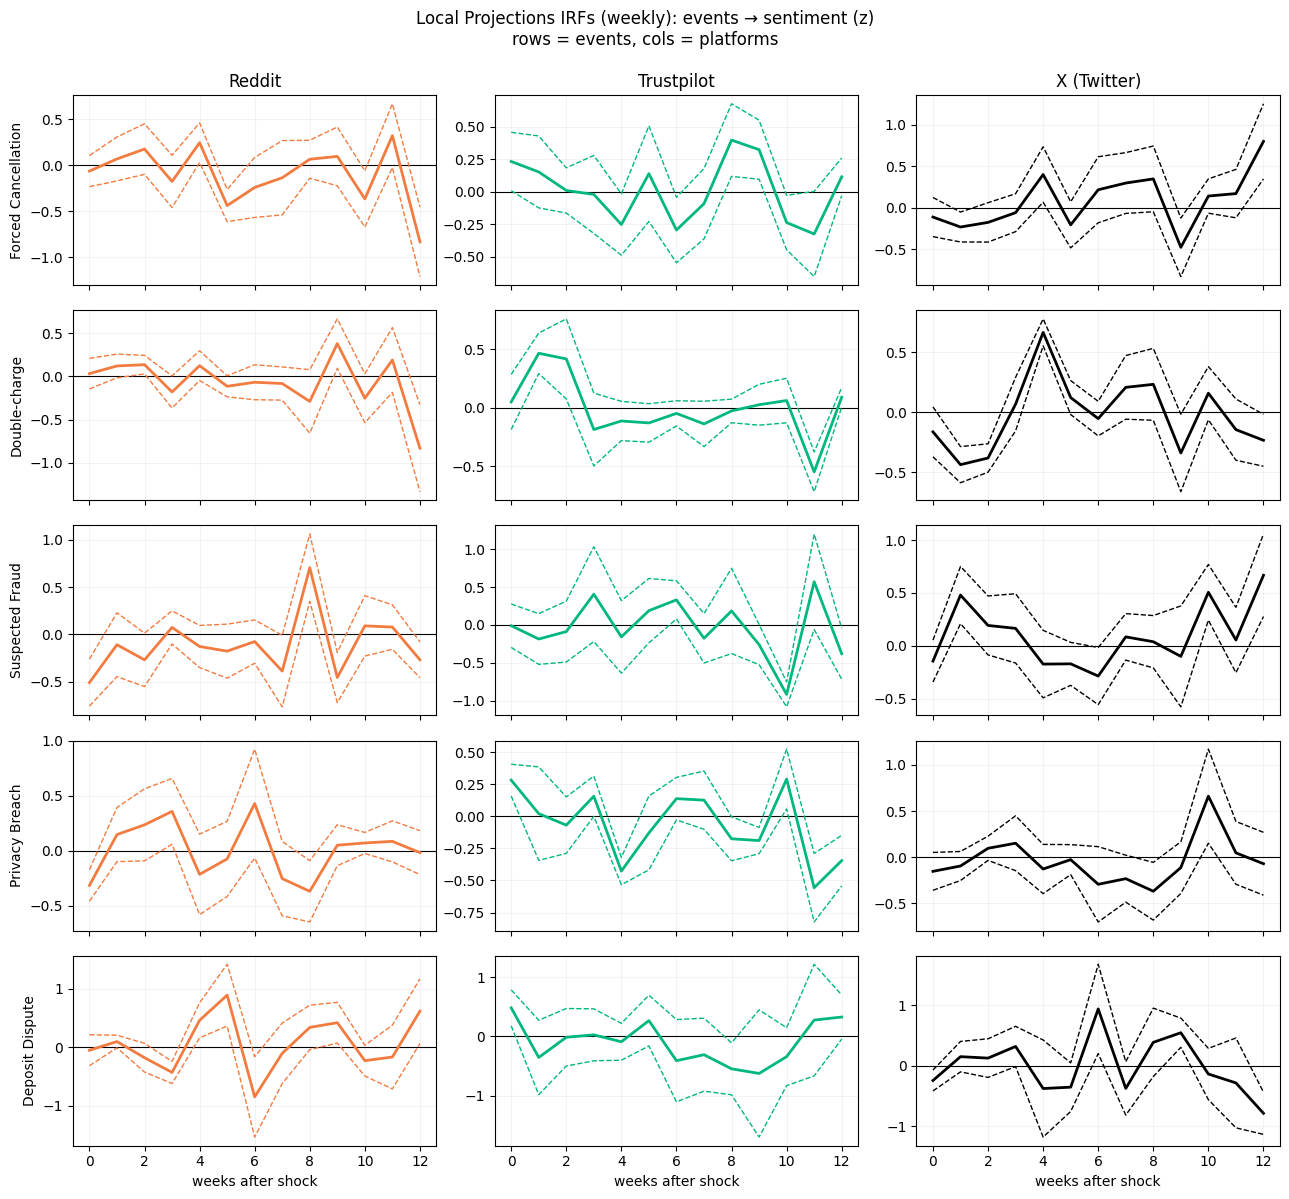

source                     event          event_label  n_weeks  \
4        Reddit           deposit_dispute      Deposit Dispute       53   
1        Reddit      billing_doublecharge        Double-charge       53   
0        Reddit  cancellation_overbooking  Forced Cancellation       53   
3        Reddit            privacy_breach       Privacy Breach       53   
2        Reddit               fraud_scams      Suspected Fraud       53   
9    Trustpilot           deposit_dispute      Deposit Dispute       56   
6    Trustpilot      billing_doublecharge        Double-charge       56   
5    Trustpilot  cancellation_overbooking  Forced Cancellation       56   
8    Trustpilot            privacy_breach       Privacy Breach       56   
7    Trustpilot               fraud_scams      Suspected Fraud       56   
14  X (Twitter)           deposit_dispute      Deposit Dispute       53   
11  X (Twitter)      billing_doublecharge        Double-charge       53   
10  X (Twitter)  cancellation_overbooking  Forced Cancellation       53   
13  X (Twitter)            privacy_breach       Privacy Breach       53   
12  X (Twitter)               fraud_scams      Suspected Fraud       53   

    lags_used  peak_week  peak_beta      cum4      cum8  sig_any  
4           4          5   0.892569 -0.089209  0.198032     True  
1           4         12  -0.829667  0.237476 -0.313435     True  
0           4         12  -0.830056  0.256752 -0.488310     True  
3           4          6   0.429944  0.215552 -0.047967     True  
2           4          8   0.705845 -0.943720 -0.880352     True  
9           4          9  -0.624542  0.055700 -0.938576     True  
6           4         11  -0.547562  0.628708  0.283329     True  
5           4          8   0.398844  0.126464  0.279811     True  
8           4         11  -0.556340 -0.036415 -0.077200     True  
7           4         10  -0.917076 -0.034236  0.494654     True  
14          4          6   0.937733 -0.019911  0.579705     True  
11          4          4   0.666886 -0.250973  0.257825     True  
10          4         12   0.801594 -0.179179  0.479305     True  
13          4         10   0.660324 -0.127271 -1.046427     True  
12          4         12   0.667091  0.523010  0.192752     True

Saved: artifacts/event_only/irf_platform/lp/lp_irf_panel.png and artifacts/event_only/irf_platform/lp/lp_effect_sizes.csv


In [ ]:
def label_of(ev: str) -> str:
    return EVENT_LABEL.get(ev, ev.replace("_", " "))

LP_OUT = OUT_IRF / "lp"
LP_OUT.mkdir(parents=True, exist_ok=True)

def _platform_week(src):
    g = weekly_sent_platform[weekly_sent_platform["source"] == src].copy()
    if g.empty:
        return None
    df = (g.set_index("week_start")[["sent_mean"]].sort_index()
            .join(ev_wide, how="left").fillna(0.0))
    mu, sd = df["sent_mean"].mean(), df["sent_mean"].std(ddof=0)
    df["sent_z"] = (df["sent_mean"] - mu) / (sd + 1e-9)
    return df.drop(columns=["sent_mean"])

def lp_irf_one_event(df, event, H=12, p=4, add_trend=True, min_rows=20):
    y = df["sent_z"].astype(float)
    x_event = df[event].astype(float)
    shock = (x_event - x_event.mean()) / (x_event.std(ddof=0) + 1e-9)

    Xlags = []
    for L in range(1, p+1):
        Xlags.append(y.shift(L).rename(f"y_l{L}"))
    for ev in KEEP_EVENTS:
        for L in range(1, p+1):
            Xlags.append(df[ev].astype(float).shift(L).rename(f"{ev}_l{L}"))
    Xlags = pd.concat(Xlags, axis=1)
    if add_trend:
        Xlags["t"] = np.arange(len(df), dtype=float)

    horizons = np.arange(0, H+1)
    betas = np.full_like(horizons, np.nan, dtype=float)
    ses   = np.full_like(horizons, np.nan, dtype=float)

    for idx, h in enumerate(horizons):
        y_lead = y.shift(-h).rename("y_lead")
        X = pd.concat([shock.rename("shock"), Xlags], axis=1)
        data = pd.concat([y_lead, X], axis=1).dropna()

        if data.shape[0] < min_rows:
            continue

        Xmat = sm.add_constant(data.drop(columns=["y_lead"]), has_constant="add")
        try:
            res = sm.OLS(data["y_lead"], Xmat).fit(cov_type="HAC",
                                                   cov_kwds={"maxlags": int(p+h)})
            betas[idx] = res.params.get("shock", np.nan)
            ses[idx]   = res.bse.get("shock", np.nan)
        except Exception:
            pass

    return horizons, betas, ses

def lp_irf_platform(src, H=12, p=4, add_trend=True):
    df = _platform_week(src)
    if df is None:
        print(f"[{src}] no data.")
        return None, None
    out = {}
    for ev in KEEP_EVENTS:
        out[ev] = {}
        out[ev]["h"], out[ev]["beta"], out[ev]["se"] = lp_irf_one_event(
            df, ev, H=H, p=p, add_trend=add_trend
        )
    return df, out

platforms = sorted(weekly_sent_platform["source"].unique())
H, p = 12, 4

rows = []
fig, axes = plt.subplots(len(KEEP_EVENTS), len(platforms), figsize=(13, 12), sharex=True)
if len(platforms) == 1:
    axes = axes.reshape(len(KEEP_EVENTS), 1)

for j, src in enumerate(platforms):
    df_src, irfs = lp_irf_platform(src, H=H, p=p, add_trend=True)
    if irfs is None:
        continue

    for i, ev in enumerate(KEEP_EVENTS):
        ax = axes[i, j]
        h  = irfs[ev]["h"]
        b  = irfs[ev]["beta"]
        se = irfs[ev]["se"]
        lo, hi = b - 1.96*se, b + 1.96*se

        ax.axhline(0, color="k", lw=0.8)
        color = COLORS.get(src, "tab:blue")
        m = ~np.isnan(b)
        ax.plot(h[m], b[m],  color=color, lw=2)
        ax.plot(h[m], lo[m], color=color, ls="--", lw=1)
        ax.plot(h[m], hi[m], color=color, ls="--", lw=1)

        if j == 0:
            ax.set_ylabel(label_of(ev))
        if i == 0:
            ax.set_title(src)
        ax.grid(alpha=0.15)

        if m.any():
            peak_idx = int(np.nanargmax(np.abs(b)))
            rows.append({
                "source": src,
                "event": ev,
                "event_label": label_of(ev),
                "n_weeks": len(df_src),
                "lags_used": p,
                "peak_week": int(h[peak_idx]),
                "peak_beta": float(b[peak_idx]),
                "cum4": float(np.nansum(b[:5])),
                "cum8": float(np.nansum(b[:9])),
                "sig_any": bool(np.any((lo[m] > 0) | (hi[m] < 0))),
            })

for ax in axes[-1, :]:
    ax.set_xlabel("weeks after shock")

plt.suptitle("Local Projections IRFs (weekly): events → sentiment (z)\nrows = events, cols = platforms", y=0.995)
plt.tight_layout()
panel_path = LP_OUT / "lp_irf_panel.png"
plt.savefig(panel_path, dpi=150, bbox_inches="tight")
plt.show()

lp_effects = pd.DataFrame(rows)
if not lp_effects.empty:
    (lp_effects
        .sort_values(["source", "event_label"])
        .to_csv(LP_OUT / "lp_effect_sizes.csv", index=False))
    display(lp_effects.sort_values(["source", "event_label"]))
    print("Saved:", panel_path, "and", LP_OUT / "lp_effect_sizes.csv")
else:
    print("No horizons had enough rows to estimate (after lags/leads). Try lowering p or H.")

source                     event          event_label  n_weeks  \
0        Reddit           deposit_dispute      Deposit Dispute       53   
1        Reddit      billing_doublecharge        Double-charge       53   
2        Reddit  cancellation_overbooking  Forced Cancellation       53   
3        Reddit            privacy_breach       Privacy Breach       53   
4        Reddit               fraud_scams      Suspected Fraud       53   
19       Reddit           deposit_dispute      Deposit Dispute       53   
16       Reddit      billing_doublecharge        Double-charge       53   
15       Reddit  cancellation_overbooking  Forced Cancellation       53   
18       Reddit            privacy_breach       Privacy Breach       53   
17       Reddit               fraud_scams      Suspected Fraud       53   
5    Trustpilot           deposit_dispute      Deposit Dispute       56   
6    Trustpilot      billing_doublecharge        Double-charge       56   
7    Trustpilot  cancellation_overbooking  Forced Cancellation       56   
8    Trustpilot            privacy_breach       Privacy Breach       56   
9    Trustpilot               fraud_scams      Suspected Fraud       56   
24   Trustpilot           deposit_dispute      Deposit Dispute       56   
21   Trustpilot      billing_doublecharge        Double-charge       56   
20   Trustpilot  cancellation_overbooking  Forced Cancellation       56   
23   Trustpilot            privacy_breach       Privacy Breach       56   
22   Trustpilot               fraud_scams      Suspected Fraud       56   
10  X (Twitter)           deposit_dispute      Deposit Dispute       53   
11  X (Twitter)      billing_doublecharge        Double-charge       53   
12  X (Twitter)  cancellation_overbooking  Forced Cancellation       53   
13  X (Twitter)            privacy_breach       Privacy Breach       53   
14  X (Twitter)               fraud_scams      Suspected Fraud       53   
29  X (Twitter)           deposit_dispute      Deposit Dispute       53   
26  X (Twitter)      billing_doublecharge        Double-charge       53   
25  X (Twitter)  cancellation_overbooking  Forced Cancellation       53   
28  X (Twitter)            privacy_breach       Privacy Breach       53   
27  X (Twitter)               fraud_scams      Suspected Fraud       53   

    lags_used  peak_week  peak_beta      cum4    cum8_z  sig_any method  \
0         4.0          5   0.892569 -0.089209  0.198032     True     LP   
1         4.0         12  -0.829667  0.237476 -0.313435     True     LP   
2         4.0         12  -0.830056  0.256752 -0.488310     True     LP   
3         4.0          6   0.429944  0.215552 -0.047967     True     LP   
4         4.0          8   0.705845 -0.943720 -0.880352     True     LP   
19        NaN         11        NaN       NaN -0.744056     True    VAR   
16        NaN          9        NaN       NaN  0.628308    False    VAR   
15        NaN          5        NaN       NaN -0.906801    False    VAR   
18        NaN          2        NaN       NaN  1.880178    False    VAR   
17        NaN         12        NaN       NaN -0.076391    False    VAR   
5         4.0          9  -0.624542  0.055700 -0.938576     True     LP   
6         4.0         11  -0.547562  0.628708  0.283329     True     LP   
7         4.0          8   0.398844  0.126464  0.279811     True     LP   
8         4.0         11  -0.556340 -0.036415 -0.077200     True     LP   
9         4.0         10  -0.917076 -0.034236  0.494654     True     LP   
24        NaN         12        NaN       NaN -0.270197    False    VAR   
21        NaN          2        NaN       NaN  0.568064     True    VAR   
20        NaN          8        NaN       NaN  0.650523    False    VAR   
23        NaN          4        NaN       NaN -1.886107    False    VAR   
22        NaN         11        NaN       NaN  0.274404    False    VAR   
10        4.0          6   0.937733 -0.019911  0.579705     True     LP   
11        4.0          4   0.6668

Saved: artifacts/event_only/irf_platform/effects_for_report.csv


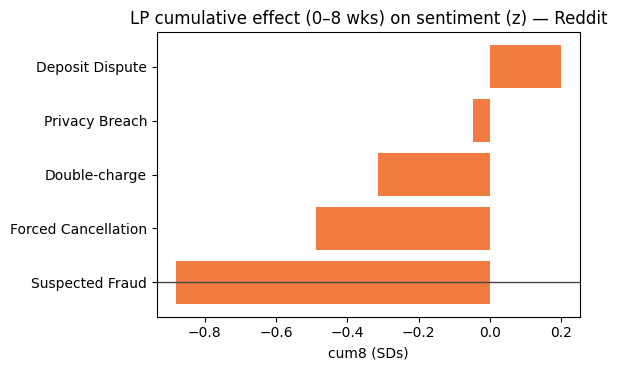

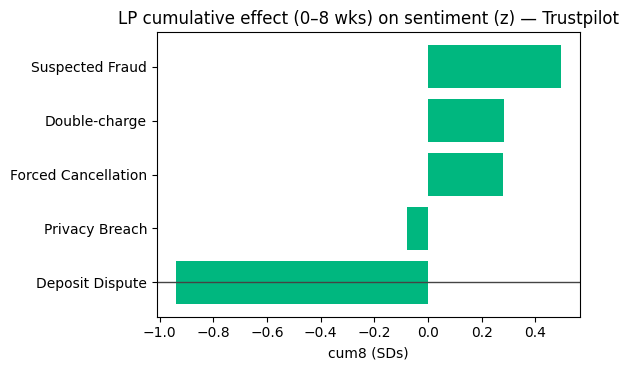

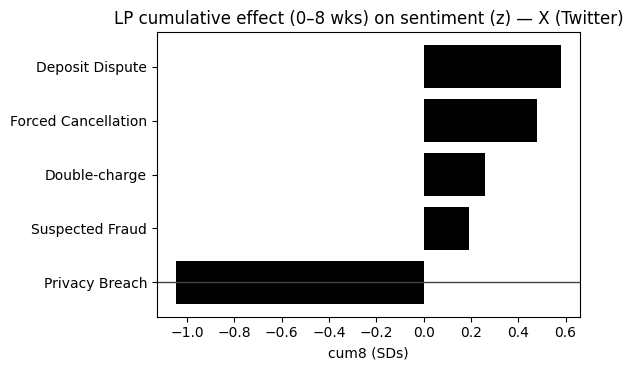

In [ ]:
def label_of(ev: str) -> str:
    return EVENT_LABEL.get(ev, (ev or "").replace("_", " "))

OUT = Path("artifacts/event_only/irf_platform")
OUT.mkdir(parents=True, exist_ok=True)

lp_csv = OUT / "lp/lp_effect_sizes.csv"
lp = pd.read_csv(lp_csv) if lp_csv.exists() else pd.DataFrame()

if not lp.empty:
    if "event_label" not in lp.columns and "event" in lp.columns:
        lp["event_label"] = lp["event"].apply(label_of)

var_csv = OUT / "var_irf_effect_sizes_scaled_1sd.csv"
var = pd.read_csv(var_csv) if var_csv.exists() else pd.DataFrame()

if not var.empty:
    if "event_label" not in var.columns and "event" in var.columns:
        var["event_label"] = var["event"].apply(label_of)

def label_dir(x):
    if pd.isna(x): return np.nan
    return "positive" if x > 0 else ("negative" if x < 0 else "zero")

if not lp.empty:
    lp["method"] = "LP"
    if "cum8" in lp.columns:
        lp["direction_cum8"] = lp["cum8"].apply(label_dir)

if not var.empty:
    var["method"] = "VAR"
    if "cum8_z" in var.columns:
        var["direction_cum8"] = var["cum8_z"].apply(label_dir)
    elif "cum8" in var.columns:
        var["direction_cum8"] = var["cum8"].apply(label_dir)

both = pd.concat(
    [
        (lp.rename(columns={"cum8": "cum8_z"}) if "cum8" in lp.columns else lp),
        (var.rename(columns={"cum8": "cum8_z"}) if "cum8" in var.columns else var),
    ],
    ignore_index=True, sort=False
)

if not both.empty:
    both.to_csv(OUT / "effects_for_report.csv", index=False)
    display(both.sort_values(["source", "method", "event_label" if "event_label" in both.columns else "event"]))
    print("Saved:", OUT / "effects_for_report.csv")

if not lp.empty and "cum8" in lp.columns:
    for src, g in lp.groupby("source"):
        g = g.copy()
        if "event_label" not in g.columns:
            g["event_label"] = g["event"].apply(label_of)
        g = g.sort_values("cum8")
        fig, ax = plt.subplots(figsize=(6, 3.8))
        ax.axhline(0, color="#444", lw=1)
        ax.barh(g["event_label"], g["cum8"], color=COLORS.get(src, "tab:blue"))
        ax.set_title(f"LP cumulative effect (0–8 wks) on sentiment (z) — {src}")
        ax.set_xlabel("cum8 (SDs)")
        plt.tight_layout()
        p = OUT / f"lp_cum8_bar__{src.replace(' ','_').replace('/','-')}.png"
        plt.savefig(p, dpi=150, bbox_inches="tight")
        plt.show()

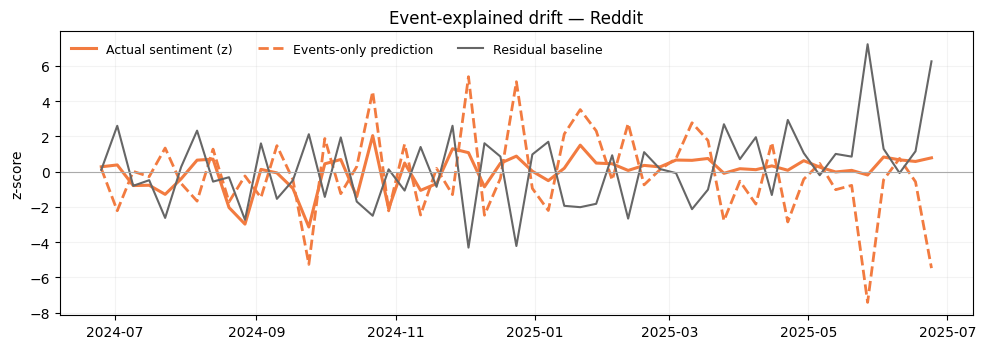

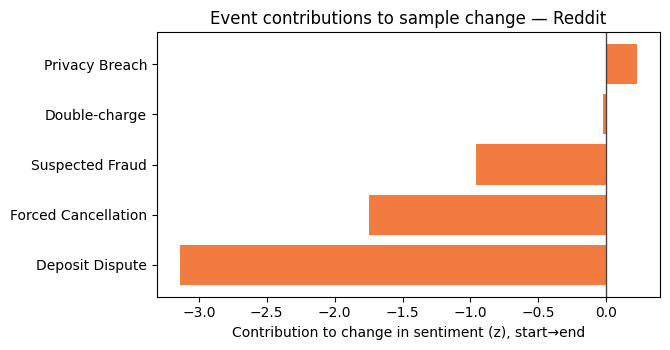

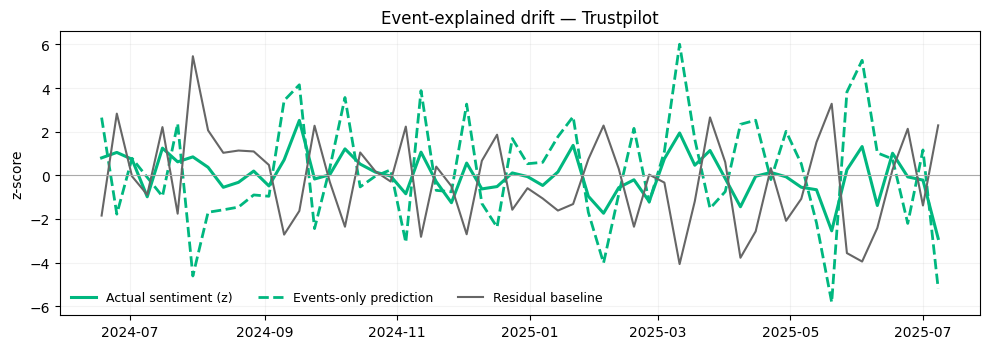

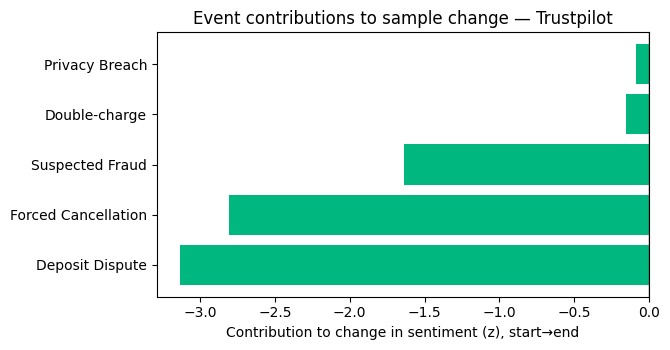

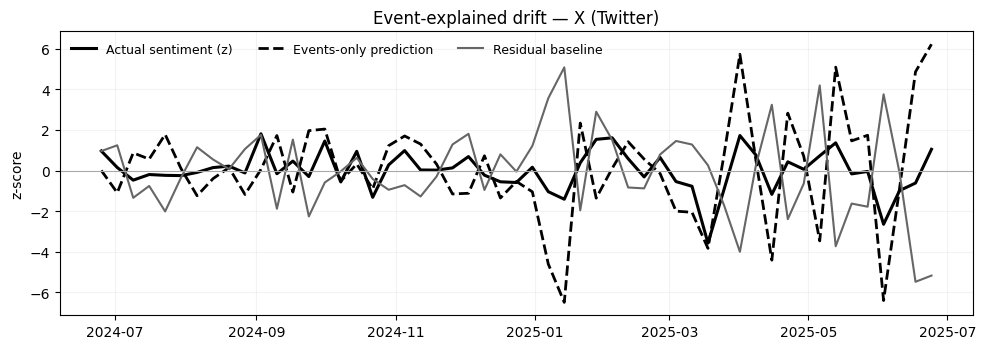

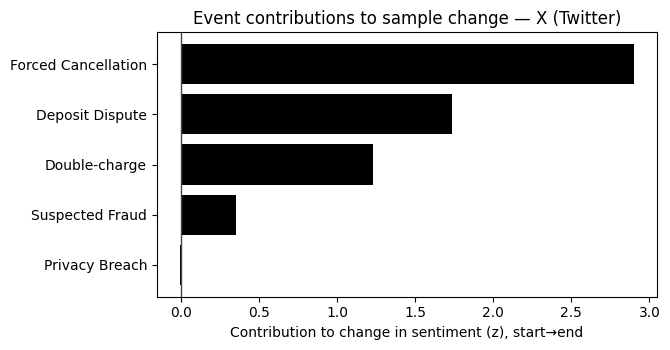

source  n_weeks  total_change  events_change  share_explained  \
0       Reddit       53      0.508009      -5.648626       -11.119156   
1   Trustpilot       56     -3.691119      -7.824289         2.119760   
2  X (Twitter)       53      0.082785       6.218302        75.113628   

   Forced Cancellation  Double-charge  Suspected Fraud  Privacy Breach  \
0            -1.748954      -0.024826        -0.961814        0.228077   
1            -2.806339      -0.154731        -1.640356       -0.090363   
2             2.900869       1.233400         0.356321       -0.007420   

   Deposit Dispute  
0        -3.141109  
1        -3.132500  
2         1.735132

Saved: artifacts/event_only/irf_platform/attribution/event_explained_drift_summary.csv 
Plus per-platform PNGs in: artifacts/event_only/irf_platform/attribution


In [ ]:
OUT_ATTR = Path("artifacts/event_only/irf_platform/attribution")
OUT_ATTR.mkdir(parents=True, exist_ok=True)

def lab(ev): return EVENT_LABEL.get(ev, ev.replace("_"," "))

def _platform_week(src):
    g = weekly_sent_platform[weekly_sent_platform["source"] == src].copy()
    if g.empty: return None
    df = (g.set_index("week_start")[["sent_mean"]].sort_index()
            .join(ev_wide, how="left").fillna(0.0))
    mu, sd = df["sent_mean"].mean(), df["sent_mean"].std(ddof=0)
    df["sent_z"] = (df["sent_mean"] - mu) / (sd + 1e-9)
    return df.drop(columns=["sent_mean"])

def lp_irf_one_event(df, event, H=12, p=4, add_trend=True, min_rows=20):
    """Return horizons, beta(h), se(h) for the event -> sentiment LP."""
    y = df["sent_z"].astype(float)
    x_ev = df[event].astype(float)
    shock = (x_ev - x_ev.mean()) / (x_ev.std(ddof=0) + 1e-9)  # +1 SD shock basis

    # lag controls
    Xlags = []
    for L in range(1, p+1):
        Xlags.append(y.shift(L).rename(f"y_l{L}"))
    for ev in KEEP_EVENTS:
        for L in range(1, p+1):
            Xlags.append(df[ev].astype(float).shift(L).rename(f"{ev}_l{L}"))
    Xlags = pd.concat(Xlags, axis=1)
    if add_trend:
        Xlags["t"] = np.arange(len(df), dtype=float)

    Hs = np.arange(0, H+1)
    betas = np.full(len(Hs), np.nan)
    ses   = np.full(len(Hs), np.nan)

    for i, h in enumerate(Hs):
        y_lead = y.shift(-h).rename("y_lead")
        X = pd.concat([shock.rename("shock"), Xlags], axis=1)
        data = pd.concat([y_lead, X], axis=1).dropna()
        if data.shape[0] < min_rows:
            continue
        Xmat = sm.add_constant(data.drop(columns=["y_lead"]), has_constant="add")
        res = sm.OLS(data["y_lead"], Xmat).fit(cov_type="HAC",
                                               cov_kwds={"maxlags": int(p+h)})
        betas[i] = res.params.get("shock", np.nan)
        ses[i]   = res.bse.get("shock", np.nan)
    return Hs, betas, ses

def fir_convolve(shock, beta):
    s = np.asarray(shock, float)
    b = np.asarray(beta, float)
    conv_full = np.convolve(s, b, mode="full")
    return conv_full[:len(s)]

platforms = sorted(weekly_sent_platform["source"].unique())
H, p = 12, 4

rows = []  # table of contributions
for src in platforms:
    df = _platform_week(src)
    if df is None:
        print(f"[{src}] no data.")
        continue

    kernels = {}
    pred_by_event = {}
    for ev in KEEP_EVENTS:
        h, beta, se = lp_irf_one_event(df, ev, H=H, p=p, add_trend=True)
        kernels[ev] = pd.Series(beta, index=h)

        z_ev = (df[ev] - df[ev].mean()) / (df[ev].std(ddof=0) + 1e-9)
        pred_by_event[ev] = pd.Series(fir_convolve(z_ev.values, beta),
                                      index=df.index, name=ev)

    pred_events = pd.concat(pred_by_event.values(), axis=1).sum(axis=1)
    resid_base  = df["sent_z"] - pred_events

    fig, ax = plt.subplots(figsize=(10, 3.6))
    col = COLORS.get(src, "tab:blue")
    ax.plot(df.index, df["sent_z"], label="Actual sentiment (z)", color=col, lw=2.2)
    ax.plot(df.index, pred_events, label="Events-only prediction", color=col, lw=2, ls="--")
    ax.plot(df.index, resid_base, label="Residual baseline", color="#666", lw=1.5)
    ax.axhline(0, color="#aaa", lw=0.8)
    ax.set_title(f"Event-explained drift — {src}")
    ax.set_ylabel("z-score")
    ax.legend(ncol=3, fontsize=9, frameon=False)
    ax.grid(alpha=0.15)
    plt.tight_layout()
    p_png = OUT_ATTR / f"attribution_timeseries__{src.replace(' ','_').replace('/','-')}.png"
    plt.savefig(p_png, dpi=150, bbox_inches="tight"); plt.show()

    total_change = float(df["sent_z"].iloc[-1] - df["sent_z"].iloc[0])
    events_change = float(pred_events.iloc[-1] - pred_events.iloc[0])
    share_explained = np.nan if abs(total_change) < 1e-9 else events_change / total_change

    contrib = {ev: float(pred_by_event[ev].iloc[-1] - pred_by_event[ev].iloc[0])
               for ev in KEEP_EVENTS}

    g = pd.Series(contrib).rename(index=lambda e: lab(e)).sort_values()
    fig, ax = plt.subplots(figsize=(6.8, 3.6))
    ax.axvline(0, color="#444", lw=1)
    ax.barh(g.index, g.values, color=col)
    ax.set_title(f"Event contributions to sample change — {src}")
    ax.set_xlabel("Contribution to change in sentiment (z), start→end")
    plt.tight_layout()
    p_bar = OUT_ATTR / f"attribution_contrib_bar__{src.replace(' ','_').replace('/','-')}.png"
    plt.savefig(p_bar, dpi=150, bbox_inches="tight"); plt.show()

    row = {
        "source": src,
        "n_weeks": len(df),
        "total_change": total_change,
        "events_change": events_change,
        "share_explained": share_explained,
    }
    for ev in KEEP_EVENTS:
        row[f"contrib_{ev}"] = contrib[ev]
    rows.append(row)

attr_df = pd.DataFrame(rows)
if not attr_df.empty:
    for ev in KEEP_EVENTS:
        attr_df[lab(ev)] = attr_df[f"contrib_{ev}"]
    keep_cols = (["source","n_weeks","total_change","events_change","share_explained"] +
                 [lab(ev) for ev in KEEP_EVENTS])
    attr_df[keep_cols].to_csv(OUT_ATTR / "event_explained_drift_summary.csv", index=False)
    display(attr_df[keep_cols].sort_values("source"))
    print("Saved:",
          OUT_ATTR / "event_explained_drift_summary.csv",
          "\nPlus per-platform PNGs in:", OUT_ATTR)
else:
    print("No attribution table produced.")

**ADF FIX**

In [12]:
START_DATE = "2024-07-01"
END_DATE   = "2025-06-30"

assert {"date","source"}.issubset(df.columns), "Need 'date' and 'source' columns."

src = df["source"].astype(str).str.strip()
tp_mask = src.str.lower().eq("trustpilot")
date_str = df["date"].astype(str).str.strip()

has_time = date_str.str.contains(r":")
date_str.loc[tp_mask & ~has_time] = date_str.loc[tp_mask & ~has_time] + " 00:00"

d_all = pd.to_datetime(date_str, errors="coerce", dayfirst=False)

need_df = tp_mask & d_all.isna()
if need_df.any():
    d_fix = pd.to_datetime(date_str[need_df], errors="coerce", dayfirst=True)
    d_all.loc[need_df] = d_fix

still = d_all.isna()
if still.any():
    d_fallback = pd.to_datetime(date_str[still], errors="coerce")
    d_all.loc[still] = d_fallback

try:
    d_all = d_all.dt.tz_localize(None)
except Exception:
    pass
df["date"] = d_all

bad = int(df["date"].isna().sum())
if bad:
    print(f"Warning: dropping {bad} rows with unparseable dates.")
df = df.dropna(subset=["date"]).copy()

wk = (
    df.assign(week_start=(df["date"] - pd.to_timedelta(df["date"].dt.weekday, unit="D")).dt.normalize())
      .drop_duplicates(["source","week_start"])
)
print("Trustpilot week coverage (min, max, count):")
print(wk[wk["source"]=="Trustpilot"]["week_start"].agg(["min","max","nunique"]))

Trustpilot week coverage (min, max, count):
min        2024-06-17 00:00:00
max        2025-07-07 00:00:00
nunique                     56
Name: week_start, dtype: object


In [13]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
try:
    df["date"] = df["date"].dt.tz_localize(None)
except Exception:
    pass

df = df.dropna(subset=["date", "source", "sentiment_label"]).copy()

sign_map = {"label_0": -1, "Negative": -1,
            "label_1": 0,  "Neutral": 0,
            "label_2": 1,  "Positive": 1}
df["sign"] = df["sentiment_label"].map(sign_map).astype(float)

conf_col = "confidence" if "confidence" in df.columns else "sentiment_score"
if conf_col not in df.columns:
    raise KeyError("Need a confidence column: add 'confidence' or reuse 'sentiment_score'.")

df[conf_col] = pd.to_numeric(df[conf_col], errors="coerce")
df = df.dropna(subset=[conf_col]).copy()

df["metric_soft"] = df["sign"] * df[conf_col]   # weighted (soft)
df["metric_hard"] = df["sign"]                  # unweighted (hard)

df_ready_soft = df[["date", "source", "metric_soft"]].rename(columns={"metric_soft": "metric"}).copy()
df_ready_hard = df[["date", "source", "metric_hard"]].rename(columns={"metric_hard": "metric"}).copy()

In [15]:
df_ready_soft["source"] = df_ready_soft["source"]

mask = True
if START_DATE: mask &= (df_ready_soft["date"] >= pd.to_datetime(START_DATE))
if END_DATE:   mask &= (df_ready_soft["date"] <= pd.to_datetime(END_DATE))
df_soft = df_ready_soft.loc[mask].copy()

weekly_long = (
    df_soft.set_index("date")
           .groupby("source")
           .resample("W-MON", label="left", closed="left")
           .agg(soft_mean=("metric", "mean"),
                soft_std =("metric", "std"),
                n_posts  =("metric", "size"))
           .reset_index()
           .rename(columns={"date": "week_start"})
)

def pad_weeks_per_source(wdf: pd.DataFrame) -> pd.DataFrame:
    out = []
    for src, g in wdf.groupby("source", sort=False):
        all_mondays = pd.date_range(g["week_start"].min(), g["week_start"].max(), freq="W-MON")
        base = pd.DataFrame({"week_start": all_mondays})
        base["source"] = src
        out.append(base.merge(g, on=["source","week_start"], how="left"))
    out = pd.concat(out, ignore_index=True)
    out["n_posts"] = out["n_posts"].fillna(0)
    return out

weekly_long = pad_weeks_per_source(weekly_long)

weekly_df_wide = weekly_long.pivot(index="week_start", columns="source", values="soft_mean").sort_index()
weekly_df_wide.columns.name = None

Path("artifacts").mkdir(exist_ok=True)
weekly_long.to_parquet("artifacts/weekly_sentiment_long.parquet", index=False)
weekly_df_wide.to_parquet("artifacts/weekly_sentiment_wide.parquet")

display(weekly_df_wide.tail())

Reddit  Trustpilot  X (Twitter)
week_start                                   
2025-06-02 -0.121966   -0.442622    -0.291463
2025-06-09 -0.163824   -0.602722    -0.192109
2025-06-16 -0.144200   -0.437405    -0.217892
2025-06-23 -0.138996   -0.513360    -0.071493
2025-06-30       NaN   -0.808480          NaN

In [18]:
from statsmodels.tsa.stattools import adfuller

def adf_transform(s: pd.Series, maxlag=8, alpha=0.05):
    s = pd.Series(s).astype(float).dropna()
    if len(s) < 20:
        return s, "as_is"

    p_c  = adfuller(s, maxlag=maxlag, regression="c",  autolag="AIC")[1]
    if p_c < alpha:
        return s, "as_is"

    p_ct = adfuller(s, maxlag=maxlag, regression="ct", autolag="AIC")[1]
    if p_ct < alpha:
        t = np.arange(len(s), dtype=float)
        X = np.column_stack([np.ones(len(s)), t])
        beta = np.linalg.lstsq(X, s.values, rcond=None)[0]
        resid = s.values - X.dot(beta)
        return pd.Series(resid, index=s.index), "detrended"

    return s.diff().dropna(), "diffed"

def make_stationary_df(df: pd.DataFrame, maxlag=8, alpha=0.05):
    sta, steps = {}, {}
    for c in df.columns:
        sta[c], steps[c] = adf_transform(df[c], maxlag=maxlag, alpha=alpha)
    sta_df = pd.DataFrame(sta).dropna()
    return sta_df, steps

In [19]:
cols = [c for c in ["X (Twitter)","Reddit","Trustpilot"] if c in weekly_df_wide.columns]
Y_sta, adf_steps = make_stationary_df(weekly_df_wide[cols], maxlag=8, alpha=0.05)

print("ADF transform used:", adf_steps)
pd.Series(adf_steps, name="ADF_transform").to_csv("artifacts/adf_transform_platforms.csv")

display(Y_sta.tail())

ADF transform used: {'X (Twitter)': 'detrended', 'Reddit': 'as_is', 'Trustpilot': 'as_is'}


X (Twitter)    Reddit  Trustpilot
week_start                                   
2025-05-26     0.009956 -0.307499   -0.500198
2025-06-02    -0.125626 -0.121966   -0.442622
2025-06-09    -0.025751 -0.163824   -0.602722
2025-06-16    -0.051014 -0.144200   -0.437405
2025-06-23     0.095906 -0.138996   -0.513360

In [20]:
from statsmodels.tsa.api import VAR

ord_cols = [c for c in ["X (Twitter)","Reddit","Trustpilot"] if c in Y_sta.columns]
Y_ord = Y_sta[ord_cols]

best_res, best_aic, best_p = None, 1e9, None
for p in range(2, 9):
    try:
        res = VAR(Y_ord).fit(p)
        if res.aic < best_aic:
            best_res, best_aic, best_p = res, res.aic, p
    except Exception:
        pass

print(f"Chosen VAR lag p = {best_p}, AIC = {best_aic:.3f}")
irf = best_res.irf(12)
orth = irf.orth_irfs

idx = {name:i for i,name in enumerate(ord_cols)}
steps = np.arange(orth.shape[0])

out = {}
if "Trustpilot" in idx:
    tp = idx["Trustpilot"]
    for src in ord_cols:
        out[f"{src}_to_TP"] = orth[:, idx[src], tp]
df_irf = pd.DataFrame({"h": steps, **out})
df_irf.to_csv("artifacts/var_irfs_to_trustpilot.csv", index=False)
df_irf.head()

Chosen VAR lag p = 2, AIC = -13.850


h  X (Twitter)_to_TP  Reddit_to_TP  Trustpilot_to_TP
0  0           0.000000      0.000000          0.070222
1  1          -0.008513      0.002228         -0.002127
2  2           0.008694     -0.007047         -0.013628
3  3           0.001466      0.001370         -0.002480
4  4           0.000235     -0.000428          0.002999

In [21]:
APP = Path("artifacts/appendix"); APP.mkdir(parents=True, exist_ok=True)

cand_wide = [
    Path("artifacts/weekly_sentiment_wide.parquet"),
    Path("artifacts/event_only/weekly_sentiment_wide.parquet"),
]
p_wide = next((p for p in cand_wide if p.exists()), None)
if p_wide is None:
    raise FileNotFoundError("Could not find weekly_sentiment_wide.parquet in artifacts/ or artifacts/event_only/")

wide = pd.read_parquet(p_wide)
sent_cols = [c for c in ["X (Twitter)","Reddit","Trustpilot"] if c in wide.columns]
wide = wide[sent_cols].copy()

corr_pearson  = wide.corr(method="pearson",  min_periods=8)
corr_spearman = wide.corr(method="spearman", min_periods=8)

corr_pearson.to_csv(APP / "corr_sentiment_platforms_pearson.csv")
corr_spearman.to_csv(APP / "corr_sentiment_platforms_spearman.csv")

print("Platform sentiment correlations (Pearson):")
display(corr_pearson.round(3))
print("Platform sentiment correlations (Spearman):")
display(corr_spearman.round(3))

cand_events = [
    Path("artifacts/weekly_events.parquet"),
    Path("artifacts/event_only/weekly_events.parquet"),
]
p_ev = next((p for p in cand_events if p.exists()), None)

if p_ev is not None:
    events = pd.read_parquet(p_ev)
    need = {"source","event_type","week_start","share"}
    if not need.issubset(events.columns):
        print("[skip] weekly_events found but missing columns", need - set(events.columns))
    else:
        for src in sent_cols:
            s = pd.read_parquet(p_wide)[[src]].copy()
            s.index.name = "week_start"

            ev_src = events[events["source"] == src].copy()
            mat = ev_src.pivot(index="week_start", columns="event_type", values="share").sort_index()
            df_join = s.join(mat, how="left")
            corr_vec = df_join.corr(method="pearson")[src].drop(index=src).sort_values(ascending=False)

            out_name = f"corr_events_{src.replace(' ','_').replace('(','').replace(')','')}_pearson.csv"
            corr_vec.to_csv(APP / out_name)
            print(f"\nTop event correlations with {src} sentiment (Pearson):")
            display(corr_vec.head(10).round(3))
else:
    print("\nNo weekly events table found. Skipping event↔sentiment correlations.")

Platform sentiment correlations (Pearson):


X (Twitter)  Reddit  Trustpilot
X (Twitter)        1.000  -0.057      -0.389
Reddit            -0.057   1.000      -0.088
Trustpilot        -0.389  -0.088       1.000

Platform sentiment correlations (Spearman):


X (Twitter)  Reddit  Trustpilot
X (Twitter)        1.000  -0.083      -0.447
Reddit            -0.083   1.000      -0.073
Trustpilot        -0.447  -0.073       1.000


No weekly events table found. Skipping event↔sentiment correlations.


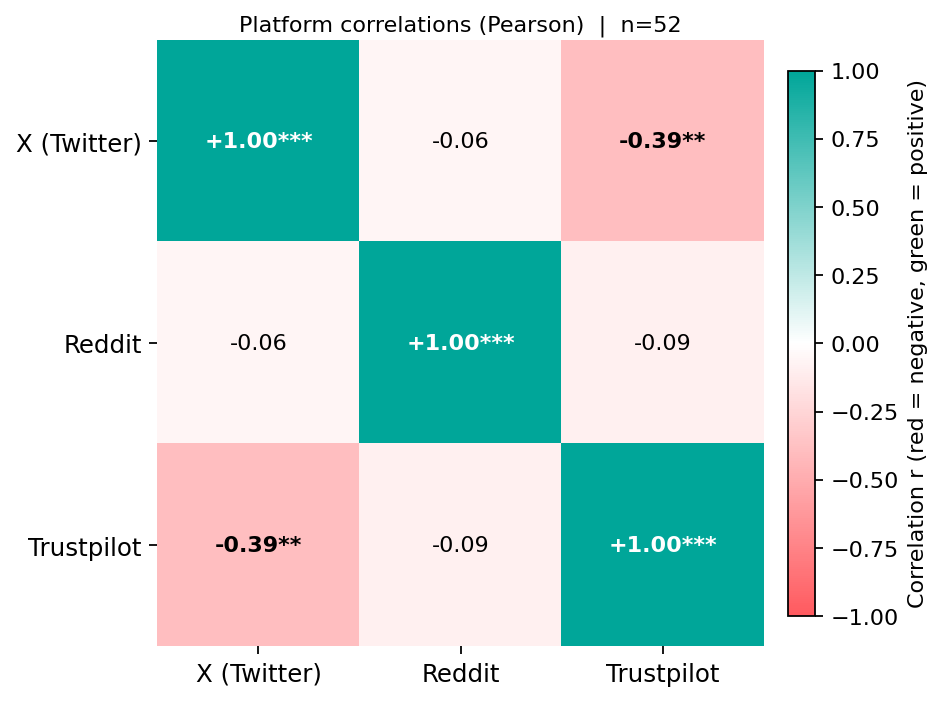

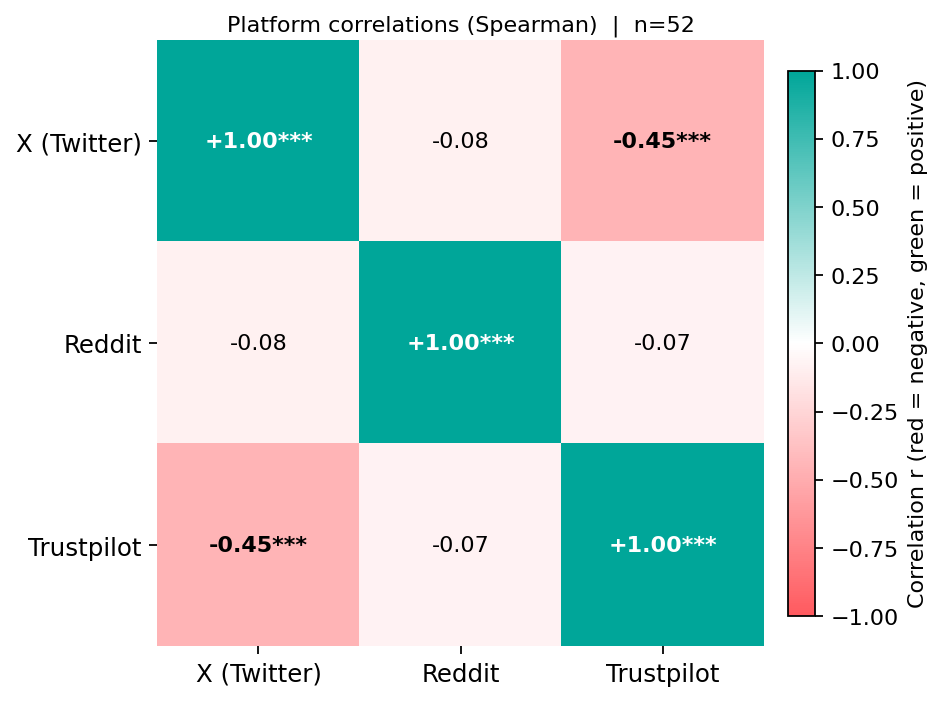

In [25]:
wide_num = wide.copy()
for c in wide_num.columns:
    wide_num[c] = pd.to_numeric(wide_num[c], errors="coerce")
wide_common = wide_num.dropna().copy()

from scipy.stats import pearsonr, spearmanr
import numpy as np, pandas as pd

def corr_with_p(df: pd.DataFrame, method: str = "pearson"):
    cols = df.columns.tolist()
    R = pd.DataFrame(np.eye(len(cols)), index=cols, columns=cols, dtype=float)
    P = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols, dtype=float)
    for i, a in enumerate(cols):
        for j, b in enumerate(cols):
            if j < i:
                continue
            if i == j:
                R.iat[i, j] = 1.0
                P.iat[i, j] = 0.0
                continue
            pair = df[[a, b]].dropna()
            n = len(pair)
            if n < 3:
                r = np.nan; p = np.nan
            else:
                x = np.asarray(pair[a], dtype=float).reshape(-1)
                y = np.asarray(pair[b], dtype=float).reshape(-1)
                try:
                    if method == "pearson":
                        r, p = pearsonr(x, y)
                    else:
                        r, p = spearmanr(x, y)
                except Exception:
                    r, p = np.nan, np.nan
            R.iat[i, j] = r
            P.iat[i, j] = p
            R.iat[j, i] = r
            P.iat[j, i] = p
    return R, P

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

RED_WHITE_GREEN = LinearSegmentedColormap.from_list(
    "red_white_green",
    [(0.0, "#FF5A5F"), (0.5, "#FFFFFF"), (1.0, "#00A699")],
    N=256
)

def plot_corr_heatmap(R: pd.DataFrame, P: pd.DataFrame, title: str, out_png: Path):
    fig, ax = plt.subplots(figsize=(5.8, 4.6), dpi=160, constrained_layout=True)
    im = ax.imshow(R.values, vmin=-1, vmax=1, cmap=RED_WHITE_GREEN)
    ax.set_xticks(range(len(R.columns))); ax.set_xticklabels(R.columns, fontsize=11)
    ax.set_yticks(range(len(R.index)));   ax.set_yticklabels(R.index, fontsize=11)
    ax.set_title(title, fontsize=10, fontweight=400, pad=4)

    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            r = R.iat[i, j]; p = P.iat[i, j]
            if np.isnan(r):
                lab = ""
            else:
                stars = "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else ""))
                lab = f"{r:+.2f}{stars}"
            txt_color = "white" if (not np.isnan(r) and abs(r) >= 0.6) else "black"
            ax.text(j, i, lab, ha="center", va="center",
                    color=txt_color, fontsize=10,
                    fontweight=("bold" if (not np.isnan(r) and p < 0.05) else "normal"))

    cbar = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.04)
    cbar.set_label("Correlation r (red = negative, green = positive)")
    ax.set_aspect("equal")
    for s in ax.spines.values(): s.set_visible(False)
    fig.savefig(out_png, dpi=220, bbox_inches="tight")
    plt.show()

APP = Path("artifacts/appendix"); APP.mkdir(parents=True, exist_ok=True)

R_p, P_p = corr_with_p(wide_common, method="pearson")
R_p.to_csv(APP / "corr_sentiment_platforms_pearson.csv")
P_p.to_csv(APP / "corr_sentiment_platforms_pearson_pvals.csv")
plot_corr_heatmap(R_p, P_p,
                  title=f"Platform correlations (Pearson)  |  n={len(wide_common)}",
                  out_png=APP / "corr_heatmap_platforms_pearson.png")

R_s, P_s = corr_with_p(wide_common, method="spearman")
R_s.to_csv(APP / "corr_sentiment_platforms_spearman.csv")
P_s.to_csv(APP / "corr_sentiment_platforms_spearman_pvals.csv")
plot_corr_heatmap(R_s, P_s,
                  title=f"Platform correlations (Spearman)  |  n={len(wide_common)}",
                  out_png=APP / "corr_heatmap_platforms_spearman.png")

In [22]:
APP = Path("artifacts/appendix"); APP.mkdir(parents=True, exist_ok=True)

def adf_two_specs(s: pd.Series, maxlag=8):
    s = pd.Series(s).astype(float).dropna()
    out = {"n": int(s.shape[0])}
    # ADF with constant
    res_c  = adfuller(s, maxlag=maxlag, regression="c",  autolag="AIC")
    out.update({
        "adf_stat_c":  res_c[0], "p_c":  res_c[1], "lags_c":  res_c[2], "nobs_c":  res_c[3],
        "crit1_c": res_c[4]["1%"], "crit5_c": res_c[4]["5%"], "crit10_c": res_c[4]["10%"]
    })
    # ADF with trend
    res_ct = adfuller(s, maxlag=maxlag, regression="ct", autolag="AIC")
    out.update({
        "adf_stat_ct": res_ct[0], "p_ct": res_ct[1], "lags_ct": res_ct[2], "nobs_ct": res_ct[3],
        "crit1_ct": res_ct[4]["1%"], "crit5_ct": res_ct[4]["5%"], "crit10_ct": res_ct[4]["10%"]
    })
    if out["p_c"] < 0.05:
        out["decision"] = "as_is"
    elif out["p_ct"] < 0.05:
        out["decision"] = "detrended"
    else:
        out["decision"] = "diffed"
    return out

series_cols = [c for c in ["X (Twitter)", "Reddit", "Trustpilot"] if c in weekly_df_wide.columns]
rows = []
for col in series_cols:
    rows.append({"series": col, **adf_two_specs(weekly_df_wide[col], maxlag=8)})

adf_table = (pd.DataFrame(rows)
             .set_index("series")
             .loc[:, ["n",
                      "adf_stat_c","p_c","lags_c",
                      "adf_stat_ct","p_ct","lags_ct",
                      "decision"]])

display(adf_table.round(4))
adf_table.to_csv(APP / "adf_results_platforms.csv", float_format="%.4f")
print("Saved:", (APP / "adf_results_platforms.csv").resolve())

n  adf_stat_c     p_c  lags_c  adf_stat_ct    p_ct  lags_ct  \
series                                                                      
X (Twitter)  52     -2.3773  0.1482       8      -5.3513  0.0000        7   
Reddit       52     -5.6896  0.0000       0      -7.0187  0.0000        0   
Trustpilot   53     -4.2331  0.0006       3      -5.0107  0.0002        3   

              decision  
series                  
X (Twitter)  detrended  
Reddit           as_is  
Trustpilot       as_is

Saved: /content/artifacts/appendix/adf_results_platforms.csv


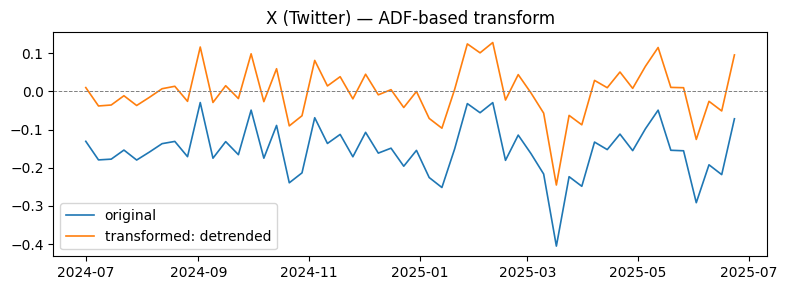

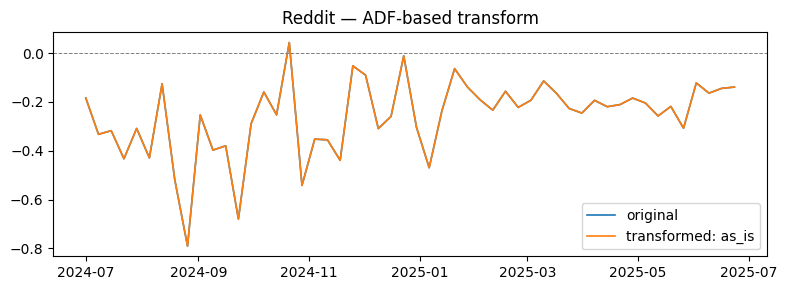

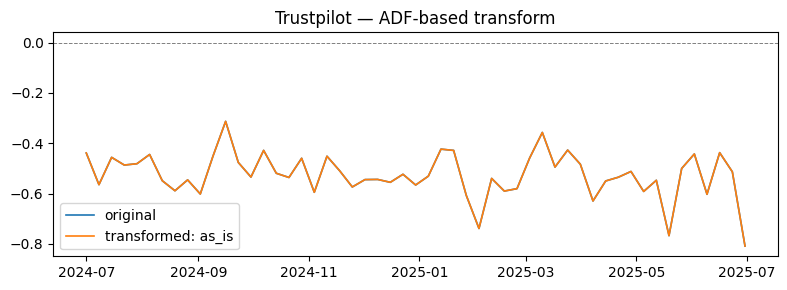

In [23]:
for col in series_cols:
    s0 = weekly_df_wide[col].dropna()
    s1, dec = adf_transform(s0, maxlag=8, alpha=0.05)

    s1 = s1.reindex(s0.index)

    plt.figure(figsize=(8,3))
    plt.plot(s0.index, s0.values, label="original", linewidth=1.2)
    plt.plot(s1.index, s1.values, label=f"transformed: {dec}", linewidth=1.2)
    plt.title(f"{col} — ADF-based transform")
    plt.axhline(0, color="gray", linewidth=0.7, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()